# Malicious URL Analysis & Predictive Modelling

In [1]:
# Initial required libraries for analysis are imported:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse
import re

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')


# Import/Sense-Checking of Data

In [2]:
# The dataset is imported into a DataFrame:

urls = pd.read_csv('malicious_phish.csv')

In [3]:
# The data is sense-checked:

urls.info()

# There are 651,190 entries in the data set.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [4]:
urls.head()

url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement

In [5]:
urls.describe()

url    type
count                                              651191  651191
unique                                             641119       4
top     http://style.org.hc360.com/css/detail/mysite/s...  benign
freq                                                  180  428103

In [6]:
print(urls.shape)
print(urls.dtypes)

(651191, 2)
url     object
type    object
dtype: object


In [7]:
# The data is checked for null values:

urls.isnull().sum()

# There are no null values.

url     0
type    0
dtype: int64

In [8]:
# Type categories are checked to determine what they are:

print(urls['type'].unique())

['phishing' 'benign' 'defacement' 'malware']


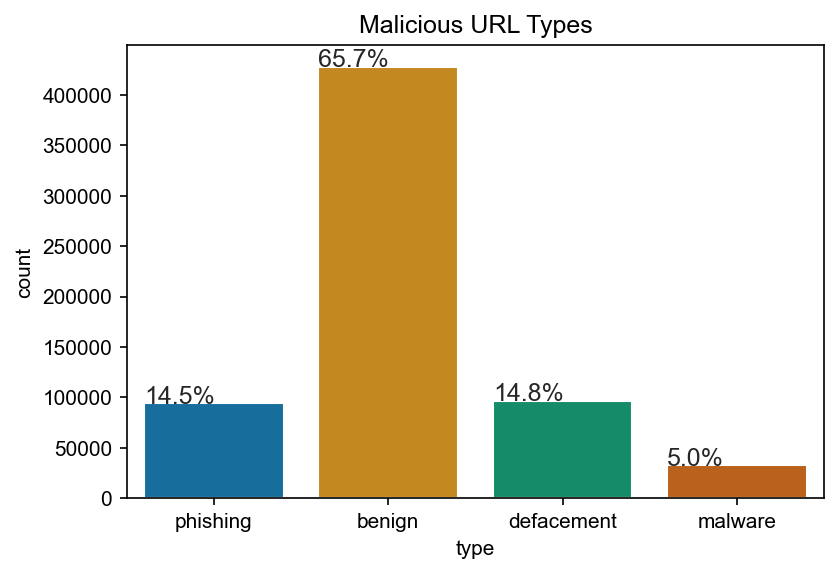

In [9]:
# The type categories are presented in a countplot to see how many belong to each category.
# 65.7% are benign.  This also shows that the data is not balanced (important for later model building):

fig, ax = plt.subplots(dpi=150)

sns.set(rc = {'figure.figsize':(15, 20)})
ax.set_title("Malicious URL Types")
ax.set_xlabel("Type")
ax.set_ylabel("Total URLs")

sns.countplot(x='type', palette='colorblind', data=urls)

# Labels showing the count of each bar are added to the chart:
total_url_types = len(urls)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total_url_types)
    x = p.get_x()
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y))

# Chart exported to png:
fig.savefig('malicious_urls_types_countplot.png')

# Data Wrangling

In [131]:
# Code written to iterate through the dataset and break down the URLs into their elements using the urlparse 
# library.
# Only run once - very resource-intensive.  Output to a csv for later importation to avoid the need to run this
# code again:

def url_parser(url):
    
    parts = urlparse(url)
    directories = parts.path.strip('/').split('/')
    queries = parts.query.strip('&').split('&')
    
    elements = {
        'scheme': parts.scheme,
        'netloc': parts.netloc,
        'path': parts.path,
        'params': parts.params,
        'query': parts.query,
        'fragment': parts.fragment,
        'directories': directories,
        'queries': queries,
    }
    
    return elements

In [132]:
def url_components_to_df(urls, url='url'):
    df_output = pd.DataFrame(columns = ['scheme', 'netloc', 'path', 
                                        'params', 'query', 'fragment',
                                        'directories', 'queries'])
    for index, row in urls.iterrows(): 

        elements = url_parser(row['url'])

        page = {
            'scheme': elements['scheme'],
            'netloc': elements['netloc'],
            'path': elements['path'], 
            'params': elements['params'],
            'query': elements['query'],
            'fragment': elements['fragment'], 
            'directories': elements['directories'],
            'queries': elements['queries'],            
        }

        df_output = df_output.append(page, ignore_index=True)
    
    return df_output



In [133]:
df_output = url_components_to_df(urls)
df_output.tail()

In [11]:
# DataFrame written to csv to store results and avoid running the code again:

df_output.to_csv("urls_deconstructed.csv")

In [12]:
# CSV file is read into a DataFrame:

url_split = pd.read_csv('urls_deconstructed.csv')

url_split.head()

# The URLs have now been split into their component parts for easier analysis.

Unnamed: 0 scheme                   netloc  \
0           0    NaN                      NaN   
1           1    NaN                      NaN   
2           2    NaN                      NaN   
3           3   http    www.garage-pirenne.be   
4           4   http  adventure-nicaragua.net   

                                  path params  \
0                     br-icloud.com.br    NaN   
1  mp3raid.com/music/krizz_kaliko.html    NaN   
2      bopsecrets.org/rexroth/cr/1.htm    NaN   
3                           /index.php    NaN   
4                           /index.php    NaN   

                                               query fragment  \
0                                                NaN      NaN   
1                                                NaN      NaN   
2                                                NaN      NaN   
3  option=com_content&view=article&id=70&vsig70_0=15      NaN   
4  option=com_mailto&tmpl=component&link=aHR0cDov...      NaN   

                                     directories  \
0                           ['br-icloud.com.br']   
1  ['mp3raid.com', 'music', 'krizz_kaliko.html']   
2   ['bopsecrets.org', 'rexroth', 'cr', '1.htm']   
3                                  ['index.php']   
4                                  ['index.php']   

                                             queries  
0                                               ['']  
1                                               ['']  
2                                               ['']  
3  ['option=com_content', 'view=article', 'id=70'...  
4  ['option=com_mailto', 'tmpl=component', 'link=...

In [13]:
url_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   651191 non-null  int64 
 1   scheme       188182 non-null  object
 2   netloc       187999 non-null  object
 3   path         650638 non-null  object
 4   params       335 non-null     object
 5   query        139973 non-null  object
 6   fragment     461 non-null     object
 7   directories  651191 non-null  object
 8   queries      651191 non-null  object
dtypes: int64(1), object(8)
memory usage: 44.7+ MB


In [14]:
# The original DataFrame is concatenated to the new deconstructed data:

all_urls_data = pd.concat([urls, url_split], axis=1)

all_urls_data.head()

url        type  Unnamed: 0  \
0                                   br-icloud.com.br    phishing           0   
1                mp3raid.com/music/krizz_kaliko.html      benign           1   
2                    bopsecrets.org/rexroth/cr/1.htm      benign           2   
3  http://www.garage-pirenne.be/index.php?option=...  defacement           3   
4  http://adventure-nicaragua.net/index.php?optio...  defacement           4   

  scheme                   netloc                                 path params  \
0    NaN                      NaN                     br-icloud.com.br    NaN   
1    NaN                      NaN  mp3raid.com/music/krizz_kaliko.html    NaN   
2    NaN                      NaN      bopsecrets.org/rexroth/cr/1.htm    NaN   
3   http    www.garage-pirenne.be                           /index.php    NaN   
4   http  adventure-nicaragua.net                           /index.php    NaN   

                                               query fragment  \
0                                                NaN      NaN   
1                                                NaN      NaN   
2                                                NaN      NaN   
3  option=com_content&view=article&id=70&vsig70_0=15      NaN   
4  option=com_mailto&tmpl=component&link=aHR0cDov...      NaN   

                                     directories  \
0                           ['br-icloud.com.br']   
1  ['mp3raid.com', 'music', 'krizz_kaliko.html']   
2   ['bopsecrets.org', 'rexroth', 'cr', '1.htm']   
3                                  ['index.php']   
4                                  ['index.php']   

                                             queries  
0                                               ['']  
1                                               ['']  
2                                               ['']  
3  ['option=com_content', 'view=article', 'id=70'...  
4  ['option=com_mailto', 'tmpl=component', 'link=...

In [15]:
# The 'Unnamed' column is dropped and 'www' is removed from every URL in the netloc column:

all_urls_data = all_urls_data.drop('Unnamed: 0', axis=1)
all_urls_data['netloc'] = all_urls_data['netloc'].str.replace(r'^www\.', '', regex=True)

all_urls_data.head()

url        type scheme  \
0                                   br-icloud.com.br    phishing    NaN   
1                mp3raid.com/music/krizz_kaliko.html      benign    NaN   
2                    bopsecrets.org/rexroth/cr/1.htm      benign    NaN   
3  http://www.garage-pirenne.be/index.php?option=...  defacement   http   
4  http://adventure-nicaragua.net/index.php?optio...  defacement   http   

                    netloc                                 path params  \
0                      NaN                     br-icloud.com.br    NaN   
1                      NaN  mp3raid.com/music/krizz_kaliko.html    NaN   
2                      NaN      bopsecrets.org/rexroth/cr/1.htm    NaN   
3        garage-pirenne.be                           /index.php    NaN   
4  adventure-nicaragua.net                           /index.php    NaN   

                                               query fragment  \
0                                                NaN      NaN   
1                                                NaN      NaN   
2                                                NaN      NaN   
3  option=com_content&view=article&id=70&vsig70_0=15      NaN   
4  option=com_mailto&tmpl=component&link=aHR0cDov...      NaN   

                                     directories  \
0                           ['br-icloud.com.br']   
1  ['mp3raid.com', 'music', 'krizz_kaliko.html']   
2   ['bopsecrets.org', 'rexroth', 'cr', '1.htm']   
3                                  ['index.php']   
4                                  ['index.php']   

                                             queries  
0                                               ['']  
1                                               ['']  
2                                               ['']  
3  ['option=com_content', 'view=article', 'id=70'...  
4  ['option=com_mailto', 'tmpl=component', 'link=...

In [16]:
# Create subset dataframes for each URL type for further analysis:

benign_urls = all_urls_data[all_urls_data['type'] == "benign"]

benign_urls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428103 entries, 1 to 603181
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   url          428103 non-null  object
 1   type         428103 non-null  object
 2   scheme       35523 non-null   object
 3   netloc       35378 non-null   object
 4   path         428103 non-null  object
 5   params       108 non-null     object
 6   query        72741 non-null   object
 7   fragment     98 non-null      object
 8   directories  428103 non-null  object
 9   queries      428103 non-null  object
dtypes: object(10)
memory usage: 35.9+ MB


In [17]:
phishing_urls = all_urls_data[all_urls_data['type'] == "phishing"]
defacement_urls = all_urls_data[all_urls_data['type'] == "defacement"]
malware_urls = all_urls_data[all_urls_data['type'] == "malware"]

In [18]:
phishing_urls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94111 entries, 0 to 651190
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   url          94111 non-null  object
 1   type         94111 non-null  object
 2   scheme       24882 non-null  object
 3   netloc       24854 non-null  object
 4   path         93562 non-null  object
 5   params       81 non-null     object
 6   query        8148 non-null   object
 7   fragment     362 non-null    object
 8   directories  94111 non-null  object
 9   queries      94111 non-null  object
dtypes: object(10)
memory usage: 7.9+ MB


In [19]:
defacement_urls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96457 entries, 3 to 520325
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   url          96457 non-null  object
 1   type         96457 non-null  object
 2   scheme       96457 non-null  object
 3   netloc       96457 non-null  object
 4   path         96457 non-null  object
 5   params       0 non-null      object
 6   query        54962 non-null  object
 7   fragment     1 non-null      object
 8   directories  96457 non-null  object
 9   queries      96457 non-null  object
dtypes: object(10)
memory usage: 8.1+ MB


In [20]:
malware_urls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32520 entries, 38 to 555185
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   url          32520 non-null  object
 1   type         32520 non-null  object
 2   scheme       31320 non-null  object
 3   netloc       31310 non-null  object
 4   path         32516 non-null  object
 5   params       146 non-null    object
 6   query        4122 non-null   object
 7   fragment     0 non-null      object
 8   directories  32520 non-null  object
 9   queries      32520 non-null  object
dtypes: object(10)
memory usage: 2.7+ MB


# Exploratory Data Analysis of Benign URLs

In [21]:
# The benign URLs are checked for top 10 trends as regards directories and queries, in order to compare with
# trends within the malicious URL categories.

# The directories are cleaned and turned into string format:

benign_dirs = benign_urls['directories'].str[1:-1].reset_index()

benign_dirs['directories'] = benign_dirs['directories'].str.replace(r'\'', '', regex=True)

benign_dirs = pd.DataFrame(benign_dirs['directories'].apply(lambda x: ''.join(map(str, x))))

benign_dirs.dropna()

# The directories/directory combinations are sorted in descending order in new DataFrame:

benign_dirs_df = pd.DataFrame(benign_dirs['directories'].value_counts())

benign_dirs_df.rename(columns={'directories':'count_of_directories'}, inplace=True)

benign_dirs_df.index.names = ['directories']

benign_dirs_df.reset_index(inplace=True)

print(benign_dirs_df)

                                              directories  \
0                                      youtube.com, watch   
1       "9d345009-a-62cb3a1a-s-sites.googlegroups.com"...   
2                      answers.yahoo.com, question, index   
3                                         cdsb, board.php   
4                                                    home   
...                                                   ...   
383578  2015, 05, jorge-posada-alex-rodriguez-roger-cl...   
383579  familytreemaker.genealogy.com, users, b, e, a,...   
383580                                 winter-rose.com.au   
383581  lead411.com, company_OnePacificCoastBank_Haigo...   
383582  www.vbacreation.fr, includes, Archive, Connect...   

        count_of_directories  
0                       8543  
1                       1379  
2                        894  
3                        619  
4                        609  
...                      ...  
383578                     1  
383579             

In [22]:
# The same is done for benign URL queries:

benign_qs = benign_urls['queries'].str[1:-1].reset_index()

benign_qs['queries'] = benign_qs['queries'].str.replace(r'\'', '', regex=True)

benign_qs = pd.DataFrame(benign_qs['queries'].apply(lambda x: ''.join(map(str, x))))

benign_qs.dropna().reset_index()

benign_qs_df = pd.DataFrame(benign_qs['queries'].value_counts())

benign_qs_df.rename(columns={'queries':'count_of_queries'}, inplace=True)

benign_qs_df.index.names = ['queries']

benign_qs_df.reset_index(inplace=True)

print(benign_qs_df)

                                                 queries  count_of_queries
0                                                                   355363
1                                         cmd=_login-run               354
2                                     href=inner_website               211
3      us.battle.net/login/en/?ref=us.battle.net/d3/e...               191
4      us.battle.net/login/en/?ref=http\\%3A\\%2F\\%2...               150
...                                                  ...               ...
61780  _nkw=ITALIAN+MOVIES+VARIOUS+DVDs+17+ITALIAN+LA...                 1
61781                                            id=5067                 1
61782                                         id=4113489                 1
61783                                      v=FT81CIBfTpE                 1
61784  cmd=_Processing, amp;dispatch=5885d80a13c0db1f...                 1

[61785 rows x 2 columns]


In [23]:
# A check is made to see what the most common schemes are:

benign_sch = pd.DataFrame(benign_urls['scheme'])

benign_sch['scheme'] = benign_sch['scheme'].astype('str')

benign_sch = benign_sch[benign_sch['scheme'] != 'nan'].reset_index()

benign_sch['scheme'].value_counts()

http                                             33428
https                                             1950
dbpedia.openlinksw.com                              69
activation-pp.3utilities.com                         7
digitool.library.mcgill.ca                           5
research.hrc.utexas.edu                              4
www.quocvietthuphap.com                              4
eagle.cch.kcl.ac.uk                                  3
library.kiwix.org                                    3
aif.adfa.edu.au                                      3
ptr161.sheinet.com.cn                                2
larch-www.lcs.mit.edu                                2
79.sub-166-143-23.myvzw.com                          2
90-145-139-53.bbserv.nl                              2
icscardnl.istmein.de                                 2
b.oscars.org                                         2
host-174-45-249-138.bln-mt.client.bresnan.net        1
cgh.iuadsh.com                                       1
124-219-50

# Exploratory Data Analysis of Malicious URLs

## Phishing URLs

In [24]:
phishing_urls.head()

url      type scheme  \
0                                    br-icloud.com.br  phishing    NaN   
21         signin.eby.de.zukruygxctzmmqi.civpro.co.za  phishing    NaN   
28  http://www.marketingbyinternet.com/mo/e56508df...  phishing   http   
40  https://docs.google.com/spreadsheet/viewform?f...  phishing  https   
72                               retajconsultancy.com  phishing    NaN   

                     netloc                                        path  \
0                       NaN                            br-icloud.com.br   
21                      NaN  signin.eby.de.zukruygxctzmmqi.civpro.co.za   
28  marketingbyinternet.com       /mo/e56508df639f6ce7d55c81ee3fcd5ba8/   
40          docs.google.com                       /spreadsheet/viewform   
72                      NaN                        retajconsultancy.com   

   params                                       query fragment  \
0     NaN                                         NaN      NaN   
21    NaN                                         NaN      NaN   
28    NaN                                         NaN      NaN   
40    NaN  formkey=dGg2Z1lCUHlSdjllTVNRUW50TFIzSkE6MQ      NaN   
72    NaN                                         NaN      NaN   

                                       directories  \
0                             ['br-icloud.com.br']   
21  ['signin.eby.de.zukruygxctzmmqi.civpro.co.za']   
28      ['mo', 'e56508df639f6ce7d55c81ee3fcd5ba8']   
40                     ['spreadsheet', 'viewform']   
72                        ['retajconsultancy.com']   

                                           queries  
0                                             ['']  
21                                            ['']  
28                                            ['']  
40  ['formkey=dGg2Z1lCUHlSdjllTVNRUW50TFIzSkE6MQ']  
72                                            ['']

In [25]:
# Phishing urls are analysed to look at top directories, queries, domains and schemes.
# Directories data is put into a new dataframe and cleaned (i.e. square brackets removed, \ characters removed
# and converted to strings to create a wordcloud):

phishing_dirs = phishing_urls['directories'].str[1:-1].reset_index()

phishing_dirs['directories'] = phishing_dirs['directories'].str.replace(r'\'', '', regex=True)

phishing_dirs = pd.DataFrame(phishing_dirs['directories'].apply(lambda x: ''.join(map(str, x))))


phishing_dirs.dropna()
phishing_dirs.head(50)

directories
0                                    br-icloud.com.br
1          signin.eby.de.zukruygxctzmmqi.civpro.co.za
2                mo, e56508df639f6ce7d55c81ee3fcd5ba8
3                               spreadsheet, viewform
4                                retajconsultancy.com
5   administrator, help, en-GB, css, Facture, c4d1...
6                                 alexpay2.beget.tech
7                         facebook.unitedcolleges.net
8   1-configurazione-supporto-apple.store-contatta...
9                              halkbankparaf-para.com
10                  components, com_contact, ggdrives
11                                    roverslands.net
12                     corporacionrossenditotours.com
13                   6a7ec96d6a4b8b887e9f9ace81b40a99
14                         detkreimeier-fotografie.de
15                       info-pages.000webhostapp.com
16                                      myptccash.com
17                        citiprepaid-salarysea-at.tk
18                   images, index_hvoda_2311_10.html
19                                 appieid-enable.com
20                               autopostoajax.com.br
21                                  muhanovabeauty.ru
22                                rcarpe95.beget.tech
23                                                   
24                            titaniumcorporate.co.za
25                                    sydsarthaus.com
26  westpac.au, login.westpac.au, update.billing, ...
27                                        afugowe.com
28                          ammmmazonm.temp.swtest.ru
29  d0y_qx_6_l_6hqo_ewkbketxbu1u7oy10gmkyfrgwnm8ll...
30                               view, b2i243gkw.html
31                            info-online-account.net
32                      form, use, verify, form1.html
33                                nihahaw5.beget.tech
34                            waterviewdistillery.com
35                               prodenk-sanierung.de
36                                 smarticullties.com
37                                   checkstorenow.ml
38                                       diego-fc.com
39            idservicetelsmsmmssfr.000webhostapp.com
40                           bursakombiservisi.web.tr
41  wordpress, wp-content, themes, twentyeleven, i...
42                                    starpacintl.com
43  test, itunes.login, WebObjects, iTunesConnect....
44                            inobediencetohim.com.au
45                                                   
46                                       sixgoody.com
47  account-security-centre20181712.000webhostapp.com
48  identify-customer=7gqIFbqj8arzSIQO5462DGWSCYDx...
49                                   scr-paypal.co.uk

In [26]:
# Create a word cloud.
all_phishing_dirs = ''

for i in range(phishing_dirs.shape[0]):
    # Add each token to the list.
    all_phishing_dirs = all_phishing_dirs + phishing_dirs['directories'][i]

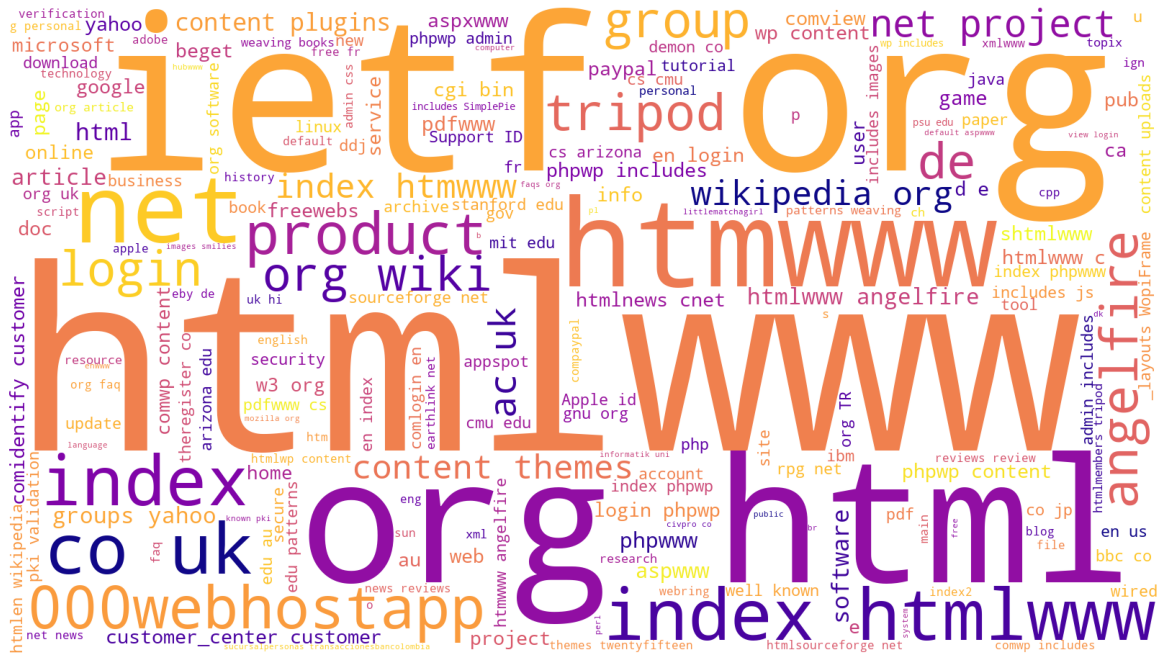

In [27]:

wordcloud = WordCloud(width = 1600, height = 900, 
                background_color ='white', 
                colormap='plasma', 
                min_font_size = 10).generate(all_phishing_dirs) 

# Plot the WordCloud image.                        
plt.figure(figsize = (16, 9), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 
plt.show()

# Export the WordCloud image as a PNG file:
fig.savefig('phish_dirs_wordcloud.png')

In [28]:
# In addition, the top 10 directories/directory combinations are sorted inside a DataFrame to create a top 10
# bar plot:

phishing_dirs_df = pd.DataFrame(phishing_dirs['directories'].value_counts())

phishing_dirs_df.rename(columns={'directories':'count_of_directories'}, inplace=True)

phishing_dirs_df.index.names = ['directories']

phishing_dirs_df.reset_index(inplace=True)

print(phishing_dirs_df)

                                      directories  count_of_directories
0                                                                  2525
1                                              js                   372
2                                          images                   293
3                           login, en, login.html                   255
4                            www.webring.com, hub                   209
...                                           ...                   ...
82687                 paypal-accounts.vivivato.fr                     1
82688            document, file, al, l, lty, dpbx                     1
82689                        view, beh698sqz.html                     1
82690                 bourbonstreetdistillery.com                     1
82691  www.angelfire.com, goth, devilmaycrytonite                     1

[82692 rows x 2 columns]


In [29]:
# The data is subset in order to plot a barplot of the top 10 directories/directory combinations
# used in phishing URLs:

top_10_phish_dir = phishing_dirs_df.head(10)

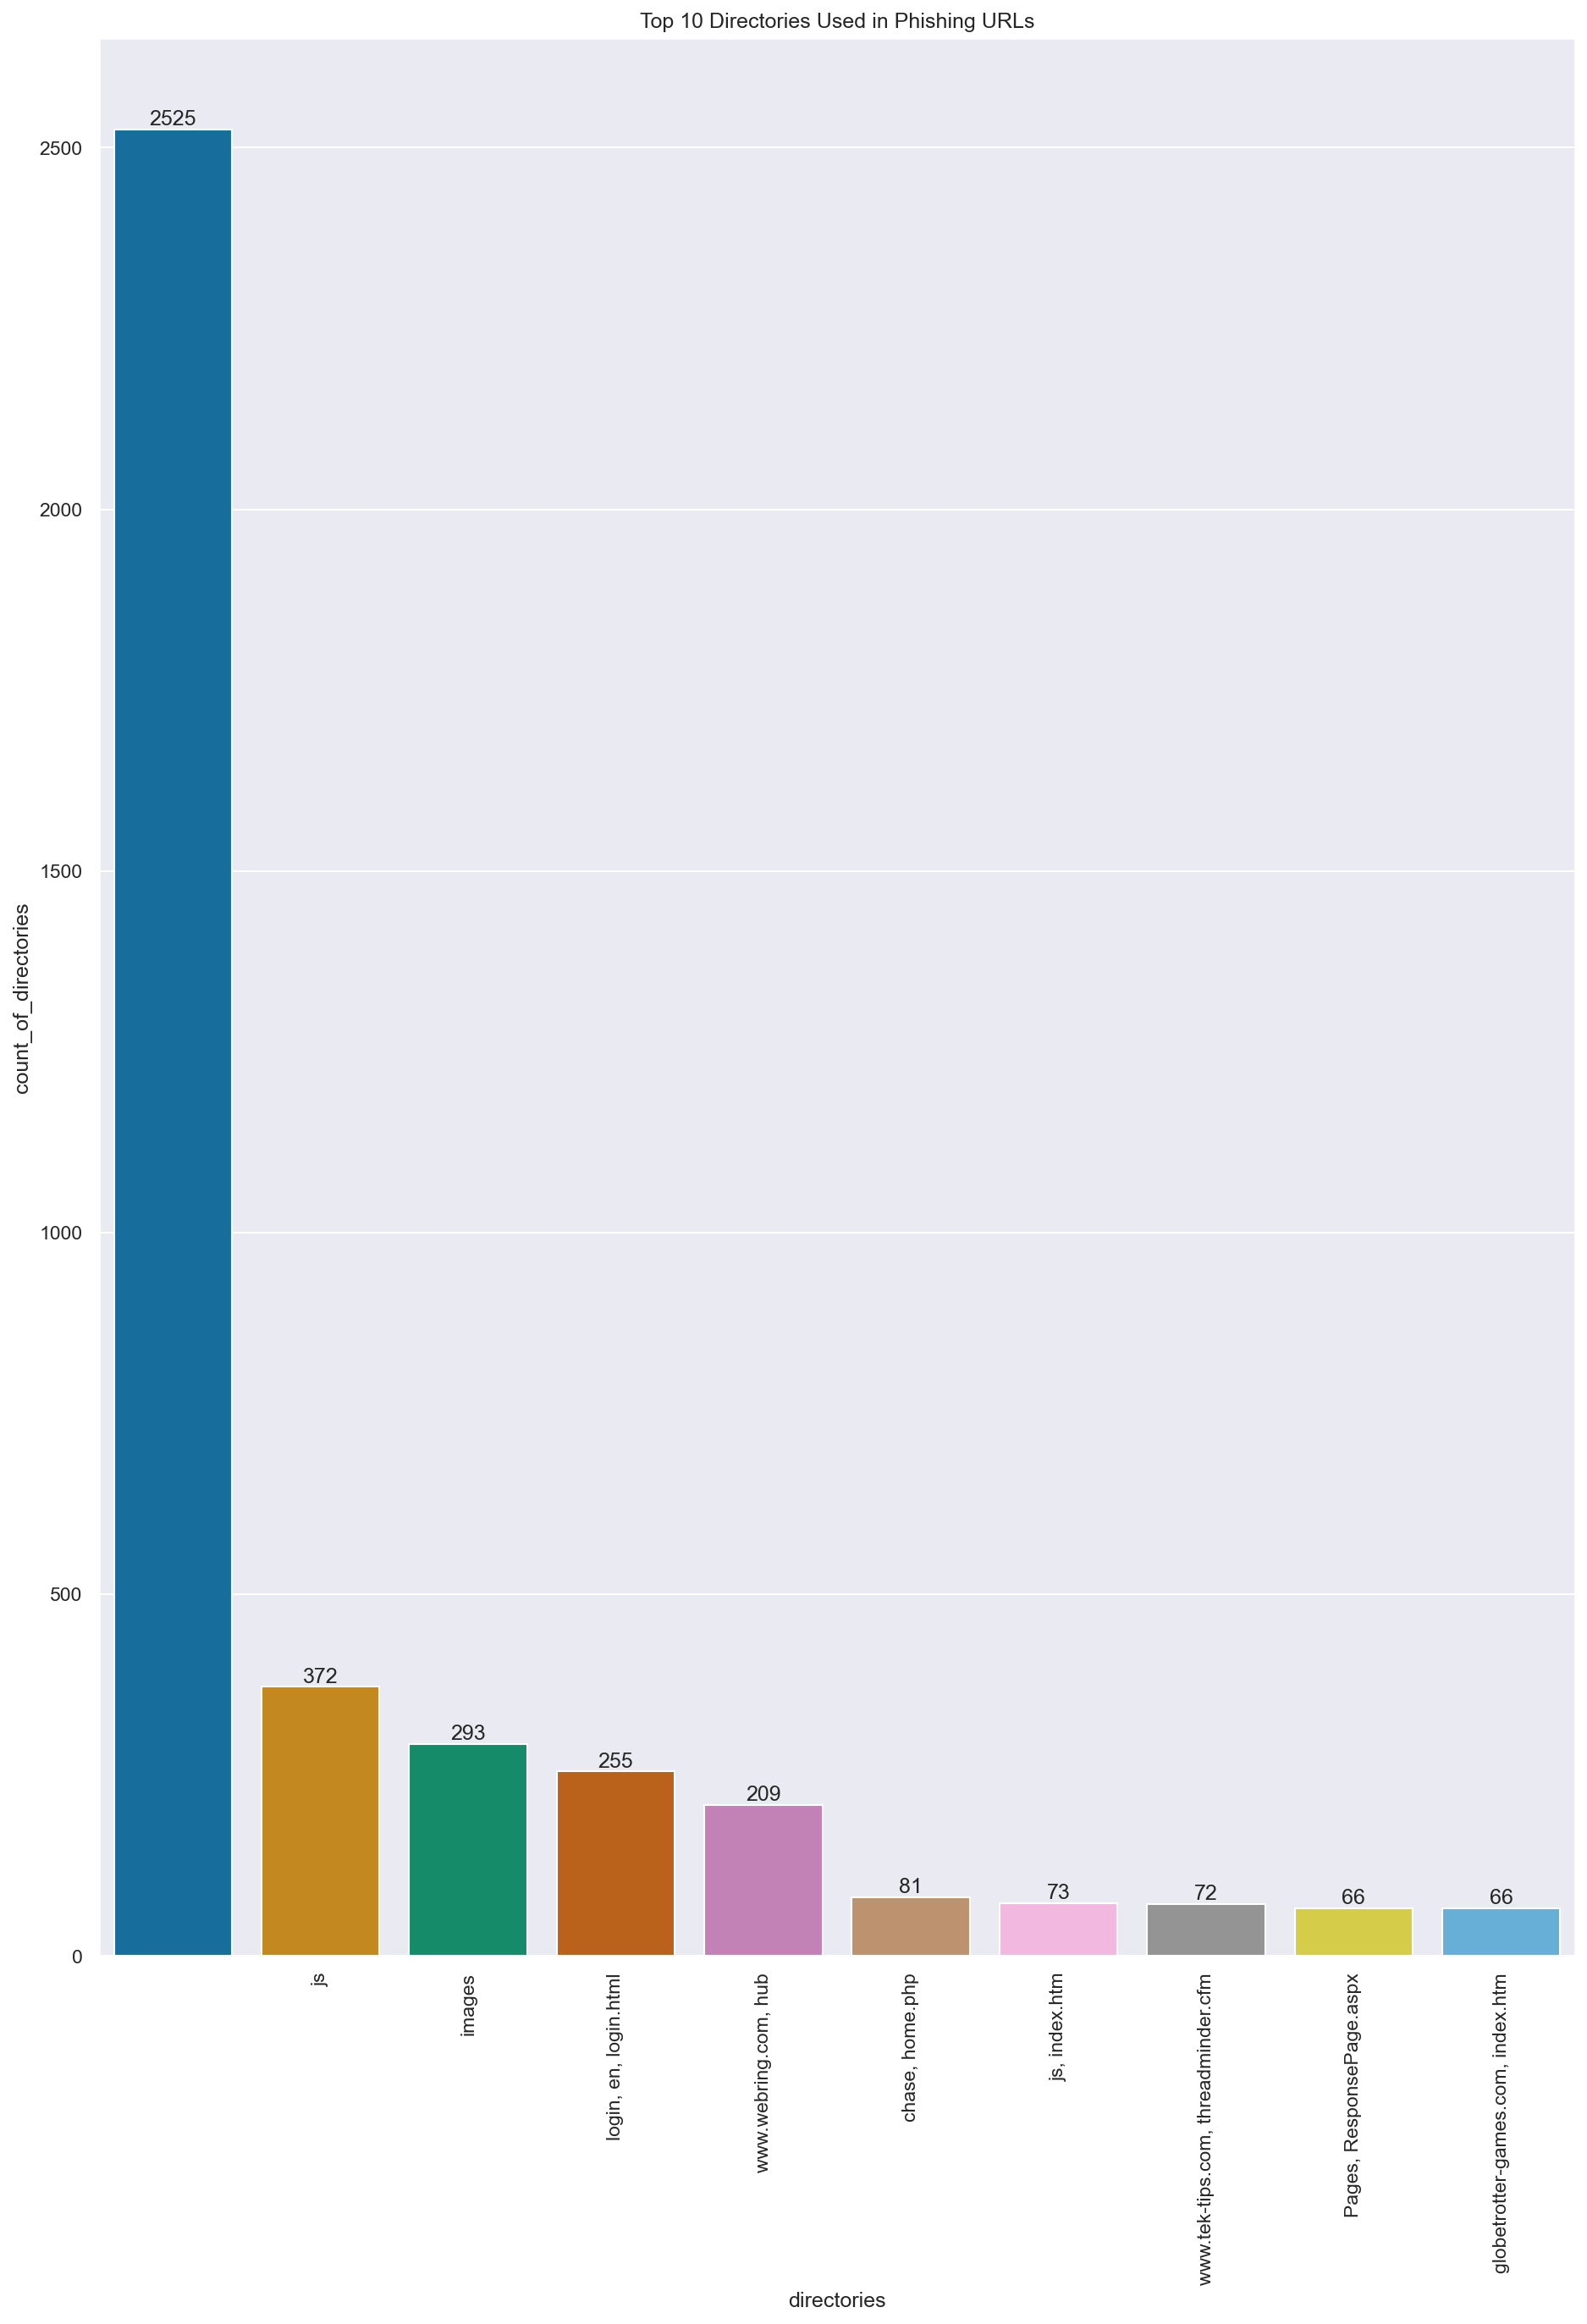

In [30]:
# A barplot is generated:
fig, ax = plt.subplots(dpi=150)

sns.set(rc = {'figure.figsize':(15, 15)})
ax.set_title("Top 10 Directories Used in Phishing URLs")
ax.set_xlabel("Directories")
ax.set_ylabel("Total Times Encountered in Data Set")
plt.xticks(rotation=90)

sns.barplot(x='directories', y='count_of_directories', palette='colorblind', data=top_10_phish_dir)

for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f')

fig.savefig('top_10_phish_dirs.png')

In [31]:
# The same is done with phishing queries:

phishing_qs = phishing_urls['queries'].str[1:-1].reset_index()

phishing_qs['queries'] = phishing_qs['queries'].str.replace(r'\'', '', regex=True)

phishing_qs = pd.DataFrame(phishing_qs['queries'].apply(lambda x: ''.join(map(str, x))))

phishing_qs.dropna().reset_index()
phishing_qs.head()

queries
0                                            
1                                            
2                                            
3  formkey=dGg2Z1lCUHlSdjllTVNRUW50TFIzSkE6MQ
4

In [32]:
# Create a word cloud:
all_phishing_qs = ''

for i in range(phishing_qs.shape[0]):
    # Add each token to the list:
    all_phishing_qs = all_phishing_qs + phishing_qs['queries'][i]

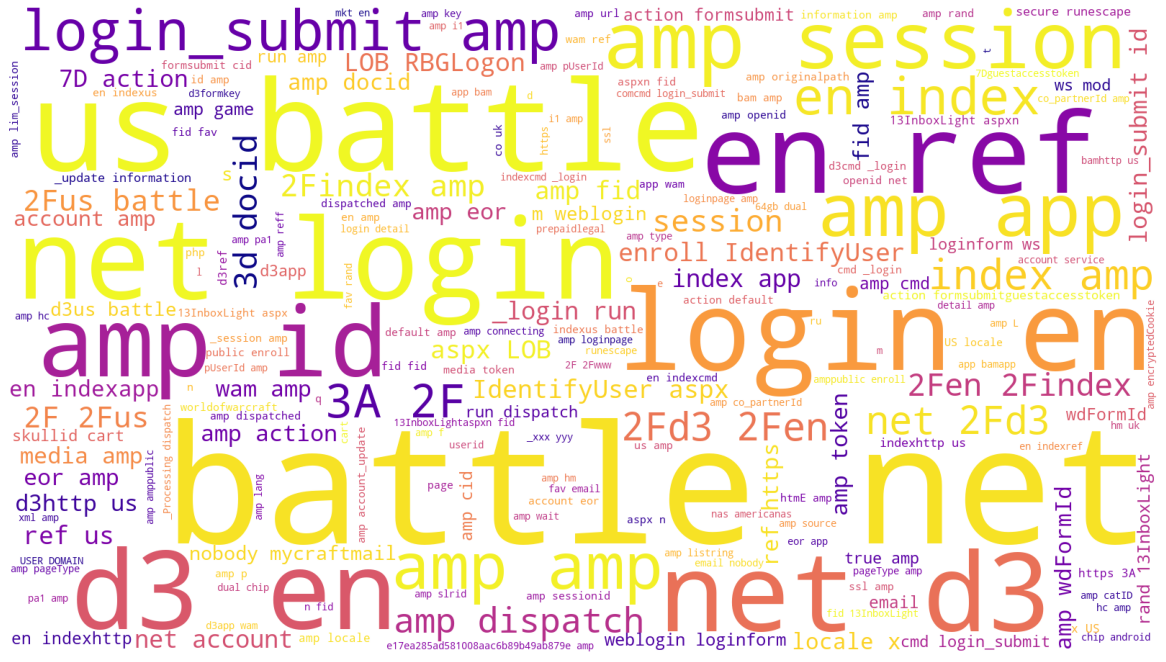

In [33]:
# Create a WordCloud:
wordcloud = WordCloud(width = 1600, height = 900, 
                background_color ='white', 
                colormap='plasma', 
                min_font_size = 10).generate(all_phishing_qs) 

# Plot the WordCloud image:                        
plt.figure(figsize = (16, 9), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 
plt.show()

fig.savefig('phishing_qs_wordcloud.png')

In [34]:
phishing_qs_df = pd.DataFrame(phishing_qs['queries'].value_counts())

phishing_qs_df.rename(columns={'queries':'count_of_queries'}, inplace=True)

phishing_qs_df.index.names = ['queries']

phishing_qs_df.reset_index(inplace=True)

print(phishing_qs_df)

                                                queries  count_of_queries
0                                                                   85963
1     http://us.battle.net/login/en/?ref=http%3A%2F%...                60
2     http://us.battle.net/login/en/?ref=http://us.b...                58
3                                         usp=send_form                55
4                          email=nobody@mycraftmail.com                45
...                                                 ...               ...
6476  alt=media, amp;token=cf2fa933-e1fa-4999-9113-4...                 1
6477  cmd=login_submit, id=5cb133e488282c972434ce27d...                 1
6478  cmd=login_submit, id=10d6ae8756693d6eccb39b6e5...                 1
6479  cmd=_update-information, amp;account_update=e4...                 1
6480                                        cId=3159391                 1

[6481 rows x 2 columns]


In [35]:
top_10_phish_qs = phishing_qs_df.head(10)

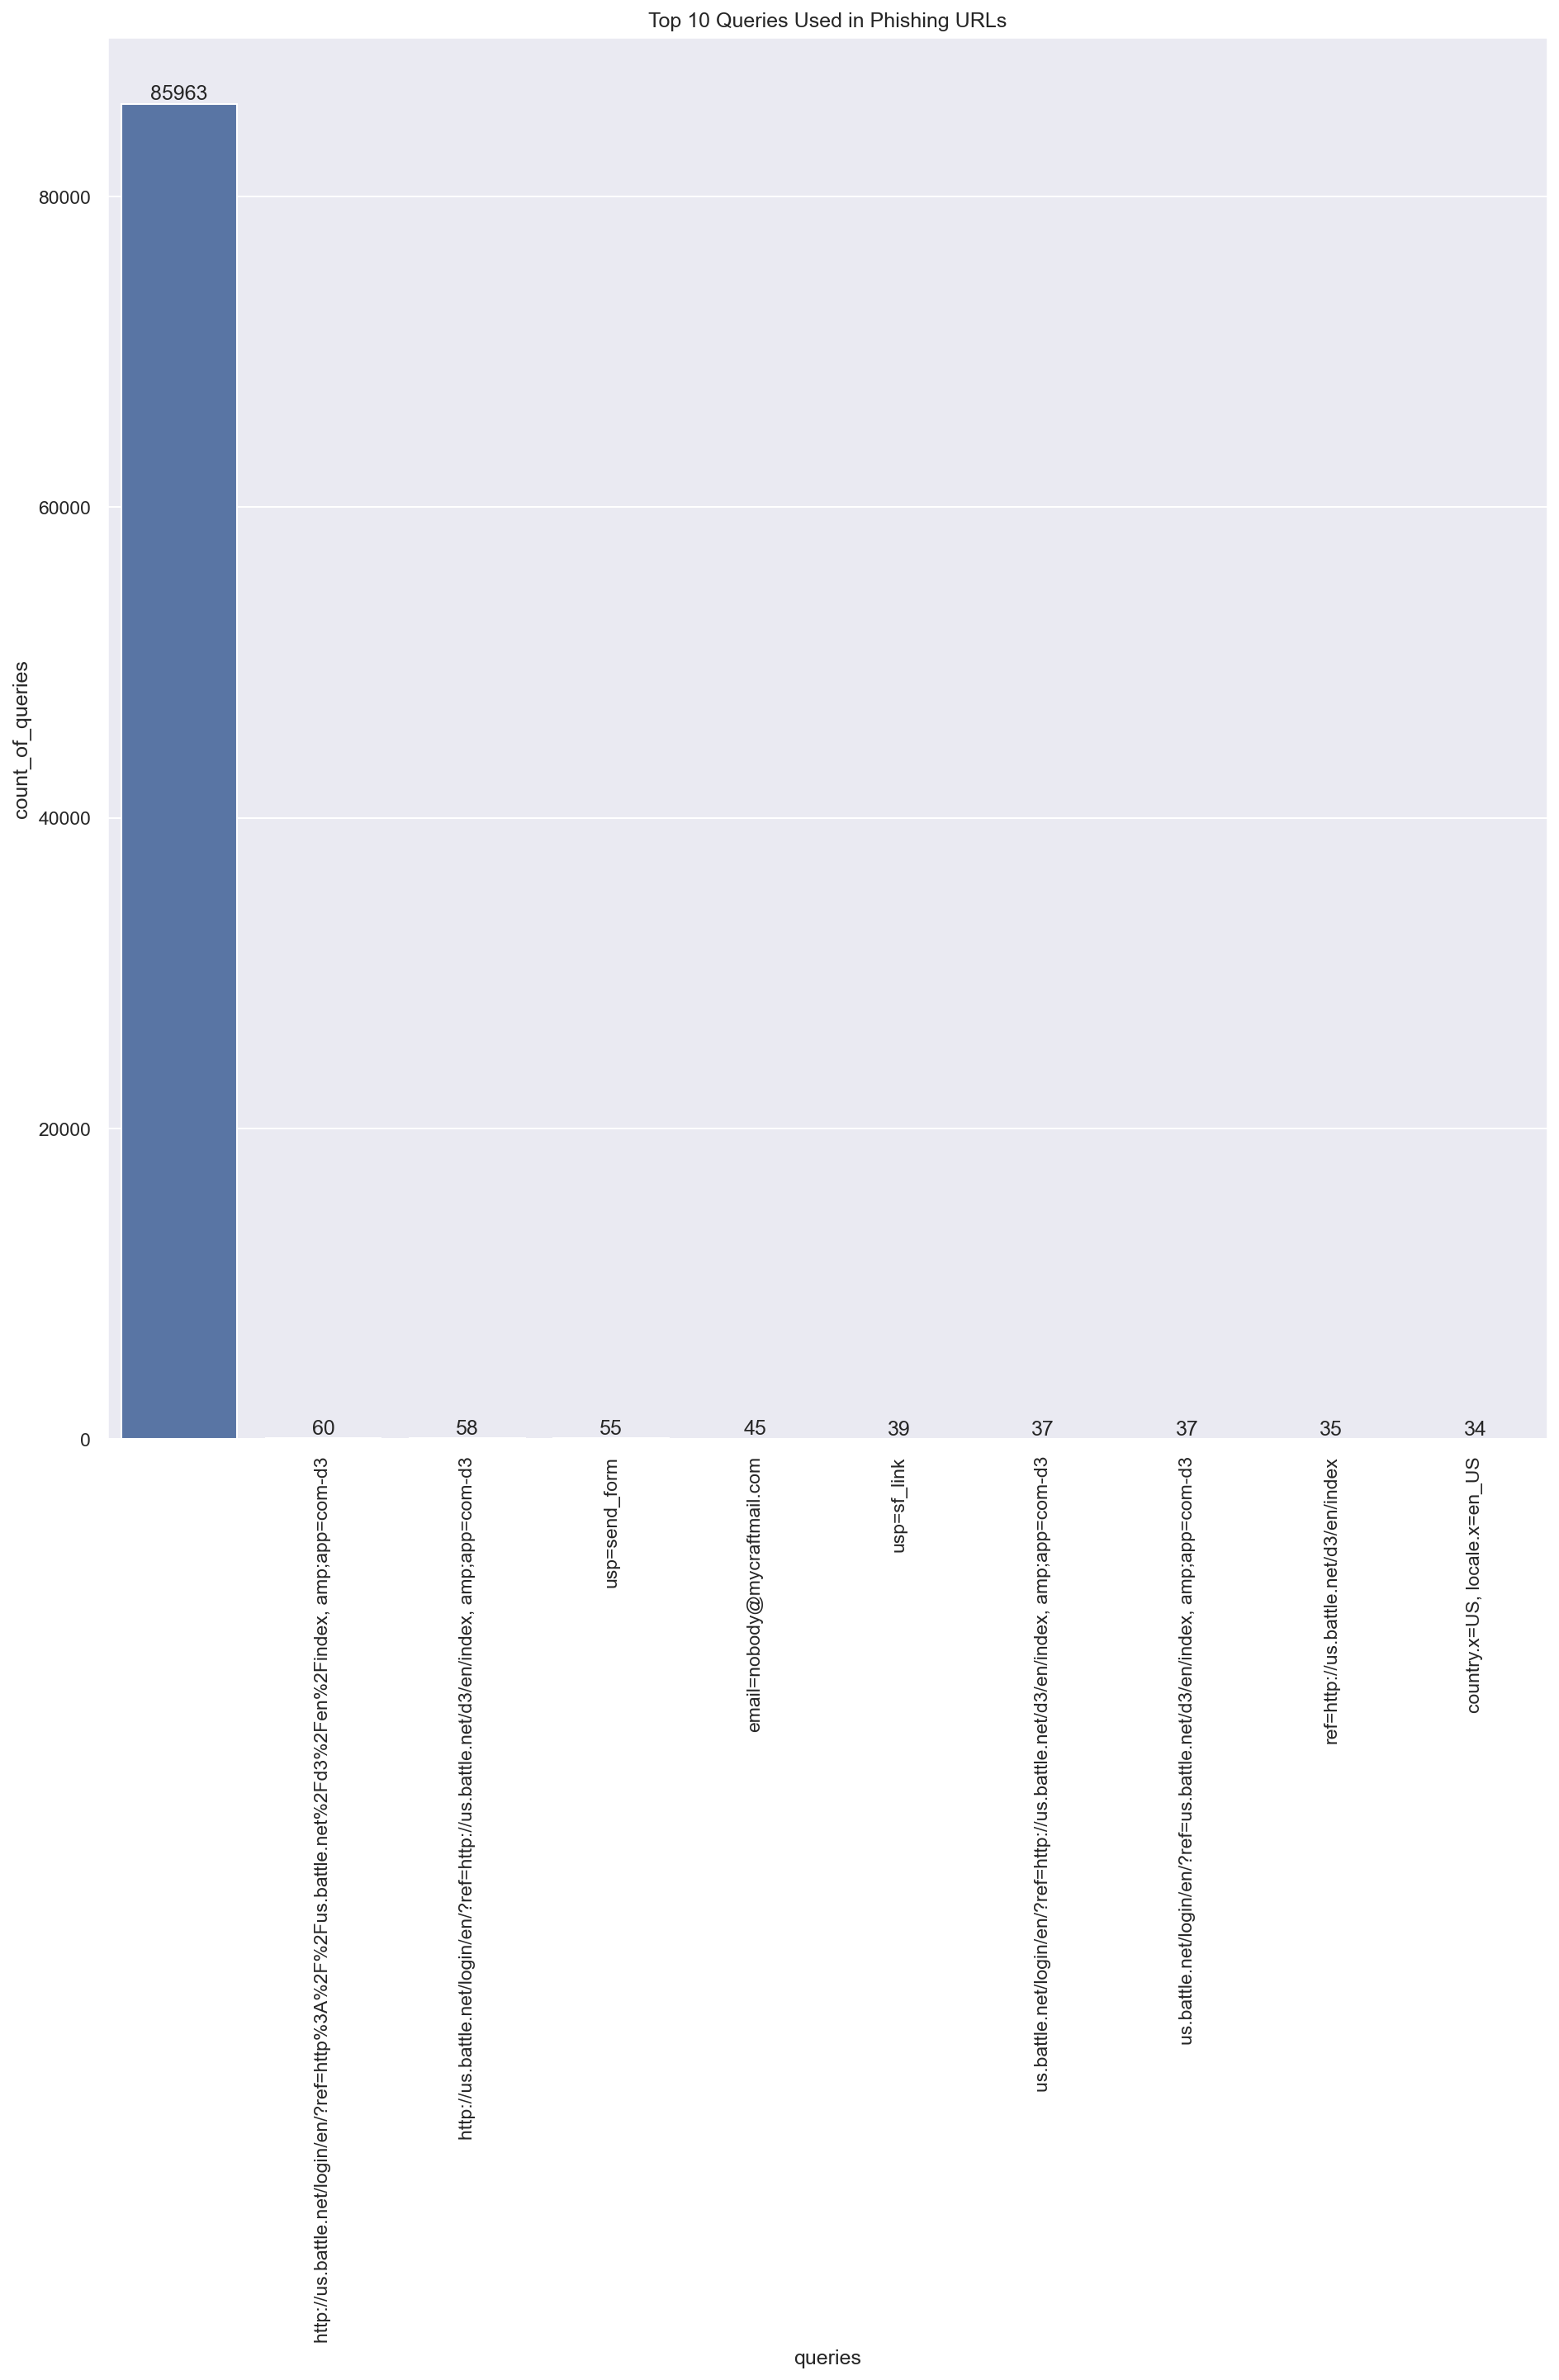

In [36]:
fig, ax = plt.subplots(dpi=150)

sns.set(rc = {'figure.figsize':(15, 15)})
ax.set_title("Top 10 Queries Used in Phishing URLs")
ax.set_xlabel("Queries")
ax.set_ylabel("Total Times Encountered in Data Set")
plt.xticks(rotation=90)

sns.barplot(x='queries', y='count_of_queries', data=top_10_phish_qs)

for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f')

fig.savefig('top_10_phish_qs.png')

In [37]:
# The top phishing URL schemes are identified:

phishing_sch = pd.DataFrame(phishing_urls['scheme'])

phishing_sch['scheme'] = phishing_sch['scheme'].astype('str')

phishing_sch = phishing_sch[phishing_sch['scheme'] != 'nan'].reset_index()

phishing_sch.head()

index scheme
0     28   http
1     40  https
2     87   http
3    106   http
4    139   http

In [38]:
phishing_sch['scheme'].value_counts()

http                               17886
https                               6966
www.mit.edu                            5
ilpubs.stanford.edu                    3
www-vs.informatik.uni-ulm.de           2
www.ripn.net                           2
dbpubs.stanford.edu                    2
ftp                                    2
gopher.quux.org                        2
www.ee.ryerson.ca                      2
crib.lehn.org                          1
omega.albany.edu                       1
www.listhost.net                       1
ww2.ant-nat.com                        1
john.ccac.rwth-aachen.de               1
www.kobrix.com                         1
cullenprogramming.homelinux.com        1
coweb.cc.gatech.edu                    1
www.eleves.ens.fr                      1
hawkwind.cs.toronto.edu                1
Name: scheme, dtype: int64

In [39]:
phishing_sch_df = pd.DataFrame(phishing_sch['scheme'].value_counts())

phishing_sch_df.rename(columns={'scheme':'count_of_scheme'}, inplace=True)

phishing_sch_df.index.names = ['scheme']

phishing_sch_df.reset_index(inplace=True)

print(phishing_sch_df)

                             scheme  count_of_scheme
0                              http            17886
1                             https             6966
2                       www.mit.edu                5
3               ilpubs.stanford.edu                3
4      www-vs.informatik.uni-ulm.de                2
5                      www.ripn.net                2
6               dbpubs.stanford.edu                2
7                               ftp                2
8                   gopher.quux.org                2
9                 www.ee.ryerson.ca                2
10                    crib.lehn.org                1
11                 omega.albany.edu                1
12                 www.listhost.net                1
13                  ww2.ant-nat.com                1
14         john.ccac.rwth-aachen.de                1
15                   www.kobrix.com                1
16  cullenprogramming.homelinux.com                1
17              coweb.cc.gatech.edu           

In [40]:
top_10_phish_sch = phishing_sch_df.head(10)

In [41]:
# The top domains are identified:

phishing_net = pd.DataFrame(phishing_urls['netloc'])

phishing_net['netloc'] = phishing_net['netloc'].astype('str')

phishing_net = phishing_net[phishing_net['netloc'] != 'nan'].reset_index()

phishing_net.head(50)

index                                             netloc
0      28                            marketingbyinternet.com
1      40                                    docs.google.com
2      87                                   martin-busker.de
3     106                                         bimabn.com
4     139                                designeremdoces.com
5     187                       drive-google-com.fanalav.com
6     251                                   smc-images.co.uk
7     408      fb.com.accounts.login.userid.343441.fbsbk.com
8     472                                     icomtec.com.my
9     524                                 naylorantiques.com
10    529                                      pastehtml.com
11    602                                            ksra.ca
12    778                                      lappiramis.hu
13    791                                        hippapi.org
14    795                      habbomoedasgeraa.blogspot.com
15    881  appleid.apple.co.uk.cgi-bin.webobjects.myapple...
16    948                                 naylorantiques.com
17    987                                      pastehtml.com
18    991                                        mikteks.biz
19   1020                                       itfindia.org
20   1159                  us.diablo.net.login.xml.sc-ueo.in
21   1321                       skat-vviztmhc.pepespizza.com
22   1325                                    creditmaster.eu
23   1340                      distrimarsanitarios.soydg.com
24   1431                                      pastehtml.com
25   1527  appleid.apple.co.uk.cgi-bin.webobjects.myapple...
26   1533                                          jjscdc.cn
27   1612                                       netvanduc.vn
28   1721                                     svssonline.com
29   1758                    us.battle.net.d3.loginwowow.com
30   1795  appleid.apple.co.uk.cgi-bin.webobjects.myapple...
31   1851                    enlinea.bbviacontinentallpe.com
32   1892                                   xmadwater.com.cn
33   2075                                      greenranca.ro
34   2328                              bestcontractorsus.com
35   2450  appleid.apple.co.uk.cgi-bin.webobjects.myapple...
36   2472                  us.battle.net.login.en.rrweb.asia
37   2557                                 naylorantiques.com
38   2563                                      pastehtml.com
39   2613                    bank0famerica-com.z2.newmail.ru
40   2661                                         sputnik.ee
41   2678                                          zgytgc.cn
42   2719                             santandr.suupernet.com
43   2741                                       avila.com.br
44   2744                                     youxiji114.com
45   2750                                      pastehtml.com
46   2756                                       rs.qqgo.asia
47   2798                                           in3h.com
48   2829                                       the4fitz.com
49   2890  appleid.apple.co.uk.cgi-bin.webobjects.myapple...

In [42]:
phishing_net_df = pd.DataFrame(phishing_net['netloc'].value_counts())

phishing_net_df.rename(columns={'netloc':'count_of_netloc'}, inplace=True)

phishing_net_df.index.names = ['netloc']

phishing_net_df.reset_index(inplace=True)

print(phishing_net_df)

                                                  netloc  count_of_netloc
0                                          pastehtml.com              944
1                                        docs.google.com              275
2                         firebasestorage.googleapis.com              127
3                                 storage.googleapis.com              116
4                                     naylorantiques.com              114
...                                                  ...              ...
12116                                         kiambu.com                1
12117  appleid.apple.co.uk.cgi-bin.webobjects.myapple...                1
12118                                     208.177.25.180                1
12119                                    rotaoito.com.br                1
12120        creditiperhabbogratissicuro100.blogspot.com                1

[12121 rows x 2 columns]


In [43]:
top_10_phish_net = phishing_net_df.head(10)

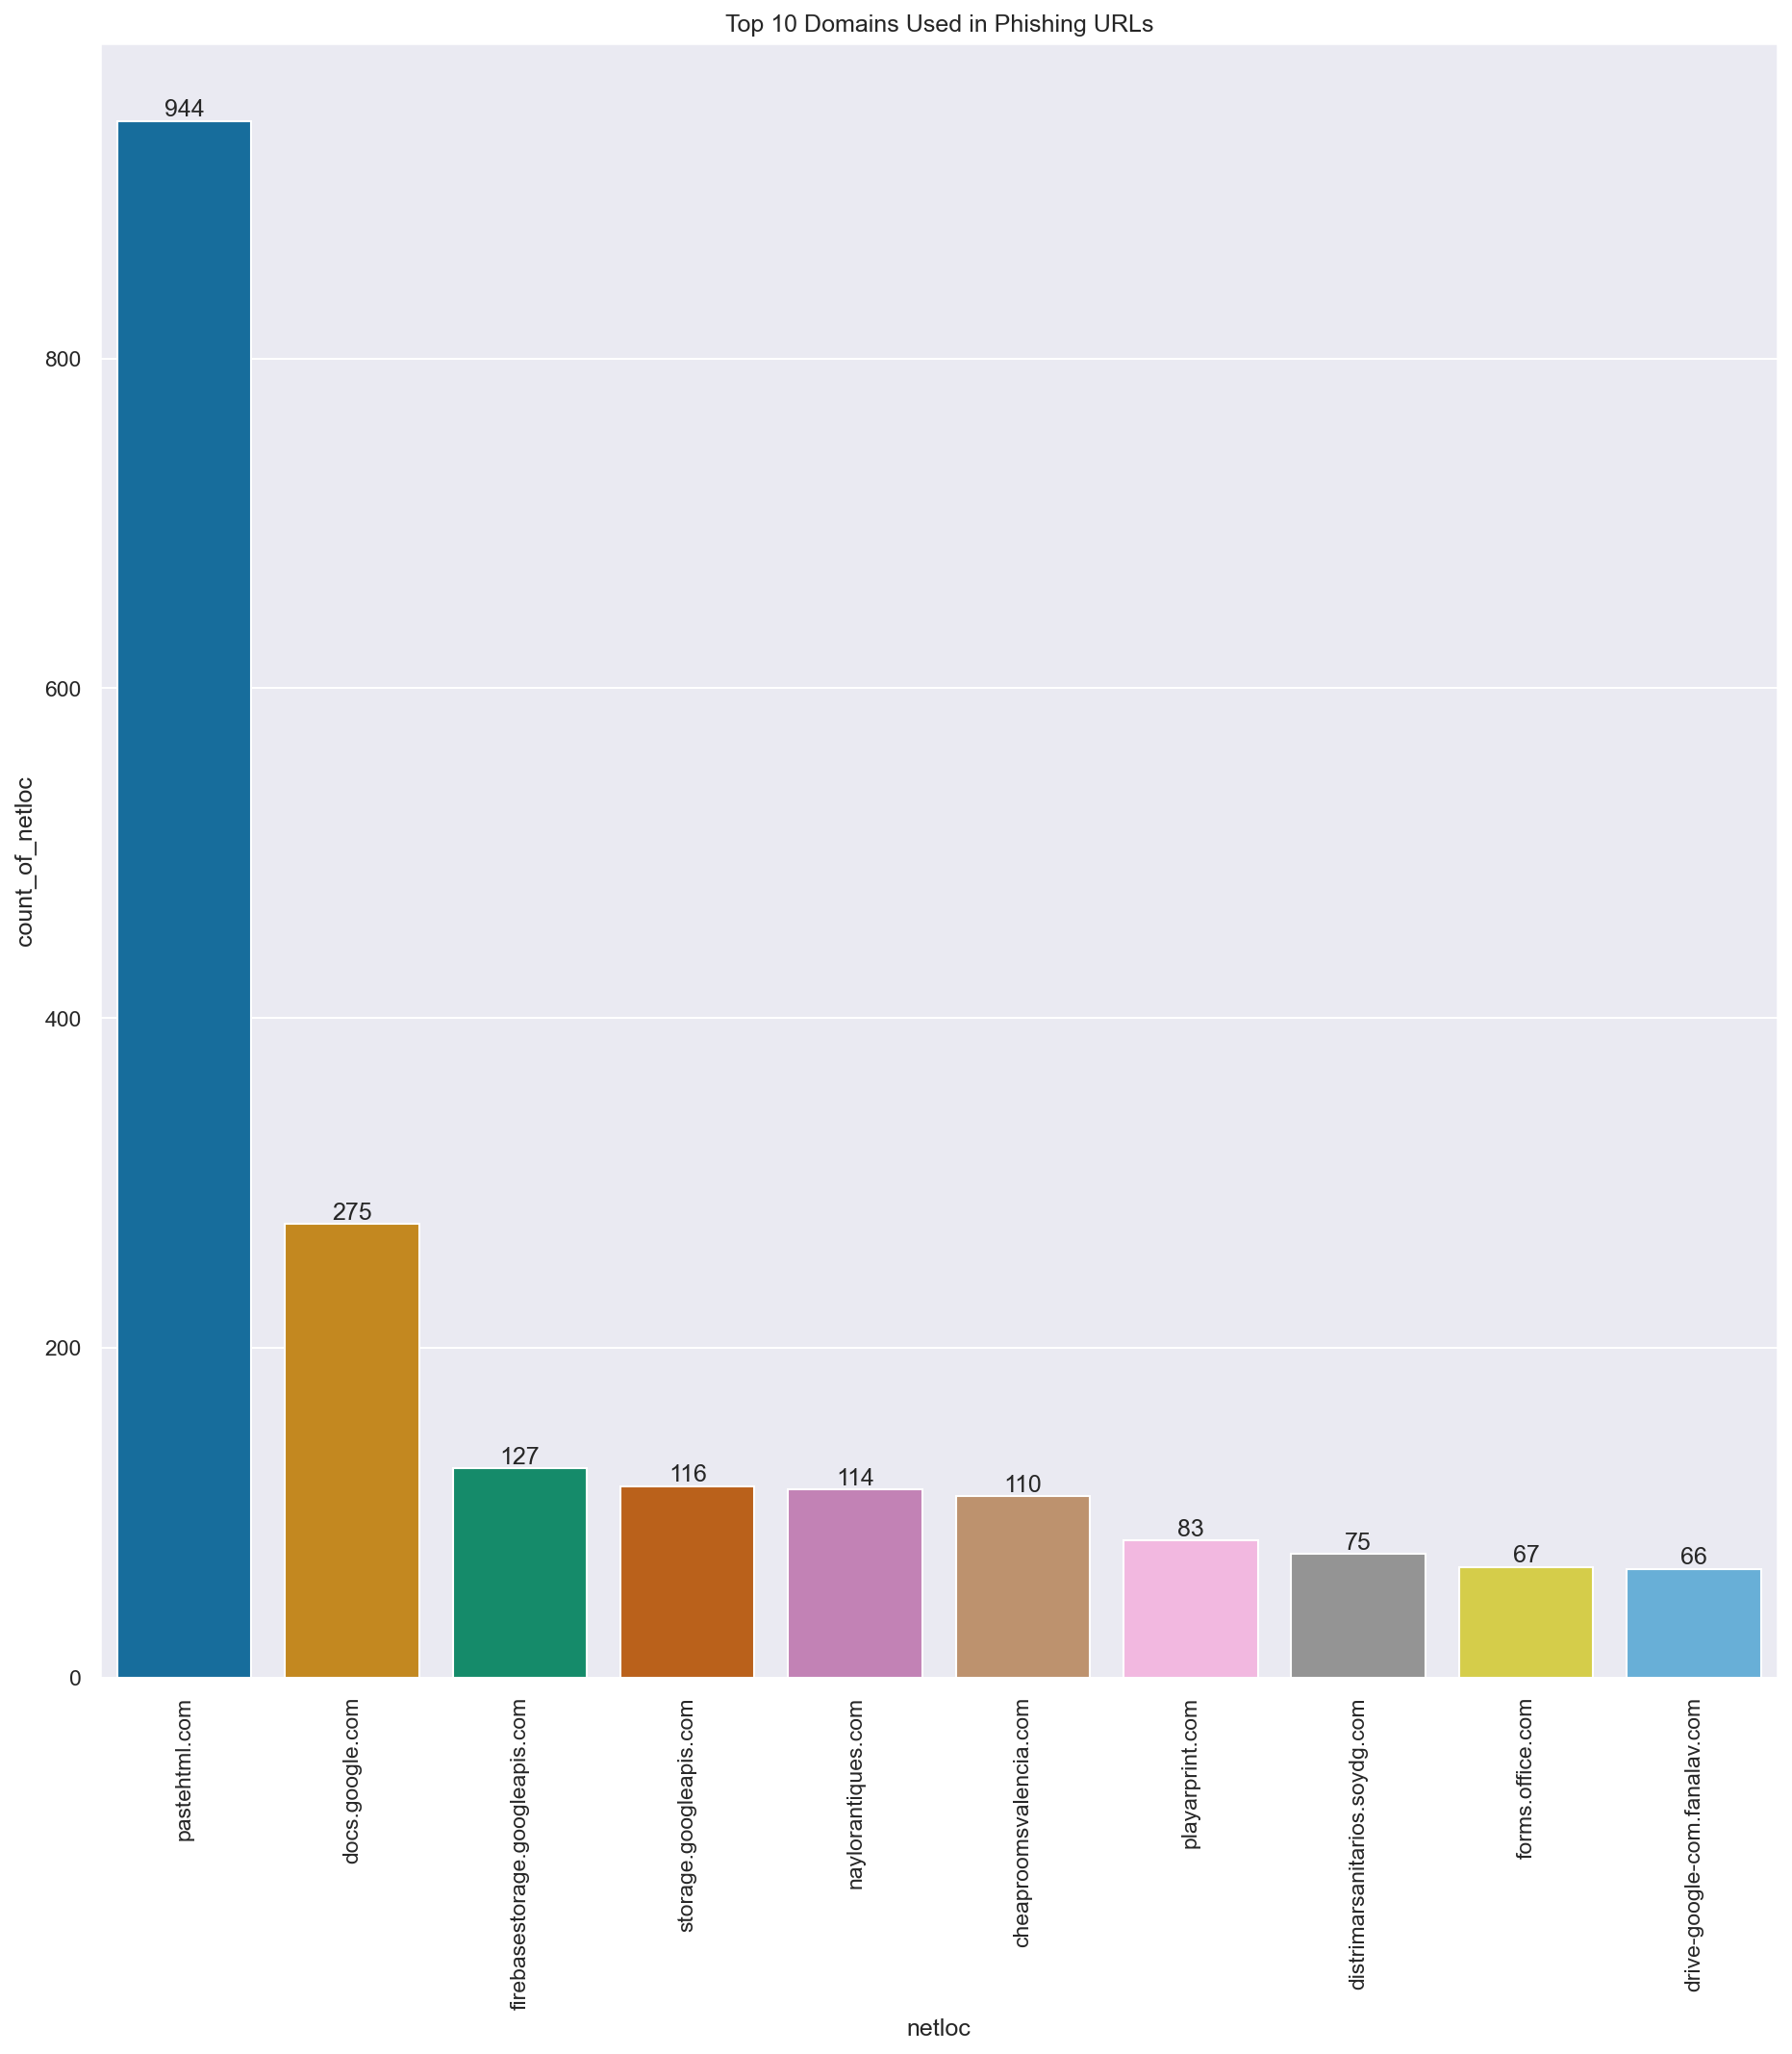

In [44]:
fig, ax = plt.subplots(dpi=150)

sns.set(rc = {'figure.figsize':(15, 15)})
ax.set_title("Top 10 Domains Used in Phishing URLs")
ax.set_xlabel("Domains")
ax.set_ylabel("Total Times Encountered in Data Set")
plt.xticks(rotation=90)

sns.barplot(x='netloc', y='count_of_netloc', palette='colorblind', data=top_10_phish_net)

for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f')

fig.savefig('top_10_phish_net.png')

## Malware URLs

In [45]:
# The same is done for malware URLs, as was done for the phishing URLs:

malware_dirs = malware_urls['directories'].str[1:-1].reset_index()

malware_dirs['directories'] = malware_dirs['directories'].str.replace(r'\'', '', regex=True)

malware_dirs = pd.DataFrame(malware_dirs['directories'].apply(lambda x: ''.join(map(str, x))))


malware_dirs.dropna()
malware_dirs.head(50)

directories
0                        app, member, SportOption.php
1   %E5%84%BF%E7%AB%A5%E7%AB%8B%E4%BD%93%E7%BA%B8%...
2       %E6%A0%91%E5%8F%B6%E7%B2%98%E8%B4%B4%E7%94%BB
3   %E5%8F%A4%E4%BB%A3%E4%BA%8C%E5%8D%81%E5%9B%9B%...
4                                   piccodejs-000.asp
5   %E6%8A%98%E7%BA%B8%E6%89%87%E5%AD%90%E6%8B%BC%...
6                docs, rules, 15022, cn, game_cn.html
7   %E7%AE%80%E5%8D%95%E6%8A%98%E7%BA%B8%E7%B2%98%...
8   %E5%B9%BC%E5%84%BF%E7%B2%BD%E5%8F%B6%E8%B4%B4%...
9   index.php, component, djcatalog2, items, 6-ser...
10  %E4%BA%94%E8%B0%B7%E6%9D%82%E7%B2%AE%E4%BA%BA%...
11  %E6%AF%9B%E7%BA%BF%E8%B4%B4%E7%94%BB%20%E5%9C%...
12                                        trtsport.cz
13   css, detail, mysite, siteconfig, pro_control.css
14  n12, g12, M00, 07, 06, rBEQYVGV9NMIAAAAAAC3mn1...
15  %E6%89%8B%E5%B7%A5%E6%B2%BE%E8%B4%B4%E7%94%BB%...
16               microencapsulation.readmyweather.com
17       tables, payday-loans-direct-lenders-only.php
18                          xo3fhvm5lcvzy92q.download
19       cl, tpl, five-star, ver1, css, five-star.css
20  %E5%B9%BC%E5%84%BF%E5%9B%AD%E7%9A%B1%E7%BA%B9%...
21  images, nocache, vicinio, installers, 20532000...
22                                                 cl
23           2F3F28039730C12A5C112FE0D5FEFA2E.captcha
24         ru-net.cv.ua, wp-content, config, file.php
25                                     proplast.co.nz
26  %E4%BA%94%E8%B0%B7%E6%9D%82%E7%B2%AE%E4%BA%BA%...
27  a, qinpengqipaiguanfangxiazai, 20131019, 263.html
28  %E5%8D%8A%E7%AB%8B%E4%BD%93%E5%B9%BC%E5%84%BF%...
29  %E9%A3%9E%E6%9C%BA%E6%A0%91%E5%8F%B6%E7%B2%98%...
30  %E5%85%AD%E4%B8%80%E5%BF%AB%E4%B9%90%E7%B2%98%...
31  wp-content, themes, simplo, js, jquery-1.4.2.m...
32  2015, 07, 20, cb-otozval-licenziu-y-gelendjik-...
33  %E5%B0%91%E5%84%BF%E7%A7%8D%E5%AD%90%E7%B2%98%...
34  g1, M01, 41, 73, wKhQMVHabJKEHondAAAAAFmPcEE18...
35  %E8%9D%8C%E8%9A%AA%E6%89%BE%E5%A6%88%E5%A6%88%...
36                          community, Web_nMngr.aspx
37                       app, member, SportOption.php
38  wp-content, plugins, gravityforms, css, formsm...
39               docs, rules, 15022, cn, game_cn.html
40  wp-content, themes, NAPA%20AC%202014%20S, gene...
41  xxgl, UploadFiles_7485, 201304, 20130423153801...
42  index.php, rooms, item, all, 18-airticketservices
43  socialsocietyedu.com, components, com_wa, conf...
44  2015, 07, 20, stroitelstvo-energomosta-v-krym-...
45  %E5%84%BF%E7%AB%A5%E5%BD%A9%E7%BA%BF%E8%B4%B4%...
46                                     newscodejs.asp
47  %E5%B9%BC%E5%84%BF%E5%9B%AD%E6%89%8B%E5%B7%A5%...
48                               app, member, cps.php
49                       app, member, SportOption.php

In [46]:
# Label all directory entries that are obfuscated as 1 (entries containing %) and those that are not as 0:
def obfuscated(x):
    """contains obfuscated characters"""
    match = re.search(r'%', x)
    if match: 
        return 1
    else:
        return 0

malware_dirs['obfuscated'] = malware_dirs['directories'].apply(lambda x: obfuscated(x))
                      
malware_dirs.head(50)


directories  obfuscated
0                        app, member, SportOption.php           0
1   %E5%84%BF%E7%AB%A5%E7%AB%8B%E4%BD%93%E7%BA%B8%...           1
2       %E6%A0%91%E5%8F%B6%E7%B2%98%E8%B4%B4%E7%94%BB           1
3   %E5%8F%A4%E4%BB%A3%E4%BA%8C%E5%8D%81%E5%9B%9B%...           1
4                                   piccodejs-000.asp           0
5   %E6%8A%98%E7%BA%B8%E6%89%87%E5%AD%90%E6%8B%BC%...           1
6                docs, rules, 15022, cn, game_cn.html           0
7   %E7%AE%80%E5%8D%95%E6%8A%98%E7%BA%B8%E7%B2%98%...           1
8   %E5%B9%BC%E5%84%BF%E7%B2%BD%E5%8F%B6%E8%B4%B4%...           1
9   index.php, component, djcatalog2, items, 6-ser...           0
10  %E4%BA%94%E8%B0%B7%E6%9D%82%E7%B2%AE%E4%BA%BA%...           1
11  %E6%AF%9B%E7%BA%BF%E8%B4%B4%E7%94%BB%20%E5%9C%...           1
12                                        trtsport.cz           0
13   css, detail, mysite, siteconfig, pro_control.css           0
14  n12, g12, M00, 07, 06, rBEQYVGV9NMIAAAAAAC3mn1...           1
15  %E6%89%8B%E5%B7%A5%E6%B2%BE%E8%B4%B4%E7%94%BB%...           1
16               microencapsulation.readmyweather.com           0
17       tables, payday-loans-direct-lenders-only.php           0
18                          xo3fhvm5lcvzy92q.download           0
19       cl, tpl, five-star, ver1, css, five-star.css           0
20  %E5%B9%BC%E5%84%BF%E5%9B%AD%E7%9A%B1%E7%BA%B9%...           1
21  images, nocache, vicinio, installers, 20532000...           0
22                                                 cl           0
23           2F3F28039730C12A5C112FE0D5FEFA2E.captcha           0
24         ru-net.cv.ua, wp-content, config, file.php           0
25                                     proplast.co.nz           0
26  %E4%BA%94%E8%B0%B7%E6%9D%82%E7%B2%AE%E4%BA%BA%...           1
27  a, qinpengqipaiguanfangxiazai, 20131019, 263.html           0
28  %E5%8D%8A%E7%AB%8B%E4%BD%93%E5%B9%BC%E5%84%BF%...           1
29  %E9%A3%9E%E6%9C%BA%E6%A0%91%E5%8F%B6%E7%B2%98%...           1
30  %E5%85%AD%E4%B8%80%E5%BF%AB%E4%B9%90%E7%B2%98%...           1
31  wp-content, themes, simplo, js, jquery-1.4.2.m...           0
32  2015, 07, 20, cb-otozval-licenziu-y-gelendjik-...           0
33  %E5%B0%91%E5%84%BF%E7%A7%8D%E5%AD%90%E7%B2%98%...           1
34  g1, M01, 41, 73, wKhQMVHabJKEHondAAAAAFmPcEE18...           0
35  %E8%9D%8C%E8%9A%AA%E6%89%BE%E5%A6%88%E5%A6%88%...           1
36                          community, Web_nMngr.aspx           0
37                       app, member, SportOption.php           0
38  wp-content, plugins, gravityforms, css, formsm...           0
39               docs, rules, 15022, cn, game_cn.html           0
40  wp-content, themes, NAPA%20AC%202014%20S, gene...           1
41  xxgl, UploadFiles_7485, 201304, 20130423153801...           0
42  index.php, rooms, item, all, 18-airticketservices           0
43  socialsocietyedu.com, components, com_wa, conf...           0
44  2015, 07, 20, stroitelstvo-energomosta-v-krym-...           0
45  %E5%84%BF%E7%AB%A5%E5%BD%A9%E7%BA%BF%E8%B4%B4%...           1
46                                     newscodejs.asp           0
47  %E5%B9%BC%E5%84%BF%E5%9B%AD%E6%89%8B%E5%B7%A5%...           1
48                               app, member, cps.php           0
49                       app, member, SportOption.php           0

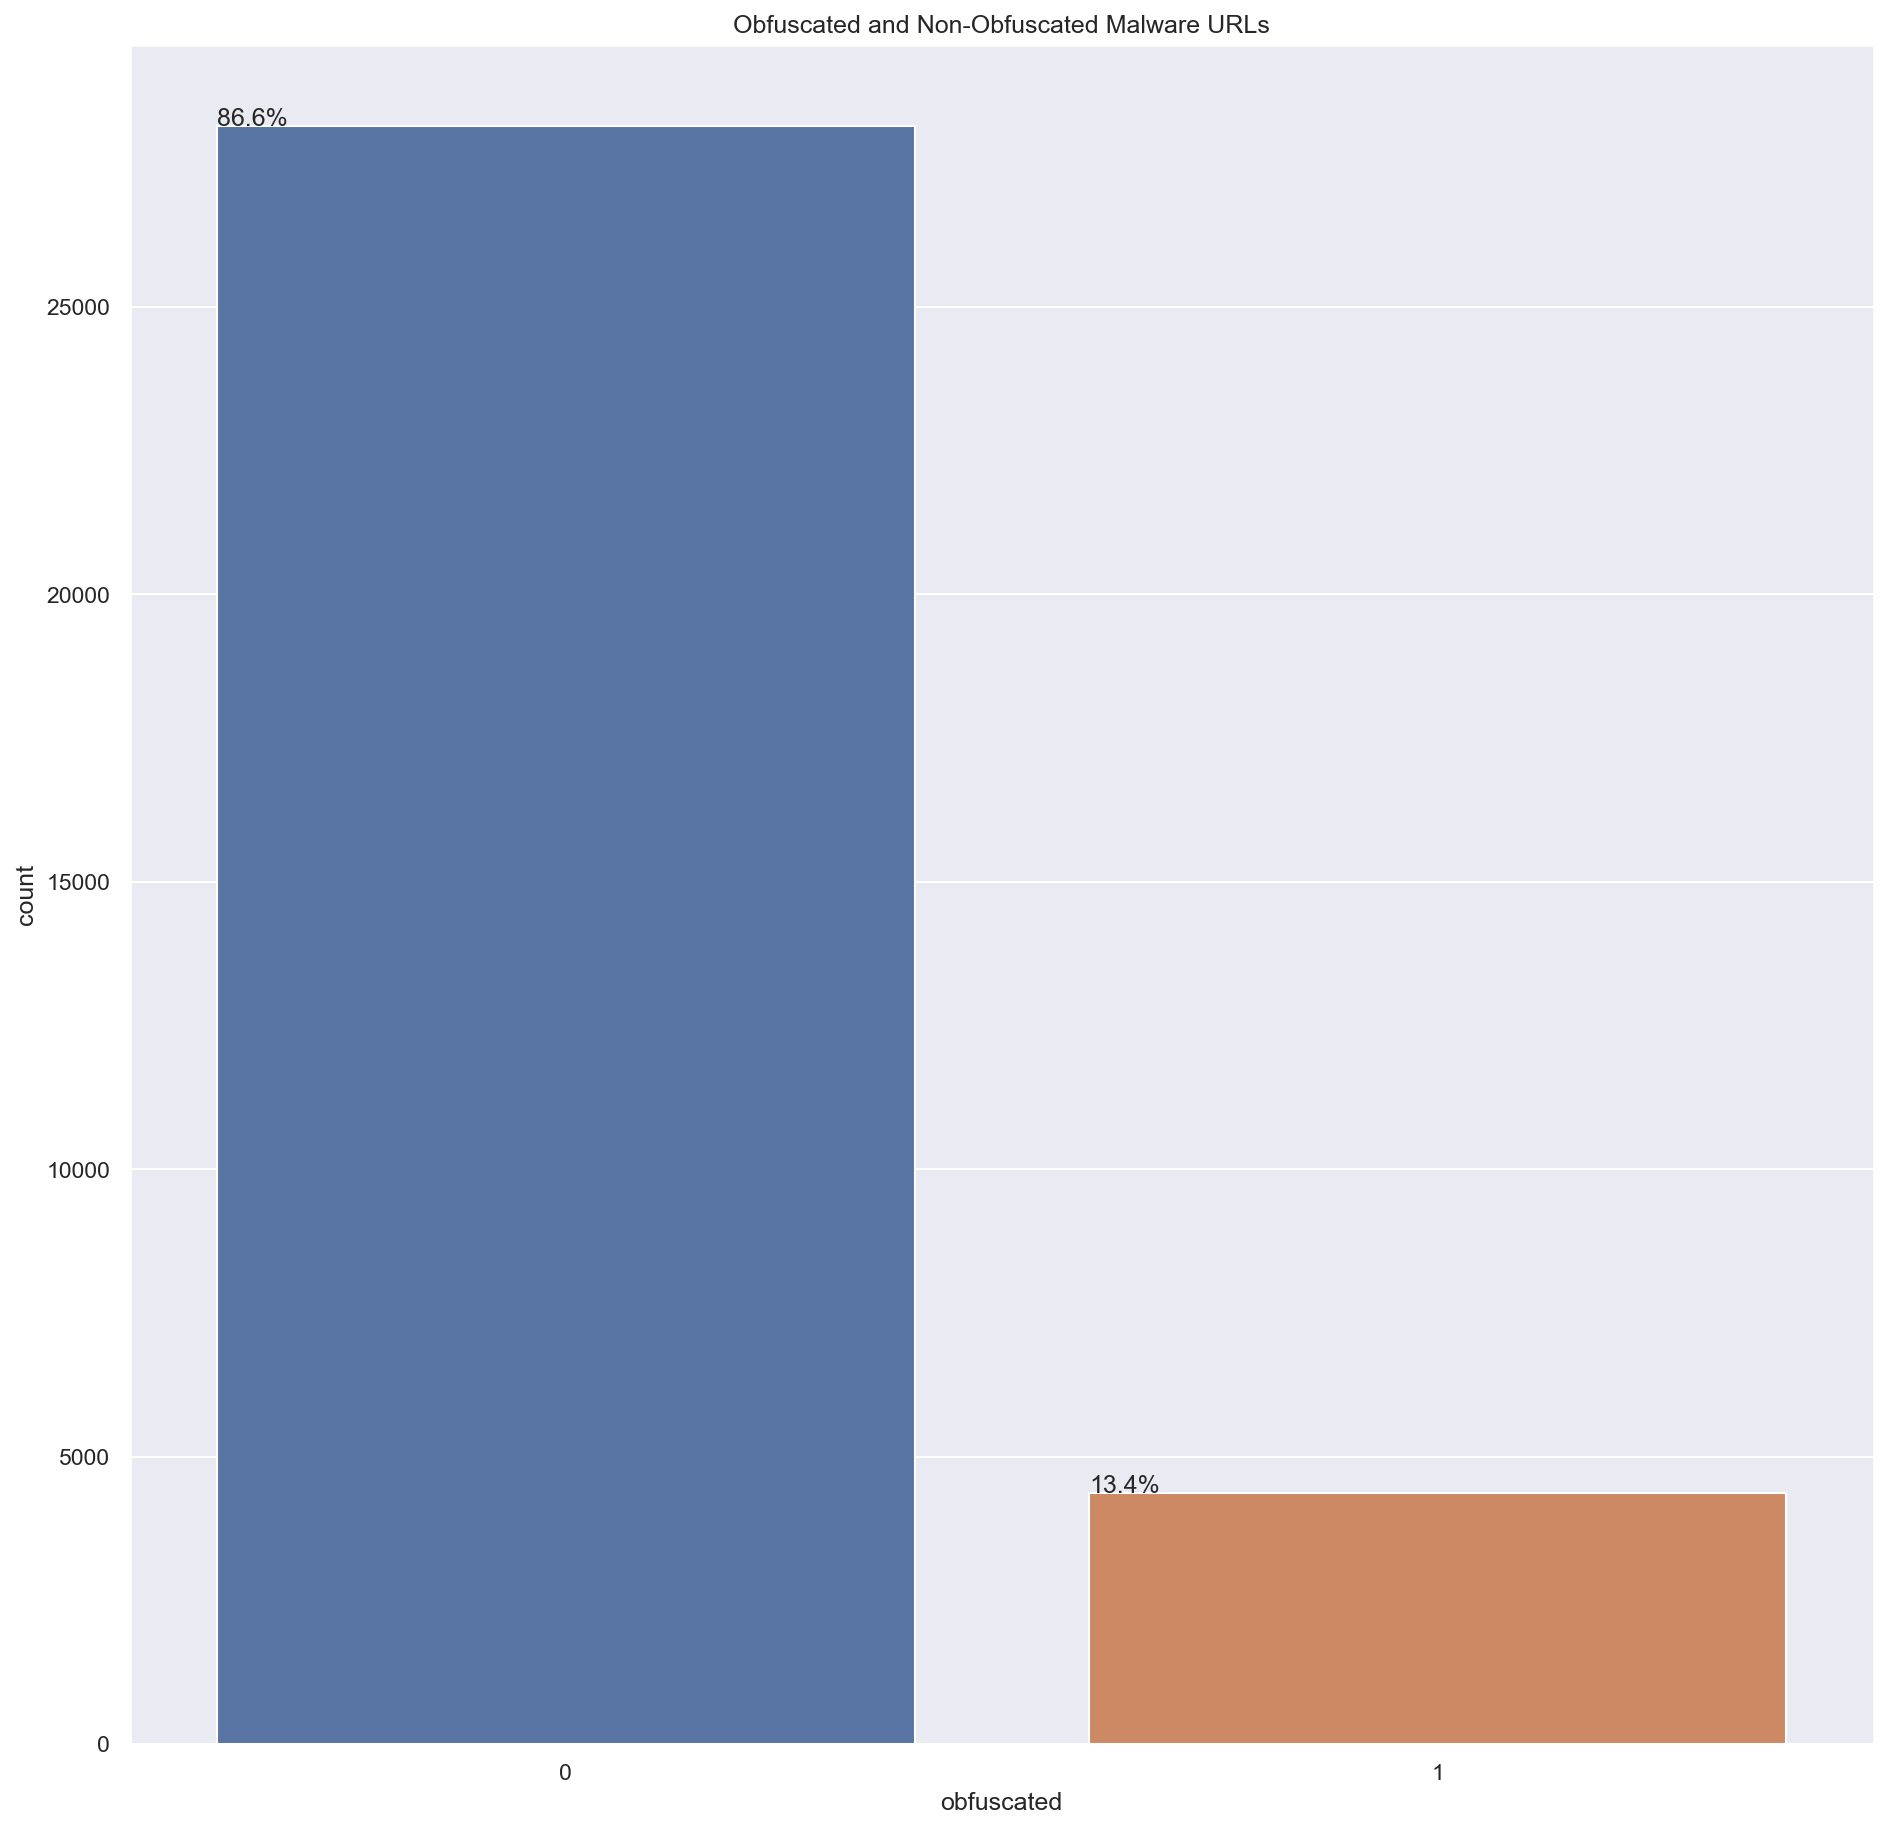

In [47]:
# Countplot to see how many are obfuscated:

fig, ax = plt.subplots(dpi=150)

sns.set(rc = {'figure.figsize':(15, 40)})
sns.set_style('darkgrid')
ax.set_title("Obfuscated and Non-Obfuscated Malware URLs")
ax.set_xlabel("Obfuscated (1) and Non-Obfuscated(1)")
ax.set_ylabel("Total URLs")

sns.countplot(x='obfuscated', data=malware_dirs)

# Labels showing the count of each bar are added to the chart.
total_obfs = len(malware_dirs)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total_obfs)
    x = p.get_x()
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y))

fig.savefig('obfuscated_malware_countplot.png')

In [48]:
malware_non_obfuscated = malware_dirs[malware_dirs['obfuscated'] == 0 ].reset_index()

malware_non_obfuscated.head()

index                                        directories  obfuscated
0      0                       app, member, SportOption.php           0
1      4                                  piccodejs-000.asp           0
2      6               docs, rules, 15022, cn, game_cn.html           0
3      9  index.php, component, djcatalog2, items, 6-ser...           0
4     12                                        trtsport.cz           0

In [49]:
# Malware directories: Create a word cloud of all non-obfuscated URLs:
all_malware_dirs = ''

for i in range(malware_non_obfuscated.shape[0]):
    # Add each token to the list.
    all_malware_dirs = all_malware_dirs + (malware_non_obfuscated['directories'][i])

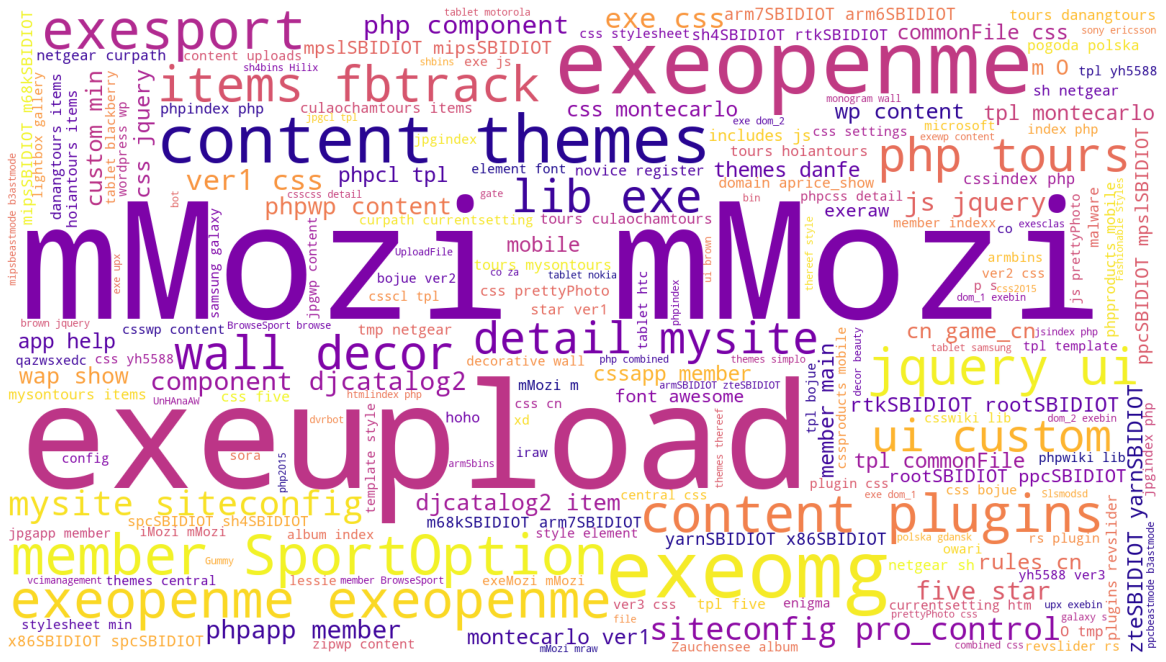

In [50]:
# Create a WordCloud.

wordcloud = WordCloud(width = 1600, height = 900, 
                background_color ='white', 
                colormap='plasma', 
                min_font_size = 10).generate(all_malware_dirs)

# Plot the WordCloud image.                        
plt.figure(figsize = (16, 9), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 
plt.show()

fig.savefig('malware_dirs_wordcloud.png')

In [51]:
malware_dirs_df = pd.DataFrame(malware_non_obfuscated['directories'].value_counts())

malware_dirs_df.rename(columns={'directories':'count_of_directories'}, inplace=True)

malware_dirs_df.index.names = ['directories']

malware_dirs_df.reset_index(inplace=True)

print(malware_dirs_df)

                        directories  count_of_directories
0                            Mozi.m                  4100
1                                .i                   553
2                         index.php                   385
3      app, member, SportOption.php                   288
4                          download                   285
...                             ...                   ...
11800                 raw, 9cwsxpWQ                     1
11801                 raw, 4GVU6r5t                     1
11802                     c, mipsel                     1
11803                    c, aarch64                     1
11804                     putty.exe                     1

[11805 rows x 2 columns]


In [52]:
top_10_malware_dirs = malware_dirs_df.head(10)

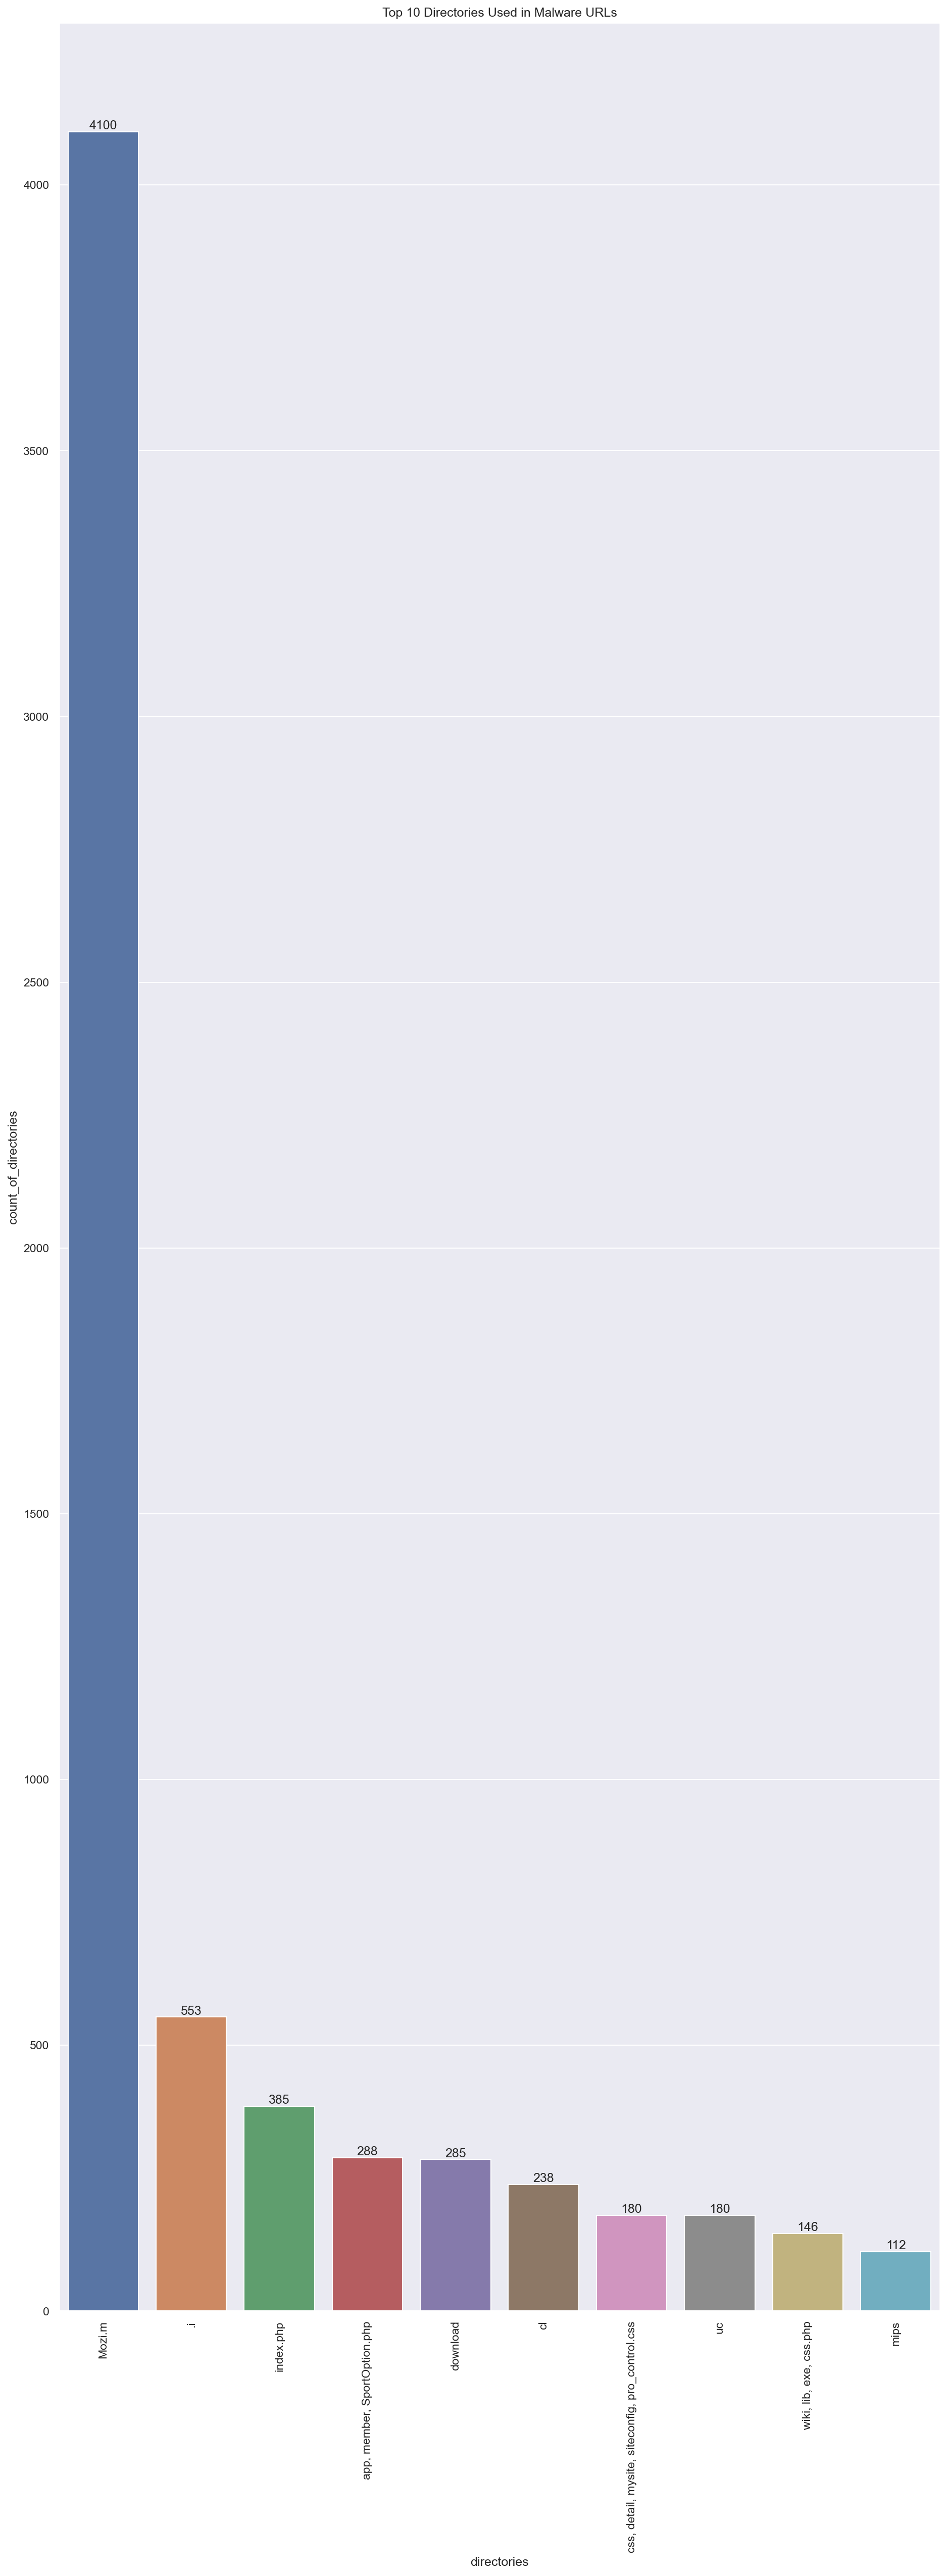

In [53]:
fig, ax = plt.subplots(dpi=150)

sns.set(rc = {'figure.figsize':(15, 15)})
ax.set_title("Top 10 Directories Used in Malware URLs")
ax.set_xlabel("Directories")
ax.set_ylabel("Total Times Encountered in Data Set")
plt.xticks(rotation=90)

sns.barplot(x='directories', y='count_of_directories', data=top_10_malware_dirs)

for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f')

fig.savefig('top_10_malware_dirs.png')

In [54]:
malware_qs = malware_urls['queries'].str[1:-1].reset_index()

malware_qs['queries'] = malware_qs['queries'].str.replace(r'\'', '', regex=True)

malware_qs = pd.DataFrame(malware_qs['queries'].apply(lambda x: ''.join(map(str, x))))

malware_qs.dropna().reset_index()
malware_qs.head()

queries
0                                uid=guest, langx=gb
1                                                   
2                                                   
3                                                   
4  lm2=191, x=3, y=2, w=90, h=63, open=1, n=10, tj=0

In [55]:
# Create a word cloud.
all_malware_qs = ''

for i in range(malware_qs.shape[0]):
    # Add each token to the list.
    all_malware_qs = all_malware_qs + malware_qs['queries'][i]

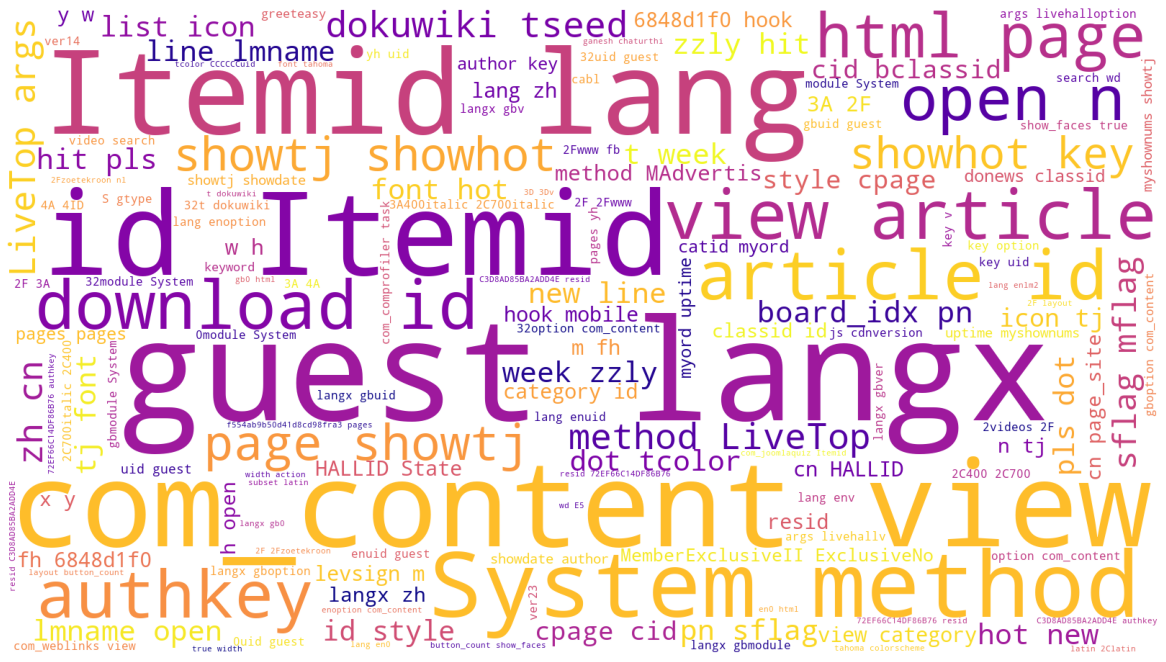

In [56]:
# Create a WordCloud.
wordcloud = WordCloud(width = 1600, height = 900, 
                background_color ='white', 
                colormap='plasma', 
                min_font_size = 10).generate(all_malware_qs) 

# Plot the WordCloud image.                        
plt.figure(figsize = (16, 9), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 
plt.show()

fig.savefig('malware_qs_wordcloud.png')

In [57]:
malware_qs_df = pd.DataFrame(malware_qs['queries'].value_counts())

malware_qs_df.rename(columns={'queries':'count_of_queries'}, inplace=True)

malware_qs_df.index.names = ['queries']

malware_qs_df.reset_index(inplace=True)

print(malware_qs_df)

                                                queries  count_of_queries
0                                                                   28398
1                                   uid=guest, langx=gb               288
2          module=System, method=LiveTop, args=livehall               148
3     t=dokuwiki, tseed=f1f16e8c6142fab8553f2b9cfe04...               146
4                                      amluMjAxNQ%3D%3D                82
...                                                 ...               ...
1111  cid=F75D6B103B974E4C, resid=F75D6B103B974E4C!1...                 1
1112  cid=E4B1E1072DC91F5C, resid=E4B1E1072DC91F5C!5...                 1
1113  cid=CBFA5209EB41ABF2, resid=CBFA5209EB41ABF2!1...                 1
1114  cid=A023FE2D1AC611F2, resid=A023FE2D1AC611F2!4...                 1
1115  cid=0D59C202E35694C2, resid=D59C202E35694C2%21...                 1

[1116 rows x 2 columns]


In [58]:
top_10_malware_qs = malware_qs_df.head(10)

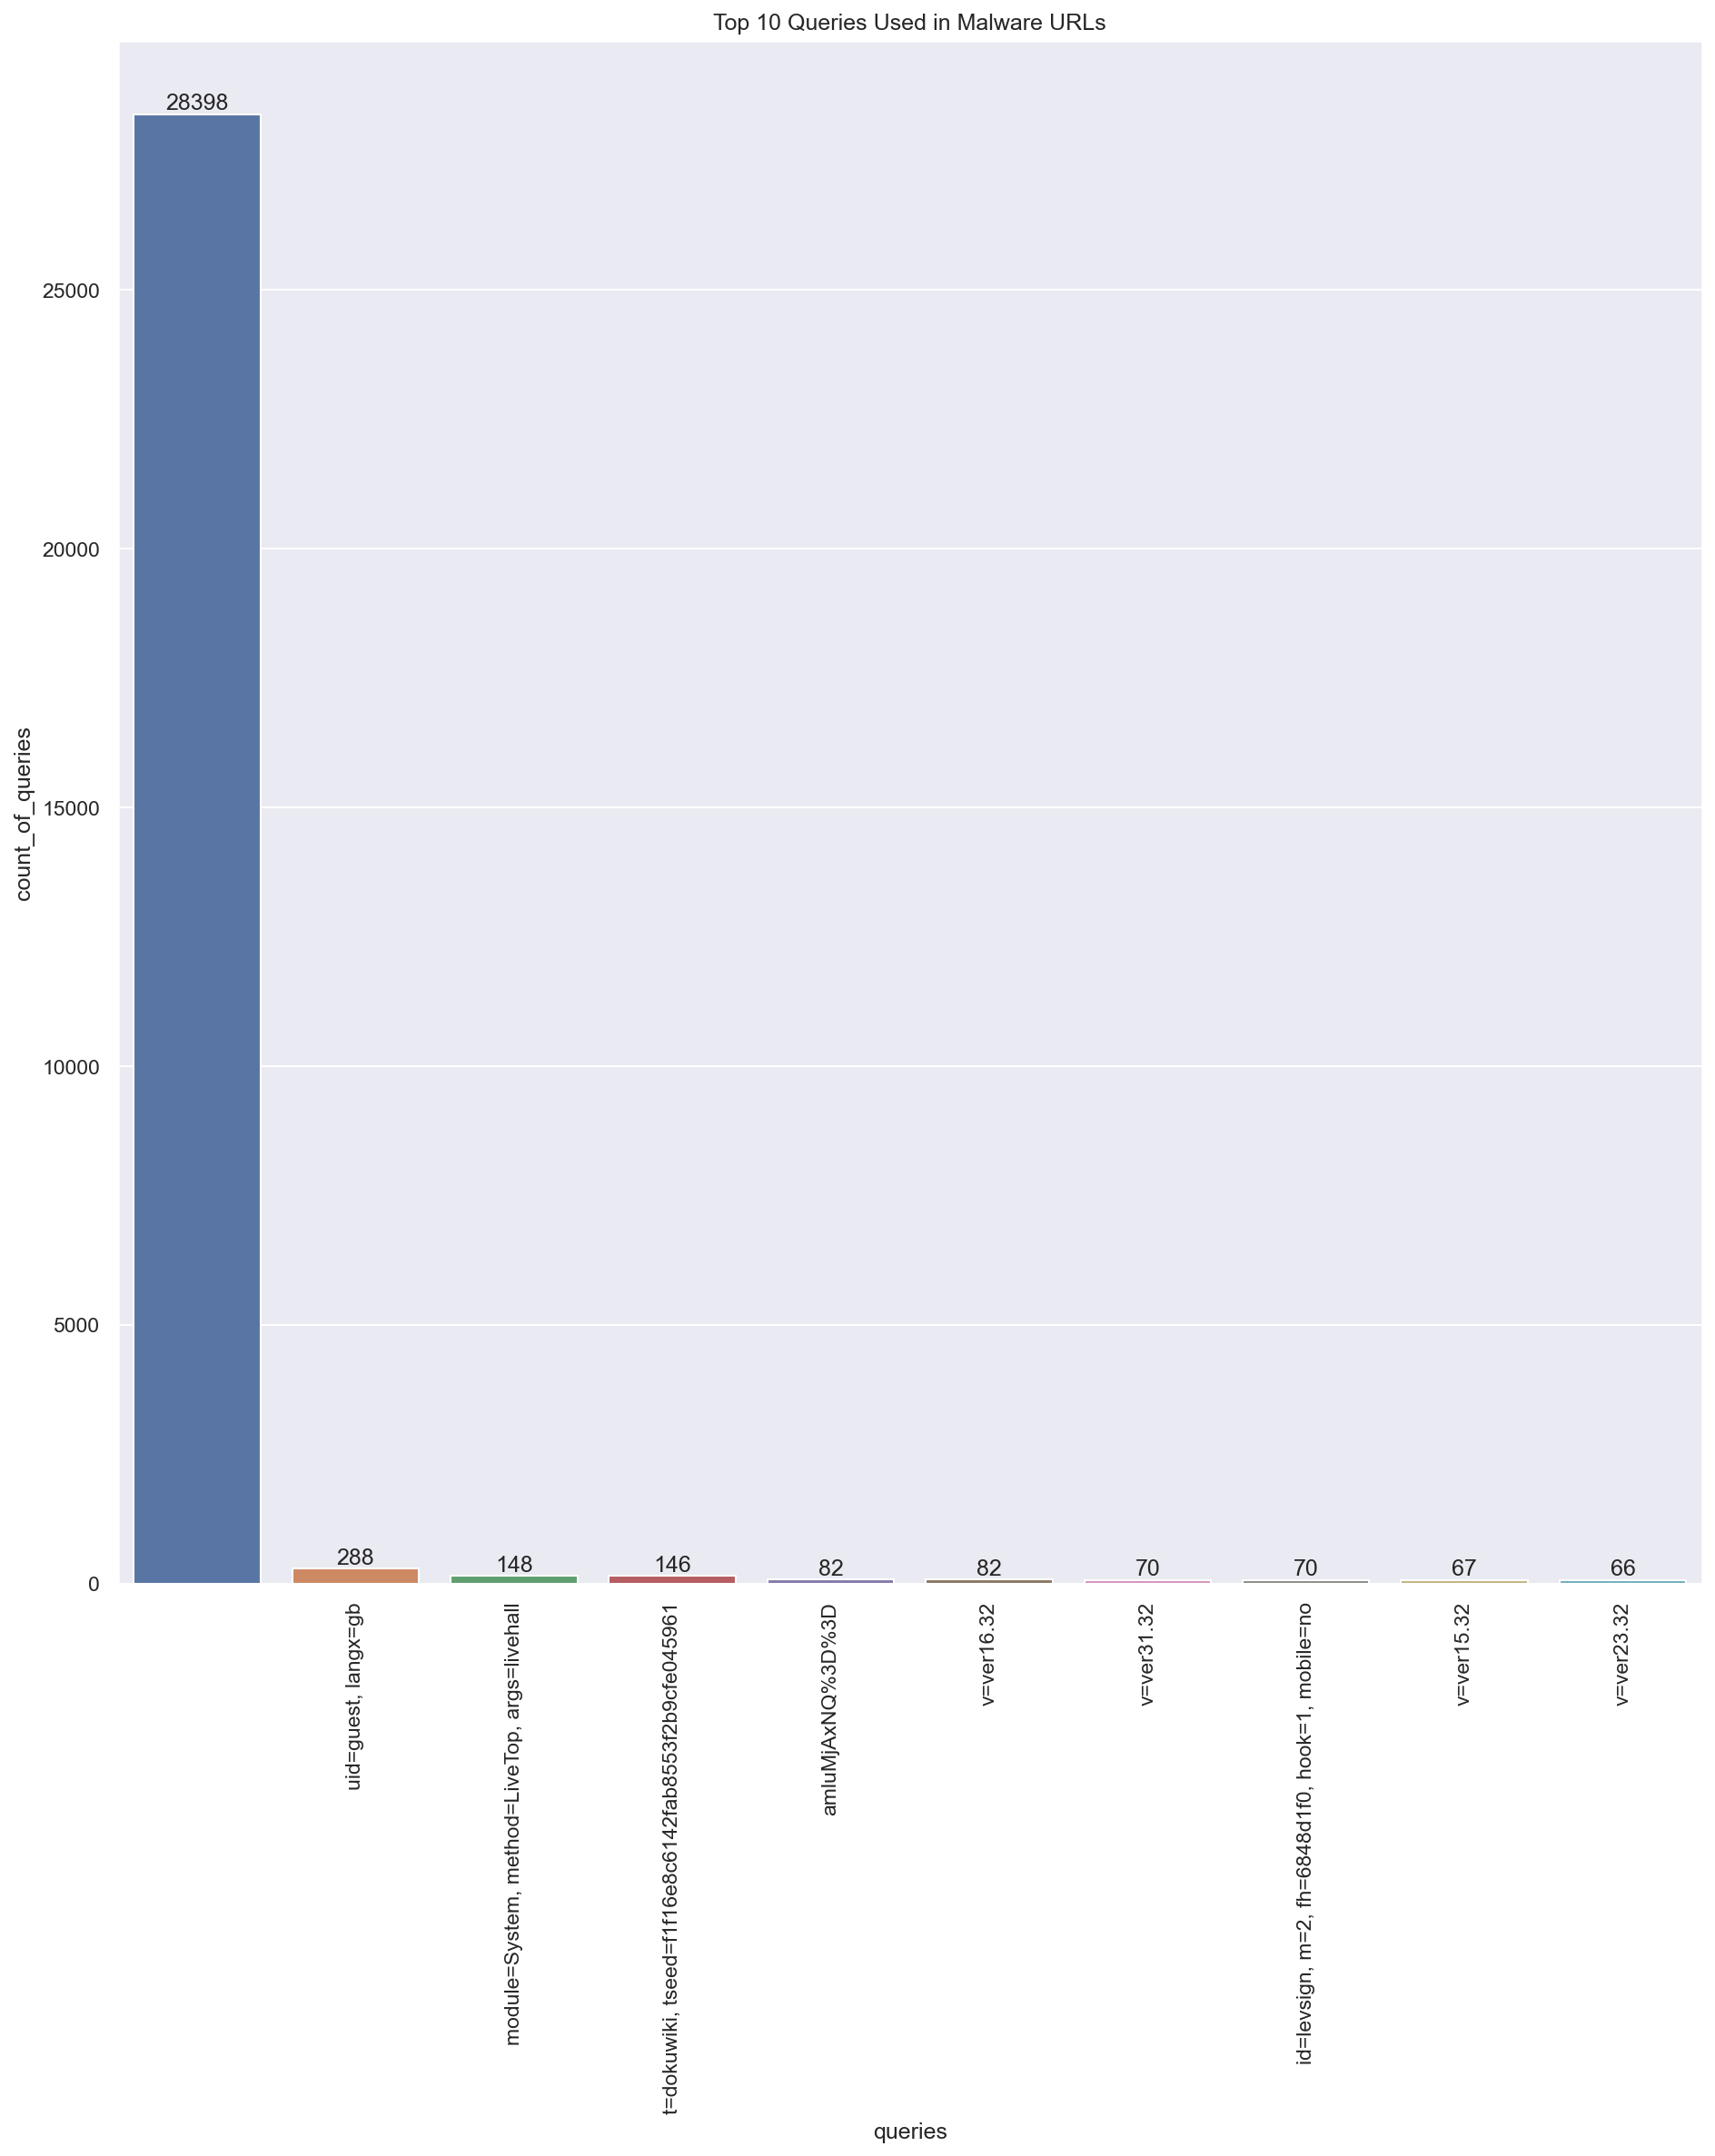

In [59]:
fig, ax = plt.subplots(dpi=150)

sns.set(rc = {'figure.figsize':(15, 15)})
ax.set_title("Top 10 Queries Used in Malware URLs")
ax.set_xlabel("Queries")
ax.set_ylabel("Total Times Encountered in Data Set")
plt.xticks(rotation=90)

sns.barplot(x='queries', y='count_of_queries', data=top_10_malware_qs)

for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f')

fig.savefig('top_10_malware_qs.png')

In [60]:
malware_sch = pd.DataFrame(malware_urls['scheme'])

malware_sch['scheme'] = malware_sch['scheme'].astype('str')

malware_sch = malware_sch[malware_sch['scheme'] != 'nan'].reset_index()

malware_sch.head()

index scheme
0     38   http
1    115   http
2    156   http
3    212   http
4    240   http

In [61]:
malware_sch['scheme'].value_counts()

http              24546
https              6764
77.228.191.183        9
escuelanet.com        1
Name: scheme, dtype: int64

In [62]:
malware_sch_df = pd.DataFrame(malware_sch['scheme'].value_counts())

malware_sch_df.rename(columns={'scheme':'count_of_scheme'}, inplace=True)

malware_sch_df.index.names = ['scheme']

malware_sch_df.reset_index(inplace=True)

print(malware_sch_df)

           scheme  count_of_scheme
0            http            24546
1           https             6764
2  77.228.191.183                9
3  escuelanet.com                1


In [63]:
top_10_malware_sch = malware_sch_df.head(10)

In [64]:
malware_net = pd.DataFrame(malware_urls['netloc'])

malware_net['netloc'] = malware_net['netloc'].astype('str')

malware_net = malware_net[malware_net['netloc'] != 'nan'].reset_index()

malware_net.head(50)

index                 netloc
0      38             824555.com
1     115              9779.info
2     156              9779.info
3     212              9779.info
4     240          chinacxyy.com
5     243              9779.info
6     325   portal.dddgaming.com
7     339              9779.info
8     371              9779.info
9     440  grasslandhotel.com.vn
10    450              9779.info
11    493              9779.info
12    501    style.org.hc360.com
13    530    img14.360buyimg.com
14    532              9779.info
15    588         vilagnomad.com
16    717             wu8188.com
17    782              9779.info
18    809         ak.imgfarm.com
19    811            0068555.com
20    819       easycaptchas.com
21    876              9779.info
22    887          haishundl.com
23    892              9779.info
24    958              9779.info
25    989              9779.info
26   1145          zoetekroon.nl
27   1171                 3cf.ru
28   1199              9779.info
29   1221        img010.hc360.cn
30   1227              9779.info
31   1233           newstudy.net
32   1286             711100.com
33   1295        schertzauto.com
34   1361   portal.dddgaming.com
35   1402        schertzauto.com
36   1453               bhxx.net
37   1484  grasslandhotel.com.vn
38   1664                 3cf.ru
39   1739              9779.info
40   1759          chinacxyy.com
41   1782              9779.info
42   1800             xj9599.com
43   1822             824555.com
44   1833             pubyun.com
45   1924            jin0044.com
46   1949              9779.info
47   1989          chinacxyy.com
48   2023        13801993263.com
49   2071              9779.info

In [65]:
malware_net_df = pd.DataFrame(malware_net['netloc'].value_counts())

malware_net_df.rename(columns={'netloc':'count_of_netloc'}, inplace=True)

malware_net_df.index.names = ['netloc']

malware_net_df.reset_index(inplace=True)

print(malware_net_df)

                     netloc  count_of_netloc
0                 9779.info             3984
1      mitsui-jyuku.mixh.jp             2879
2              apbfiber.com             1147
3              pastebin.com              987
4              toulousa.com              501
...                     ...              ...
6985  182.116.215.104:60581                1
6986    31.146.124.20:34917                1
6987    111.42.103.77:49997                1
6988    89.148.255.10:45345                1
6989     172.36.45.82:41684                1

[6990 rows x 2 columns]


In [66]:
top_10_malware_net = malware_net_df.head(10)

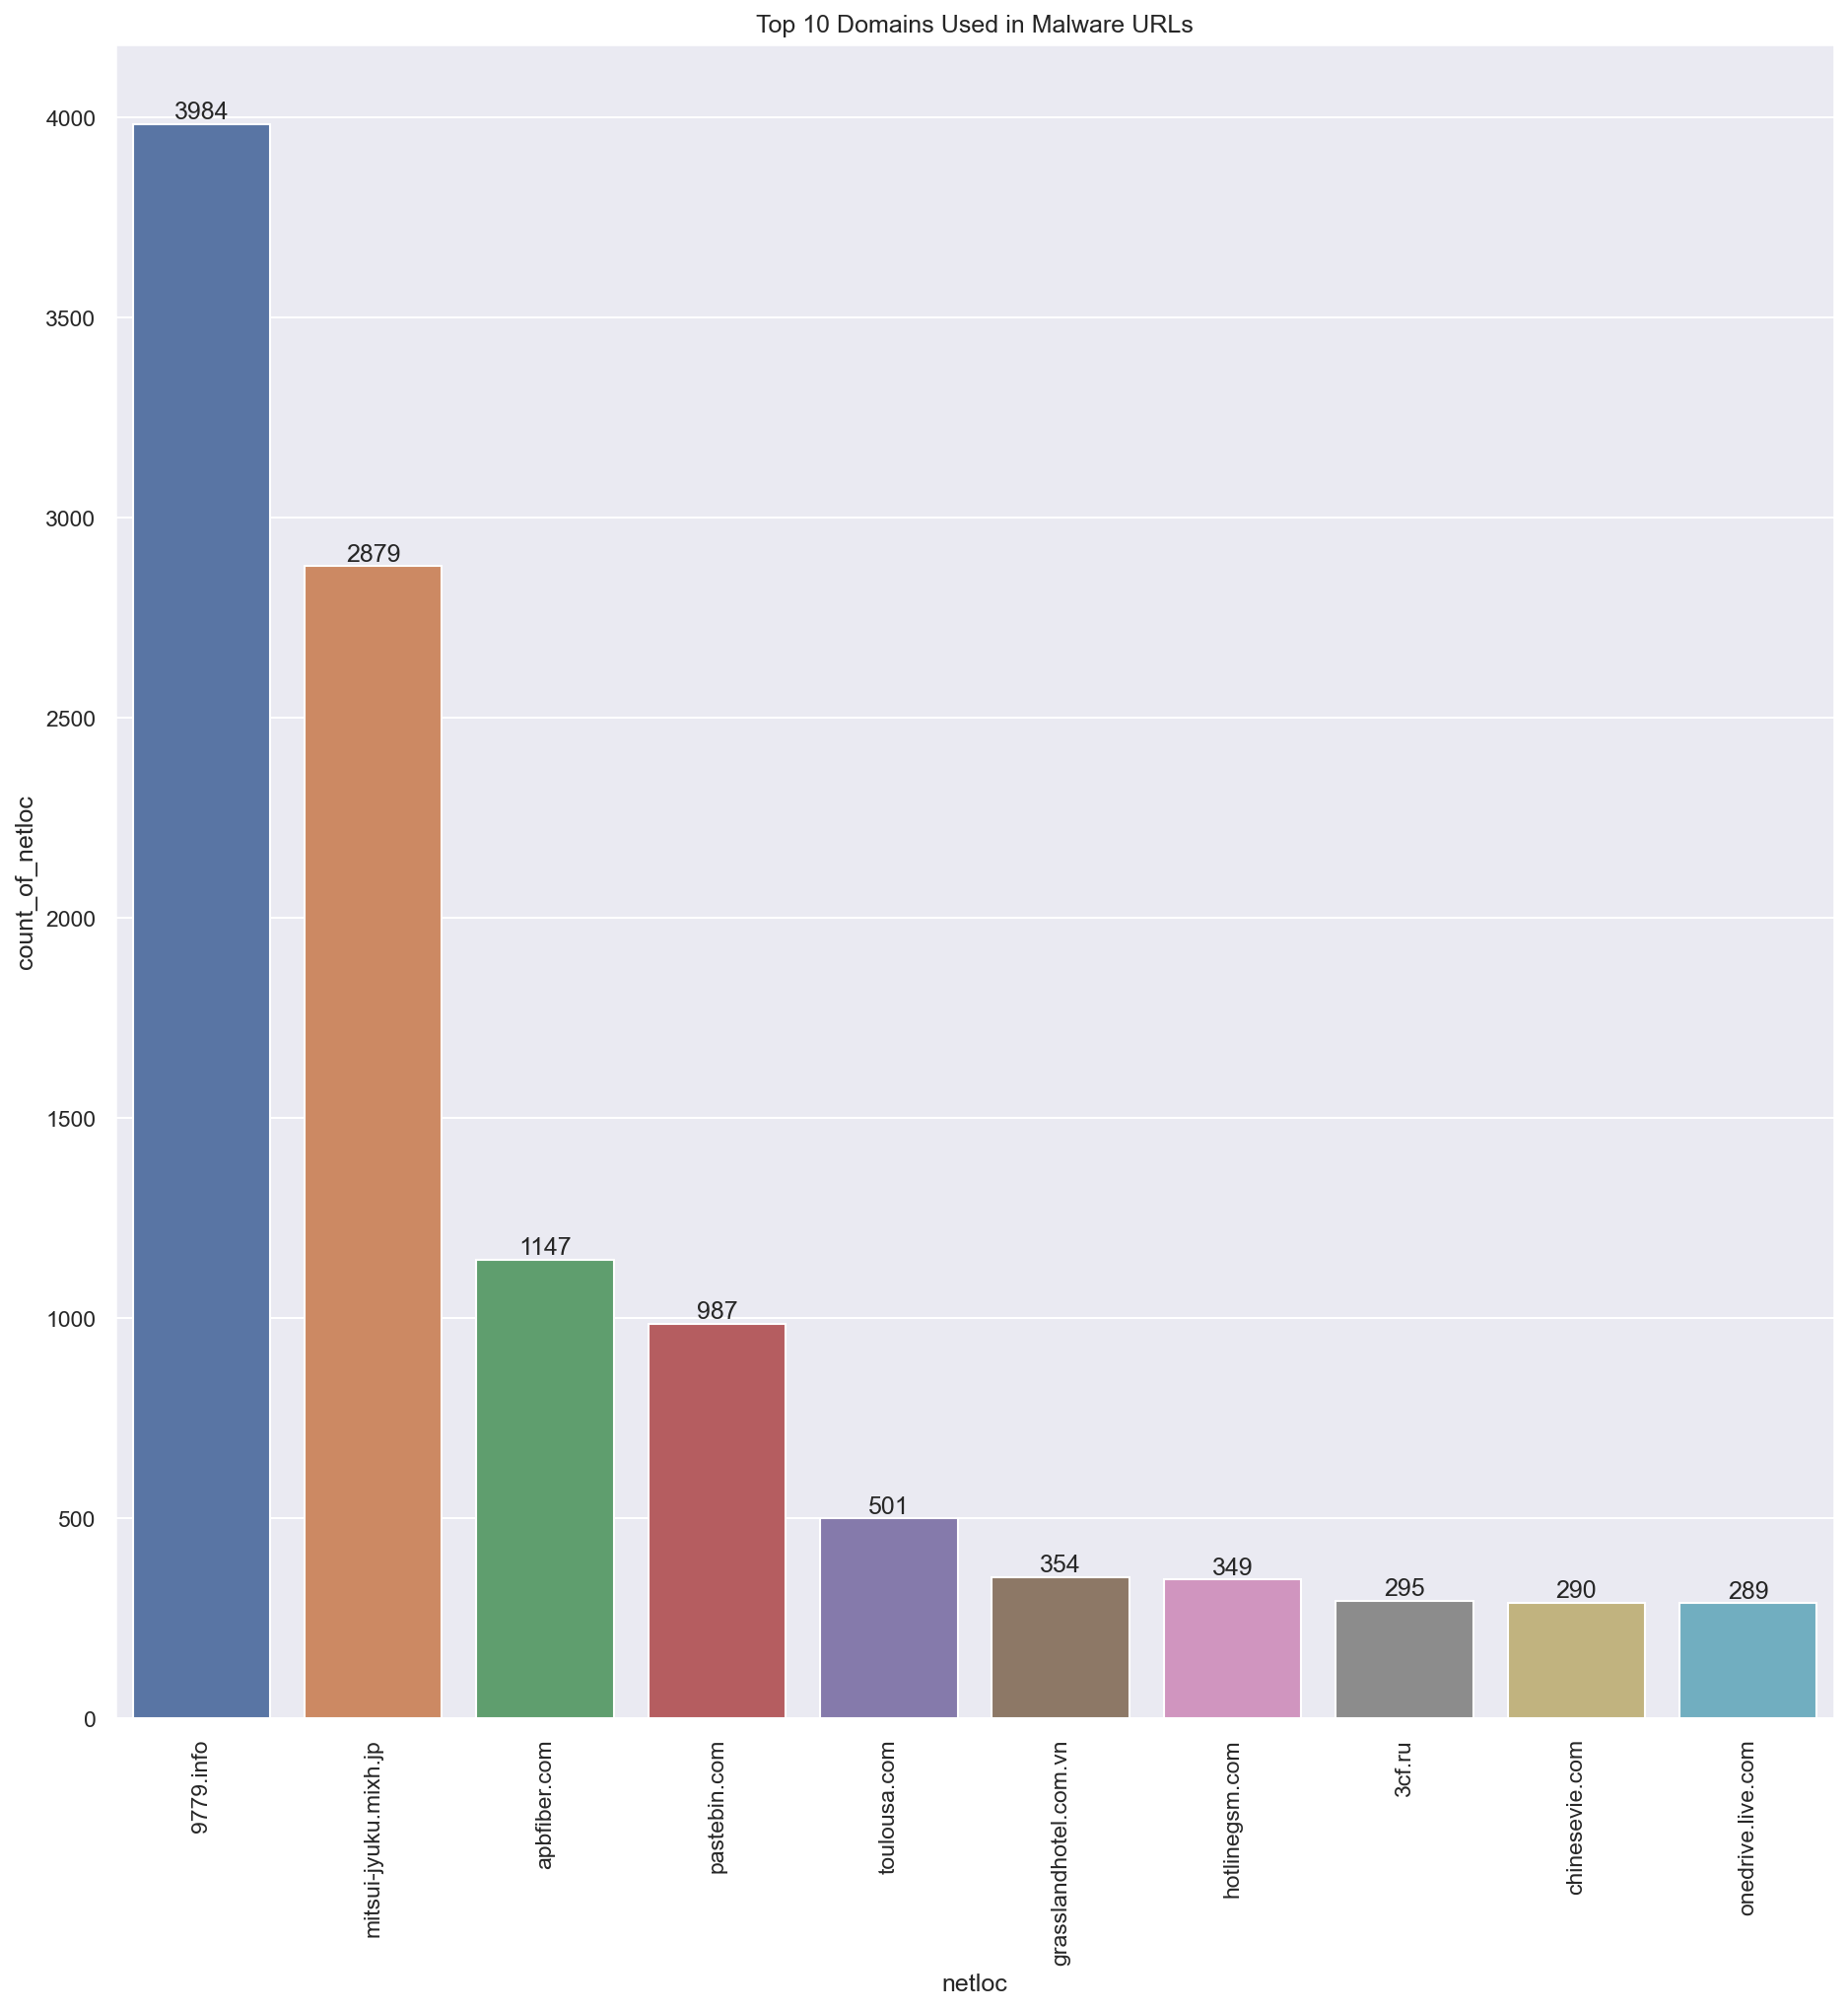

In [67]:
fig, ax = plt.subplots(dpi=150)

sns.set(rc = {'figure.figsize':(15, 15)})
ax.set_title("Top 10 Domains Used in Malware URLs")
ax.set_xlabel("Domains")
ax.set_ylabel("Total Times Encountered in Data Set")
plt.xticks(rotation=90)

sns.barplot(x='netloc', y='count_of_netloc', data=top_10_malware_net)

for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f')

fig.savefig('top_10_malware_net.png')

## Defacement URLs

In [68]:
# The same is now done to analyse defacement URLs:

deface_dirs = defacement_urls['directories'].str[1:-1].reset_index()

deface_dirs['directories'] = deface_dirs['directories'].str.replace(r'\'', '', regex=True)

deface_dirs = pd.DataFrame(deface_dirs['directories'].apply(lambda x: ''.join(map(str, x))))


deface_dirs.dropna()
deface_dirs.head(50)

directories
0                                           index.php
1                                           index.php
2                                      pure-pashminas
3              index.php, exposities, exposities-2006
4                              index.php, aktuelles.1
5                                       cimoldal.html
6                                catalogo, palloncini
7                                     khach-hang.html
8                                           index.php
9                         component, user, reset.html
10  industrial-tech, everlast-impact-resistant-dum...
11  courses, health-and-social-care, level-2-diplo...
12                                spring, mothers-day
13                                             ck.htm
14                                          index.php
15                                         index.html
16                                 southwest, 9-texas
17                                   lista_socios.php
18          links, 2-linkseite, 5-httpwwwkrebshilfede
19                 index.php, servicios, centro-jambo
20                                          index.php
21                                      catalogo.html
22                                          index.php
23                             diensten, 62-telefonie
24  ukraine, tours, 2754-arboretum-alexandria-sofi...
25         index.php, location, osteria-del-molo.html
26                                            de.feed
27                                          index.php
28                           espace-prive, reset.html
29                                          index.php
30                              calcomanias-en-vinilo
31                                          index.php
32                                          index.php
33                        hoogwerker, hoogwerkers.pdf
34                                          index.php
35                                          index.php
36                            index.php, densiometria
37       stock-list, caravans, 706-elddis-odyssey-540
38  index.php, nl, vacatures, table, 9, 0, index.html
39                                          xmap.html
40                                  arabic, index.php
41                                  bruine-bonen.html
42                  formations, pose-ongles, 108.html
43                                          index.php
44                                          index.php
45                                      v1, index.php
46  motocikli, novice, volta-bcn-city-je-elektricn...
47                                   lista_socios.php
48                                           products
49                                          index.php

In [69]:
# Defacement directories: Create a word cloud of all non-obfuscated URLs:
all_deface_dirs = ''

for i in range(deface_dirs.shape[0]):
    # Add each token to the list.
    all_deface_dirs = all_deface_dirs + (deface_dirs['directories'][i])

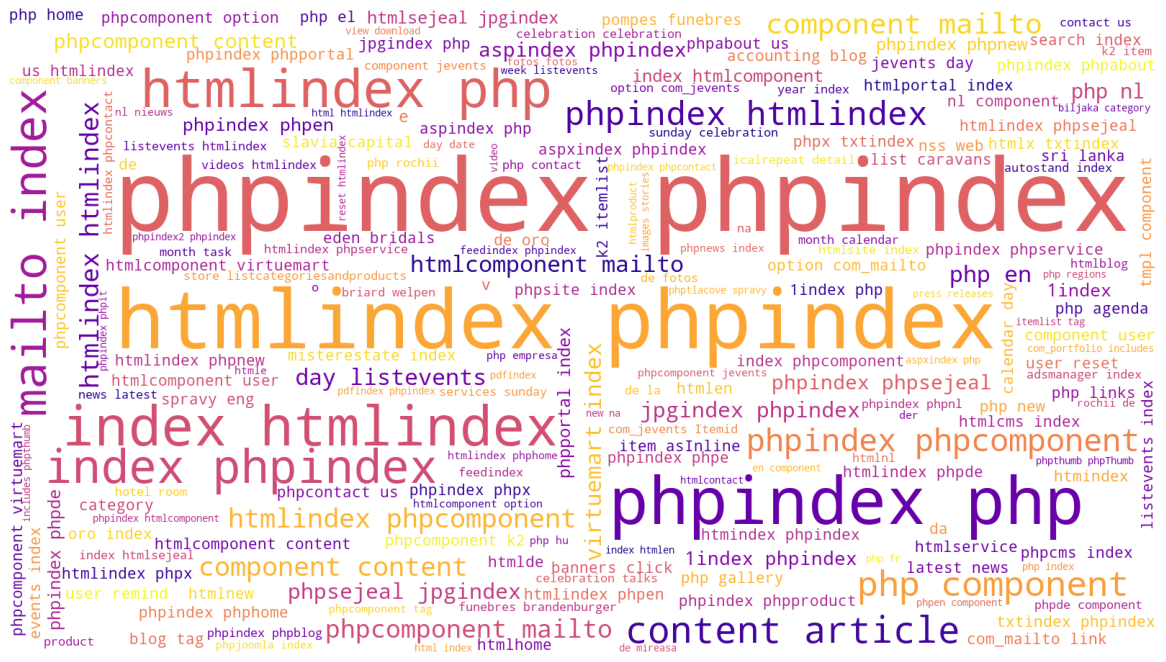

In [70]:
# Create a WordCloud.

wordcloud = WordCloud(width = 1600, height = 900, 
                background_color ='white', 
                colormap='plasma', 
                min_font_size = 10).generate(all_deface_dirs)

# Plot the WordCloud image.                        
plt.figure(figsize = (16, 9), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 
plt.show()

fig.savefig('defacement_dirs_wordcloud.png')

In [71]:
deface_dirs_df = pd.DataFrame(deface_dirs['directories'].value_counts())

deface_dirs_df.rename(columns={'directories':'count_of_directories'}, inplace=True)

deface_dirs_df.index.names = ['directories']

deface_dirs_df.reset_index(inplace=True)

print(deface_dirs_df)

                         directories  count_of_directories
0                          index.php                 39141
1                         index.html                  3145
2                         sejeal.jpg                  1283
3      component, mailto, index.html                  1078
4                              x.txt                   663
...                              ...                   ...
35300              londra-luton.html                     1
35301                 contact-us, 44                     1
35302           europe-short-escapes                     1
35303           az, testler, quiz, 3                     1
35304          tu-bep-nhom-kinh.html                     1

[35305 rows x 2 columns]


In [72]:
top_10_deface_dirs = deface_dirs_df.head(10)

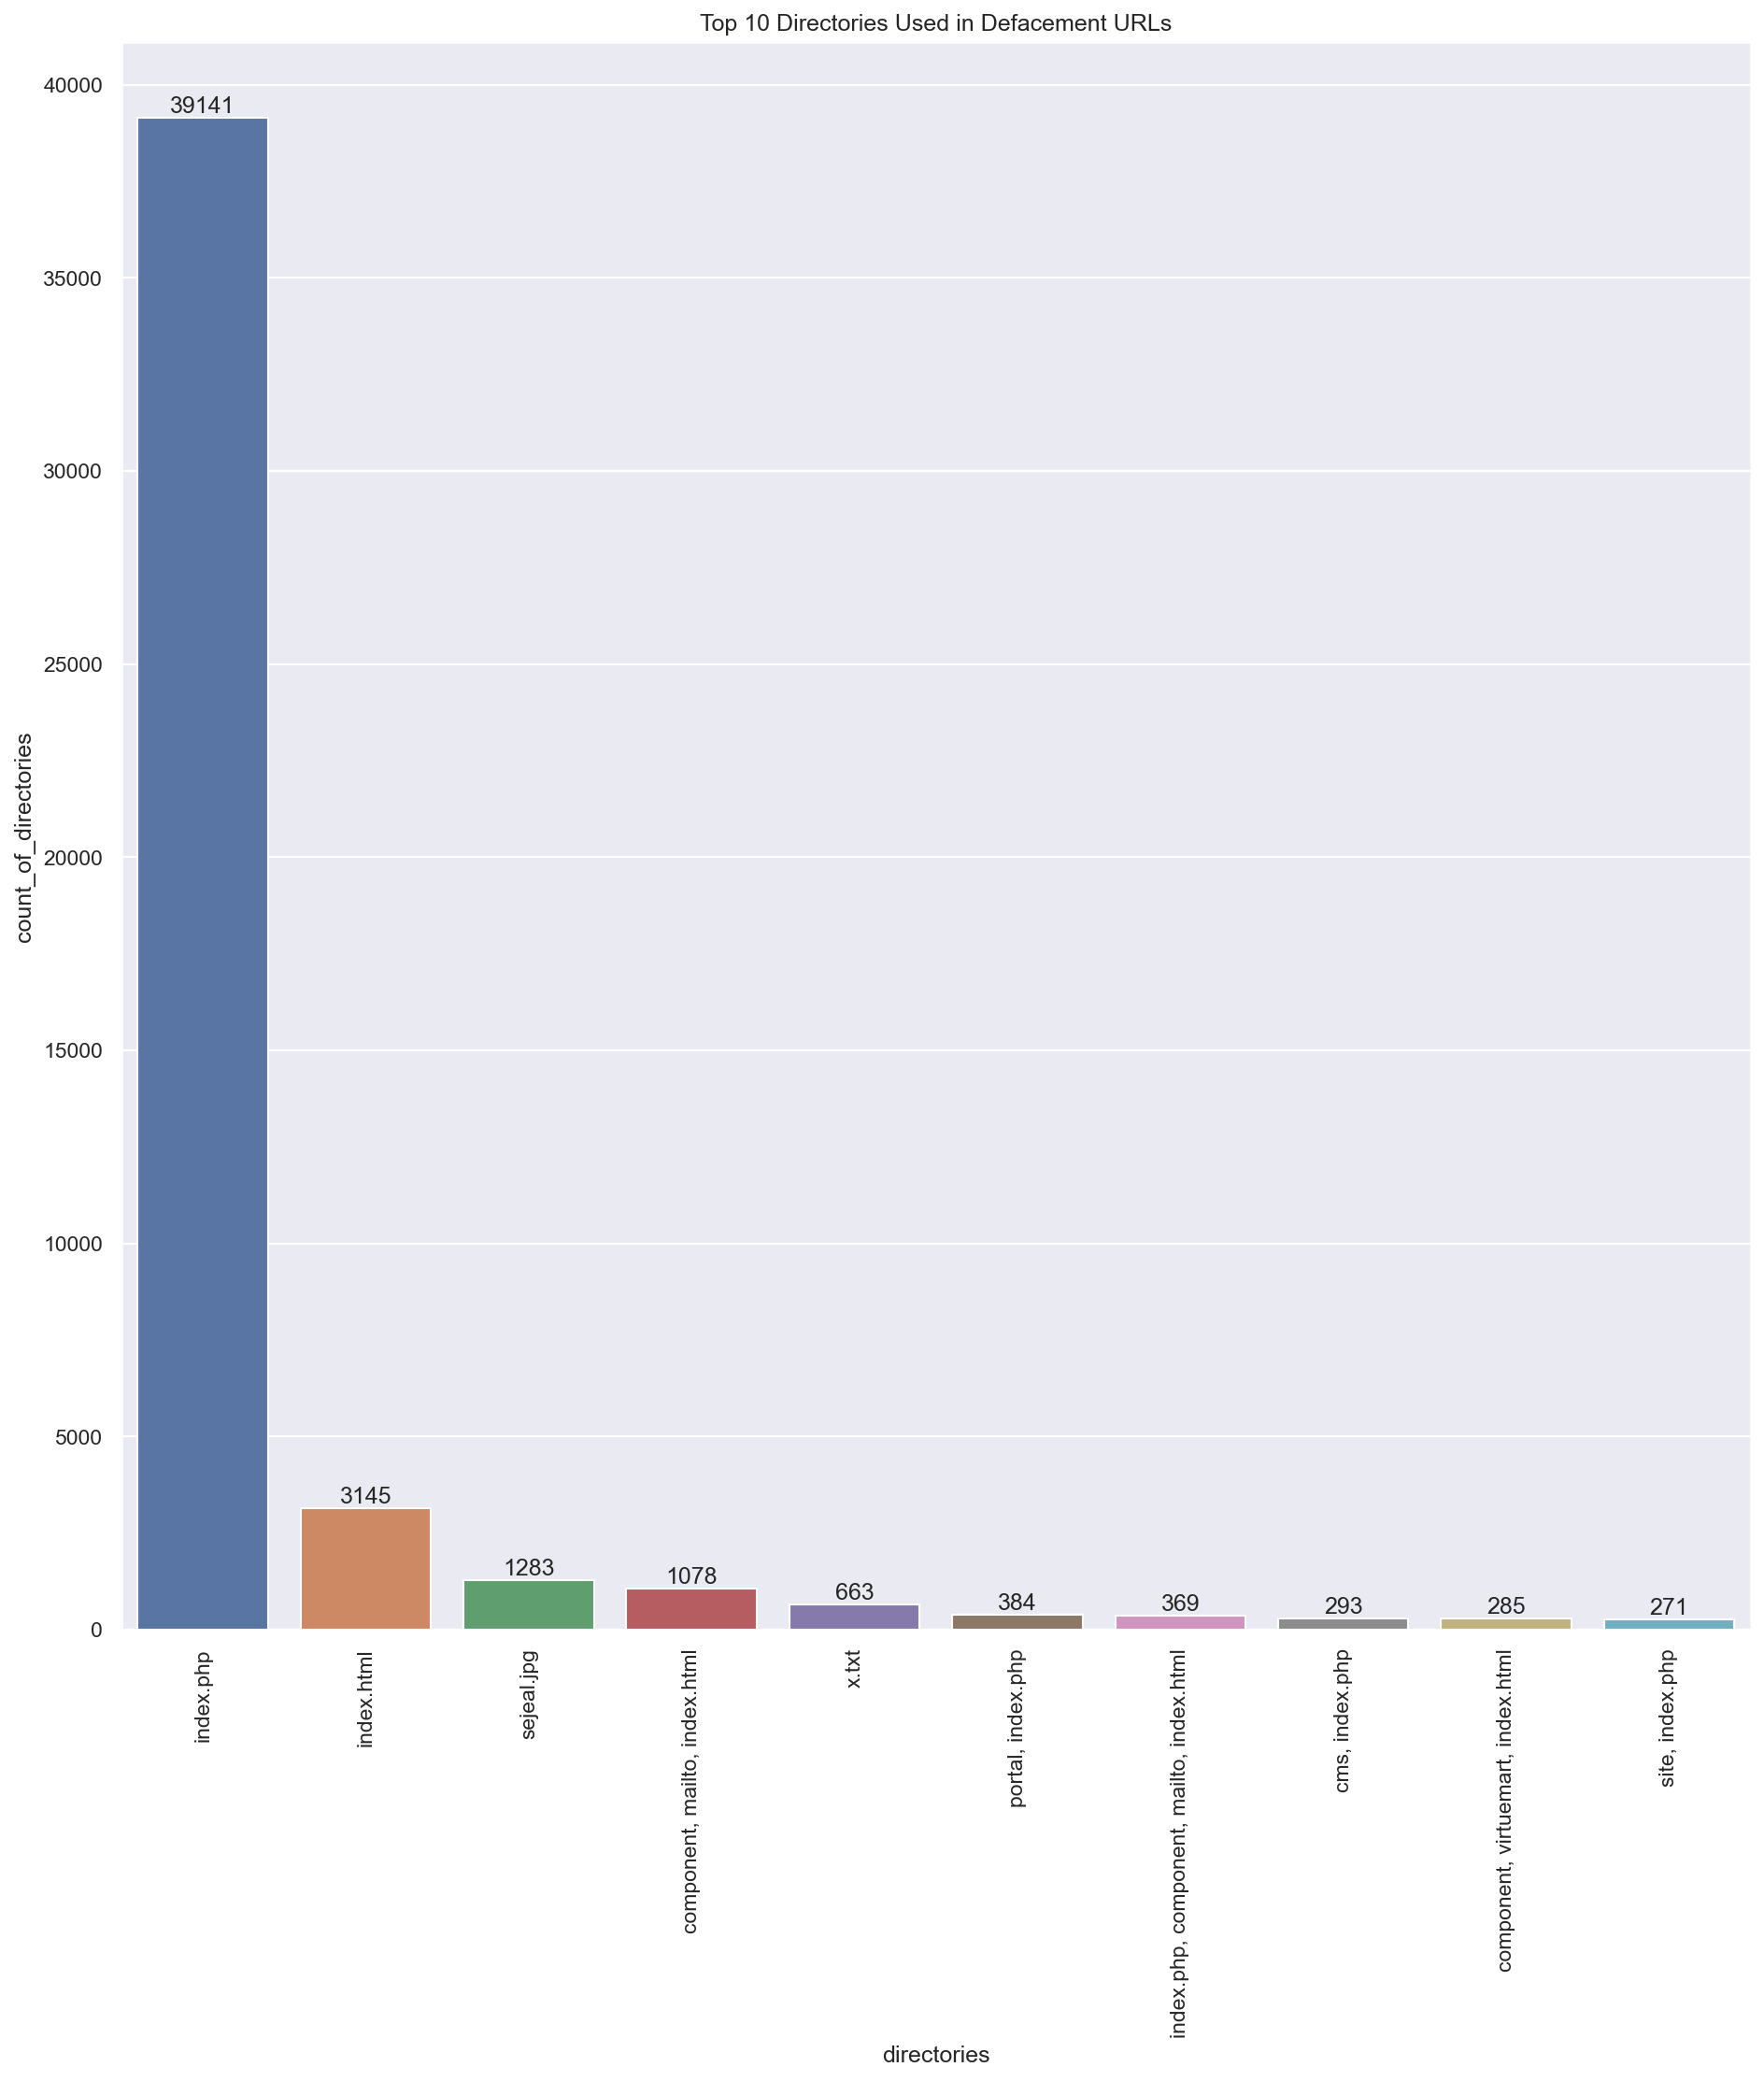

In [73]:
fig, ax = plt.subplots(dpi=150)

sns.set(rc = {'figure.figsize':(15, 15)})
ax.set_title("Top 10 Directories Used in Defacement URLs")
ax.set_xlabel("Directories")
ax.set_ylabel("Total Times Encountered in Data Set")
plt.xticks(rotation=90)

sns.barplot(x='directories', y='count_of_directories', data=top_10_deface_dirs)

for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f')

fig.savefig('top_10_deface_dirs.png')

In [74]:
deface_qs = defacement_urls['queries'].str[1:-1].reset_index()

deface_qs['queries'] = deface_qs['queries'].str.replace(r'\'', '', regex=True)

deface_qs = pd.DataFrame(deface_qs['queries'].apply(lambda x: ''.join(map(str, x))))

deface_qs.dropna().reset_index()
deface_qs.head()

queries
0  option=com_content, view=article, id=70, vsig7...
1  option=com_mailto, tmpl=component, link=aHR0cD...
2                                                   
3                                                   
4

In [75]:
# Defacement queries: Create a word cloud.
all_deface_qs = ''

for i in range(deface_qs.shape[0]):
    # Add each token to the list.
    all_deface_qs = all_deface_qs + deface_qs['queries'][i]

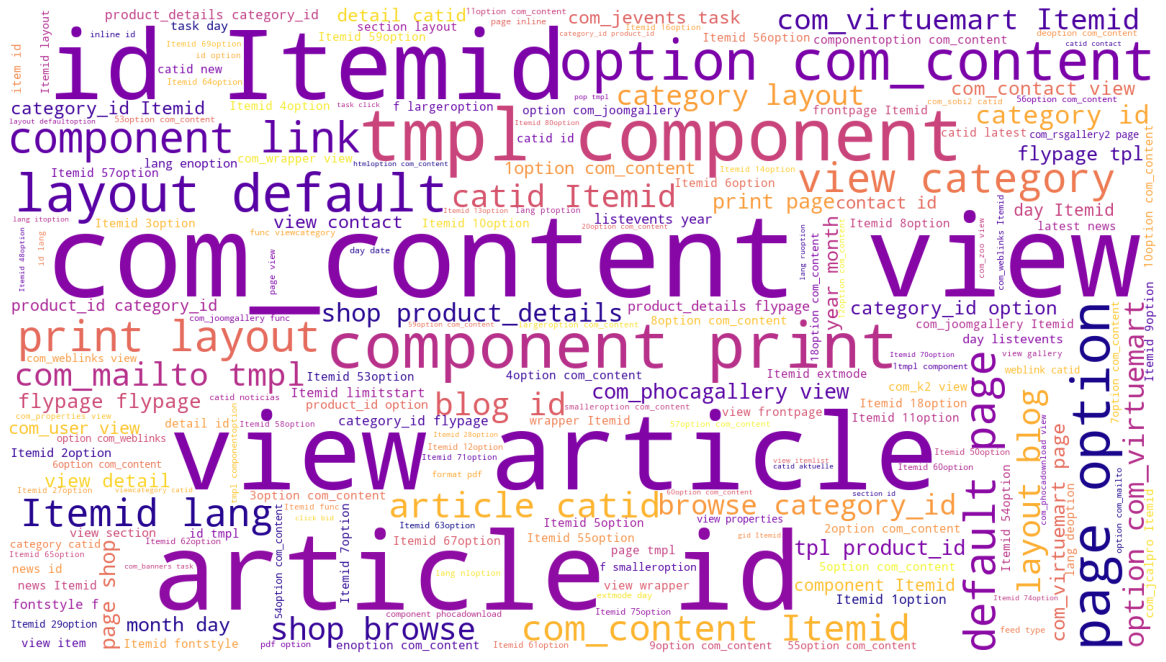

In [76]:
# Create a WordCloud.
wordcloud = WordCloud(width = 1600, height = 900, 
                background_color ='white', 
                colormap='plasma', 
                min_font_size = 10).generate(all_deface_qs) 

# Plot the WordCloud image.                        
plt.figure(figsize = (16, 9), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 
plt.show()

fig.savefig('defacement_qs_wordcloud.png')

In [77]:
deface_qs_df = pd.DataFrame(deface_qs['queries'].value_counts())

deface_qs_df.rename(columns={'queries':'count_of_queries'}, inplace=True)

deface_qs_df.index.names = ['queries']

deface_qs_df.reset_index(inplace=True)

print(deface_qs_df)

                                                 queries  count_of_queries
0                                                                    41495
1                         tmpl=component, print=1, page=              1205
2                                         tmpl=component               706
3         tmpl=component, print=1, layout=default, page=               595
4                            option=com_user, view=reset               212
...                                                  ...               ...
42328  option=com_content, view=category, id=35, Item...                 1
42329  page=shop.browse, category_id=2, option=com_vi...                 1
42330  view=article, catid=54:creditos, id=116:cobert...                 1
42331  option=com_content, view=article, id=125, Item...                 1
42332  view=article, catid=25:capella, id=75:capellap...                 1

[42333 rows x 2 columns]


In [78]:
top_10_deface_qs = deface_qs_df.head(10)

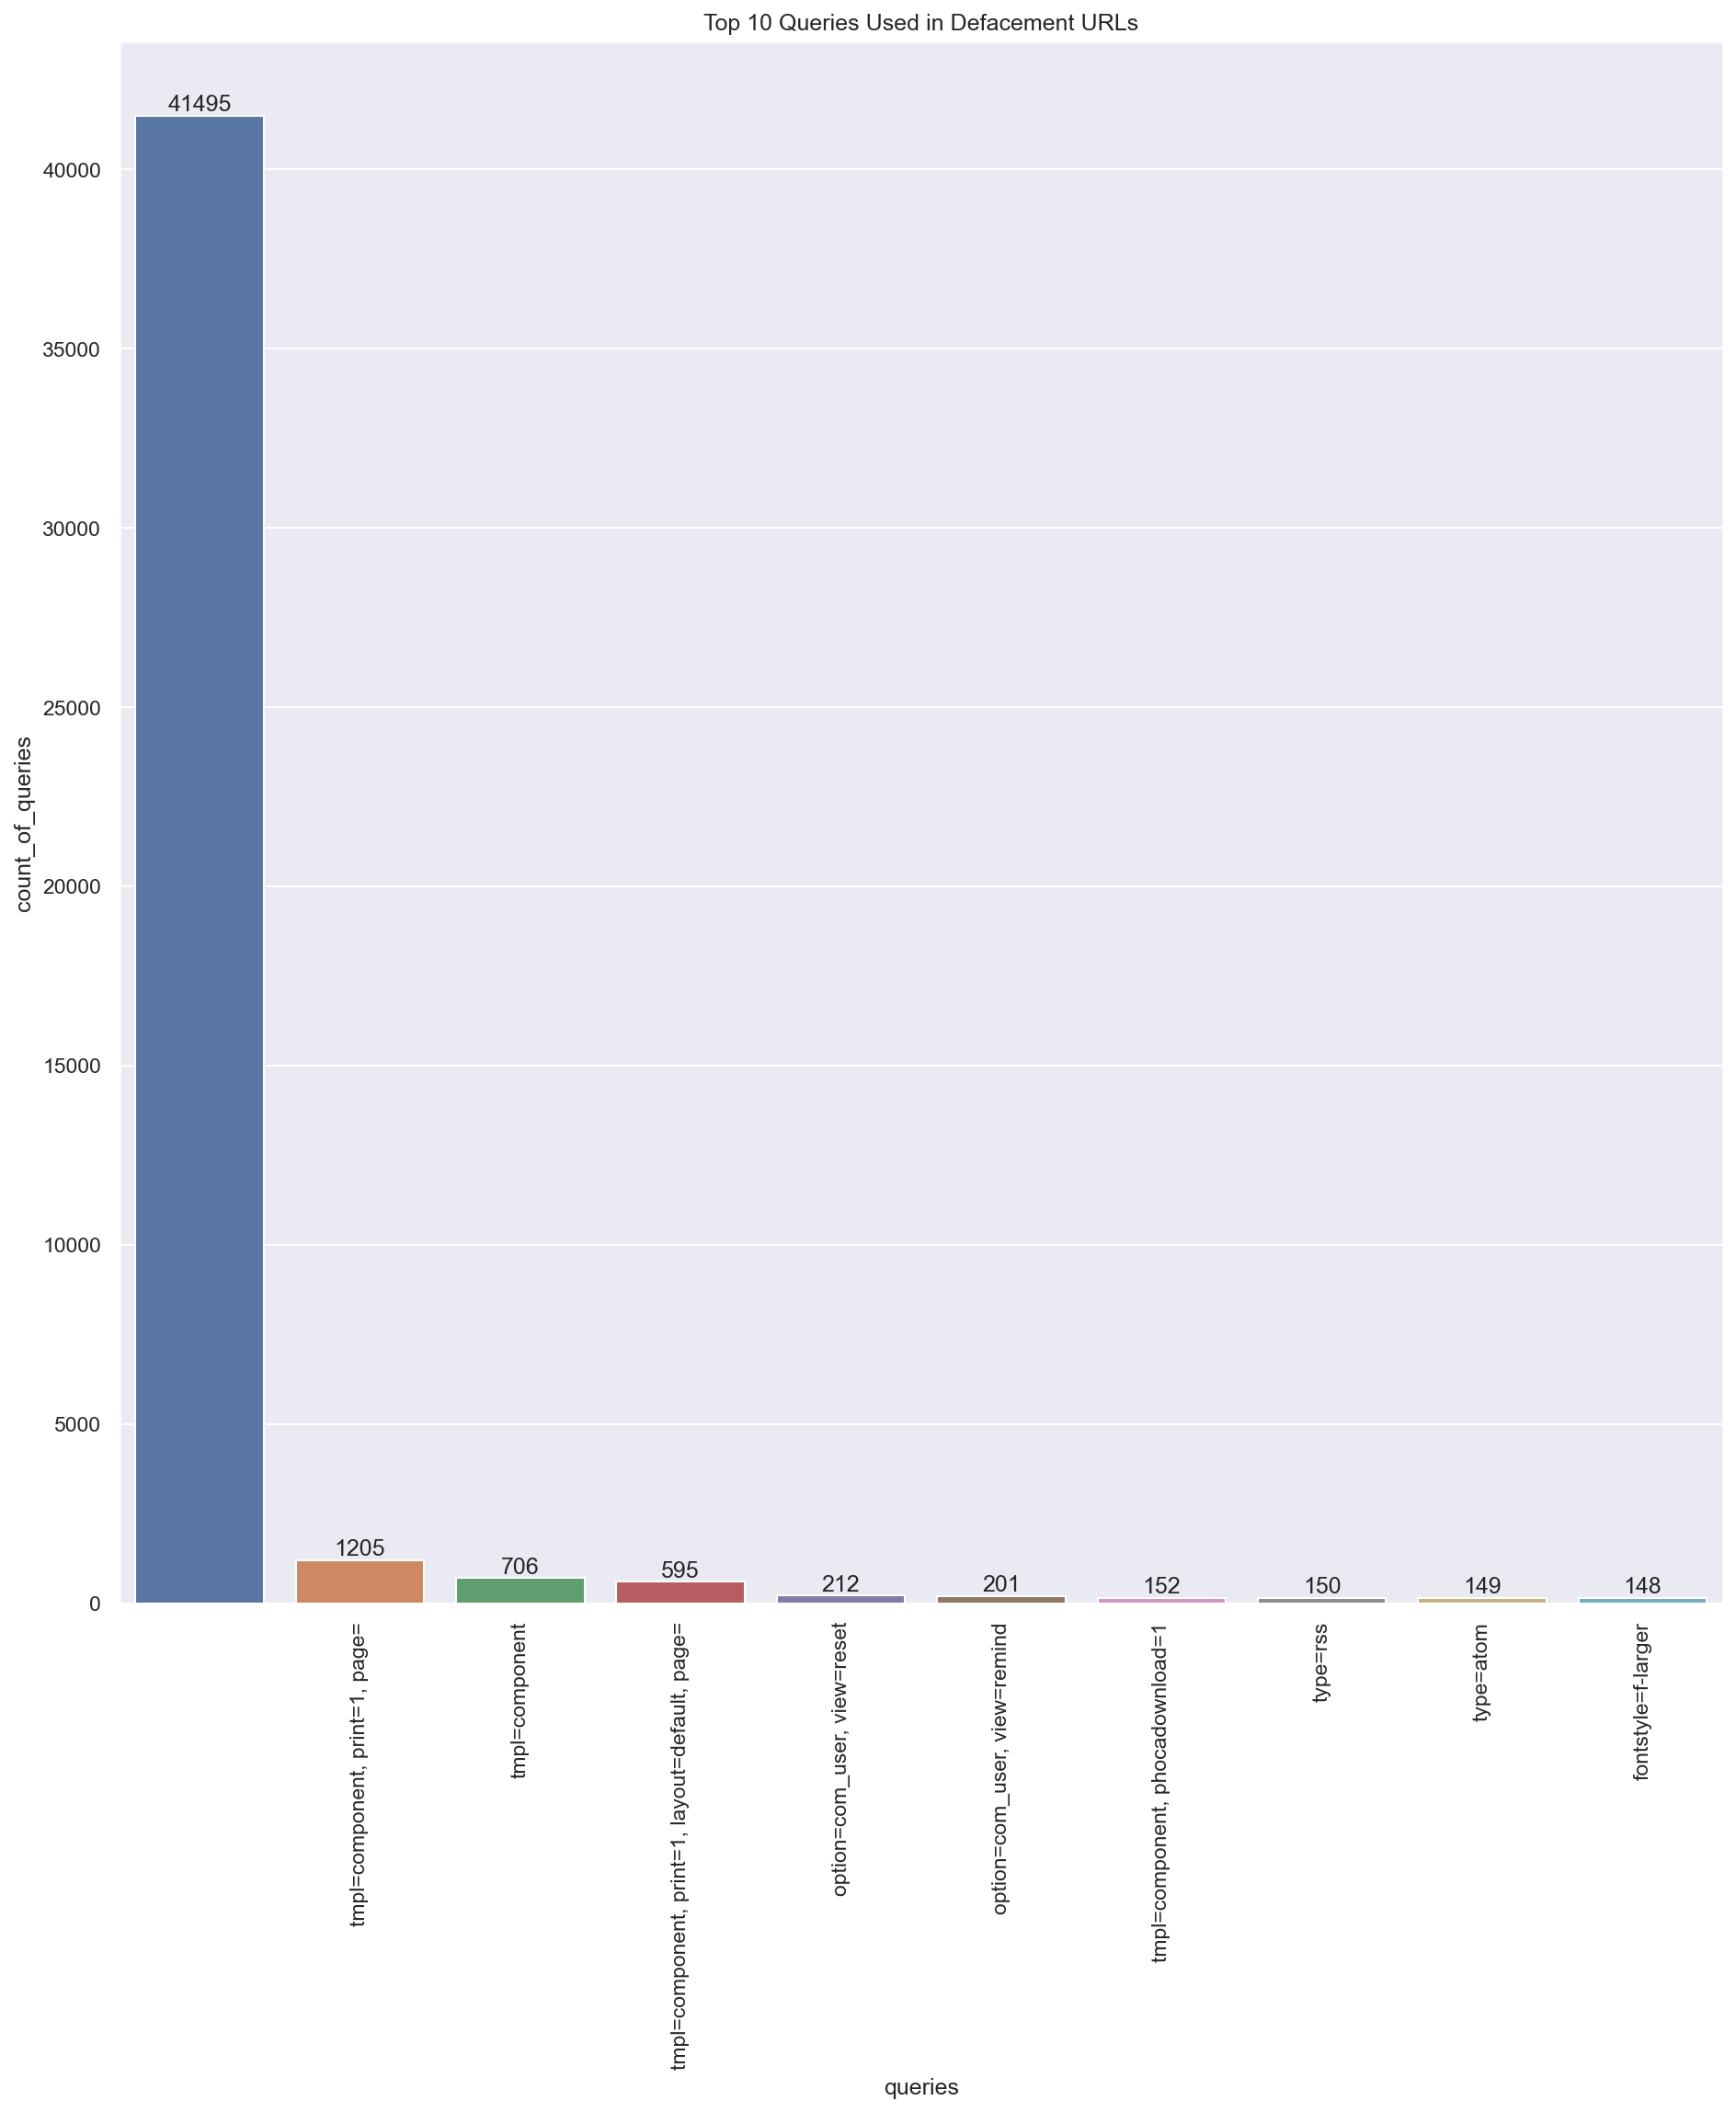

In [79]:
fig, ax = plt.subplots(dpi=150)

sns.set(rc = {'figure.figsize':(15, 15)})
ax.set_title("Top 10 Queries Used in Defacement URLs")
ax.set_xlabel("Queries")
ax.set_ylabel("Total Times Encountered in Data Set")
plt.xticks(rotation=90)

sns.barplot(x='queries', y='count_of_queries', data=top_10_deface_qs)

for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f')

fig.savefig('top_10_deface_qs.png')

In [80]:
deface_sch = pd.DataFrame(defacement_urls['scheme'])

deface_sch['scheme'] = deface_sch['scheme'].astype('str')

deface_sch = deface_sch[deface_sch['scheme'] != 'nan'].reset_index()

deface_sch.head()

index scheme
0      3   http
1      4   http
2      8   http
3     11   http
4     13   http

In [81]:
deface_sch['scheme'].value_counts()

http    96457
Name: scheme, dtype: int64

In [82]:
deface_sch_df = pd.DataFrame(deface_sch['scheme'].value_counts())

deface_sch_df.rename(columns={'scheme':'count_of_scheme'}, inplace=True)

deface_sch_df.index.names = ['scheme']

deface_sch_df.reset_index(inplace=True)

print(deface_sch_df)

  scheme  count_of_scheme
0   http            96457


In [83]:
top_10_deface_sch = deface_sch_df.head(10)

In [84]:
deface_net = pd.DataFrame(defacement_urls['netloc'])

deface_net['netloc'] = deface_net['netloc'].astype('str')

deface_net = deface_net[deface_net['netloc'] != 'nan'].reset_index()

deface_net.head(50)

index                              netloc
0       3                   garage-pirenne.be
1       4             adventure-nicaragua.net
2       8                  pashminaonline.com
3      11                    ikenmijnkunst.nl
4      13        lebensmittel-ueberwachung.de
5      14                   szabadmunkaero.hu
6      15               larcadelcarnevale.com
7      19                             vnic.co
8      35               peluqueriadeautor.com
9      39                             raci.it
10     46                      earth-sure.com
11     50                        newtec.ac.uk
12     51                 kingsmillshotel.com
13     60                      approvi.com.br
14     61                        shaborooz.ir
15     65              juventudelirica.com.br
16     66                          myenrg.com
17     68                       musimagen.com
18     80                     pn-wuppertal.de
19     86                asociacionkaribu.org
20     90                    parafiapiaski.pl
21     96                    artedesignsas.it
22     99                    viamanaus.com.br
23    101                   protect-effect.nl
24    104                  gst-ukraine.com.ua
25    111                   bg-ricevimenti.it
26    117              boeuf-soufflenheim.com
27    124             trenker-bestattungen.de
28    132                  aba-diagnostic.com
29    137                      paoarapanui.cl
30    146               tiendagnulinux.com.ar
31    147                         chelurao.ru
32    162                    familienbund.org
33    163                vanoorschotkranen.nl
34    166                 academiedumeuble.ca
35    168                           maslen.sk
36    169                     clinicatecma.es
37    189           perthshire-caravans.co.uk
38    193                         rendeck.com
39    199                       listovka.info
40    213                         jnpiraq.net
41    215            versverwerktegroenten.nl
42    238  ecoledecoiffurecarolinelaprise.com
43    253                    nabu-gaildorf.de
44    255                     kccs.nichost.ru
45    256                     nubiafarias.com
46    260                   elektro-vozila.si
47    263                       musimagen.com
48    275                      sexshop-bg.biz
49    279             mueblesjulianjimenez.es

In [85]:
deface_net_df = pd.DataFrame(deface_net['netloc'].value_counts())

deface_net_df.rename(columns={'netloc':'count_of_netloc'}, inplace=True)

deface_net_df.index.names = ['netloc']

deface_net_df.reset_index(inplace=True)

print(deface_net_df)

                        netloc  count_of_netloc
0          allaroundrental.com              265
1       bruynzeelmultipanel.be              222
2          ninopizzaria.com.br              209
3          tandemimmobilier.fr              191
4                     zibae.ir              188
...                        ...              ...
2118                 rotors.lv                1
2119  turismoriocoronda.com.ar                1
2120           hengte.com:8080                1
2121           figure2style.fr                1
2122                  jypw.net                1

[2123 rows x 2 columns]


In [86]:
top_10_deface_net = deface_net_df.head(10)

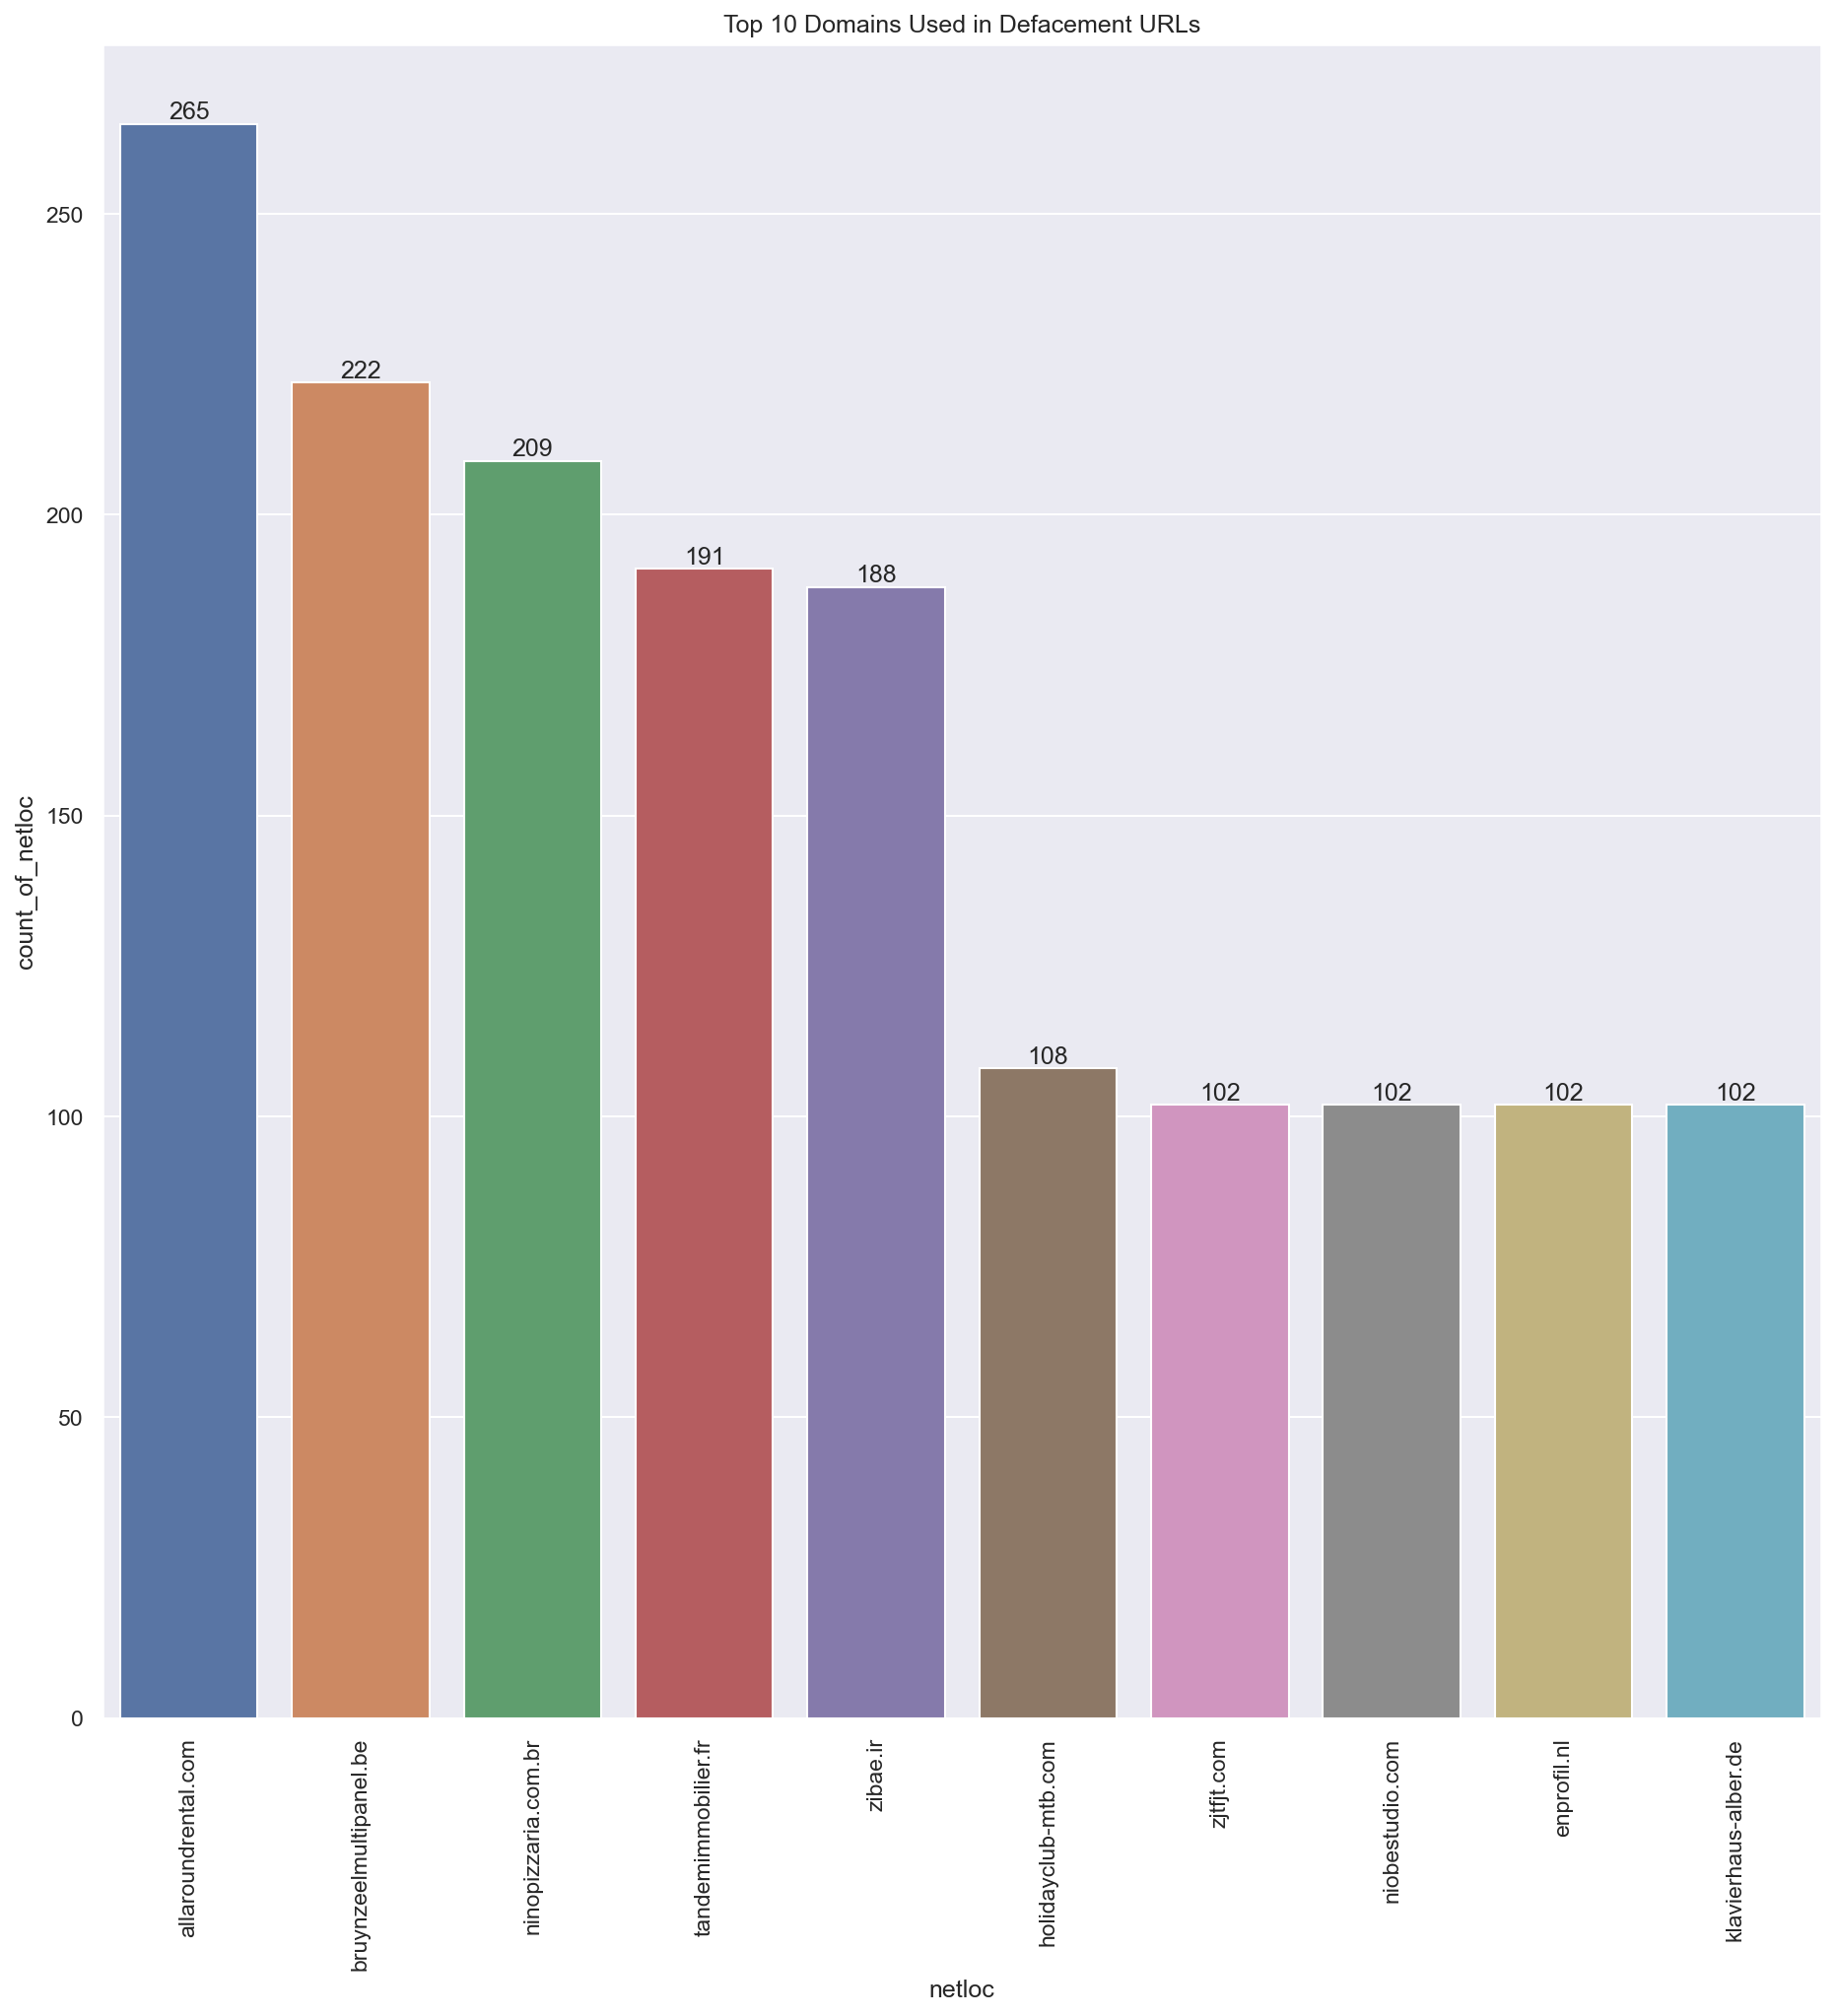

In [87]:
fig, ax = plt.subplots(dpi=150)

sns.set(rc = {'figure.figsize':(15, 15)})
ax.set_title("Top 10 Domains Used in Defacement URLs")
ax.set_xlabel("Domains")
ax.set_ylabel("Total Times Encountered in Data Set")
plt.xticks(rotation=90)

sns.barplot(x='netloc', y='count_of_netloc', data=top_10_deface_net)

for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f')

fig.savefig('top_10_deface_net.png')

In [88]:
# All the directories, queries, scheme and netloc top 10 DataFrames are concatenated together and exported 
# to csv to use for presentation purposes and to compare URL types:

dir_top_10_df = pd.concat([top_10_phish_dir, top_10_malware_dirs, top_10_deface_dirs], axis=1)

dir_top_10_df.head()

directories  count_of_directories                   directories  \
0                                         2525                        Mozi.m   
1                     js                   372                            .i   
2                 images                   293                     index.php   
3  login, en, login.html                   255  app, member, SportOption.php   
4   www.webring.com, hub                   209                      download   

   count_of_directories                    directories  count_of_directories  
0                  4100                      index.php                 39141  
1                   553                     index.html                  3145  
2                   385                     sejeal.jpg                  1283  
3                   288  component, mailto, index.html                  1078  
4                   285                          x.txt                   663

In [89]:
qs_top_10_df = pd.concat([top_10_phish_qs, top_10_malware_qs, top_10_deface_qs], axis=1)

qs_top_10_df.head()

queries  count_of_queries  \
0                                                                85963   
1  http://us.battle.net/login/en/?ref=http%3A%2F%...                60   
2  http://us.battle.net/login/en/?ref=http://us.b...                58   
3                                      usp=send_form                55   
4                       email=nobody@mycraftmail.com                45   

                                             queries  count_of_queries  \
0                                                                28398   
1                                uid=guest, langx=gb               288   
2       module=System, method=LiveTop, args=livehall               148   
3  t=dokuwiki, tseed=f1f16e8c6142fab8553f2b9cfe04...               146   
4                                   amluMjAxNQ%3D%3D                82   

                                          queries  count_of_queries  
0                                                             41495  
1                  tmpl=component, print=1, page=              1205  
2                                  tmpl=component               706  
3  tmpl=component, print=1, layout=default, page=               595  
4                     option=com_user, view=reset               212

In [90]:
sch_top_10_df = pd.concat([top_10_phish_sch, top_10_malware_sch, top_10_deface_sch], axis=1)

sch_top_10_df.head()

scheme  count_of_scheme          scheme  \
0                          http            17886            http   
1                         https             6966           https   
2                   www.mit.edu                5  77.228.191.183   
3           ilpubs.stanford.edu                3  escuelanet.com   
4  www-vs.informatik.uni-ulm.de                2             NaN   

   count_of_scheme scheme  count_of_scheme  
0          24546.0   http          96457.0  
1           6764.0    NaN              NaN  
2              9.0    NaN              NaN  
3              1.0    NaN              NaN  
4              NaN    NaN              NaN

In [91]:
net_top_10_df = pd.concat([top_10_phish_net, top_10_malware_net, top_10_deface_net], axis=1)

net_top_10_df.head()

netloc  count_of_netloc                netloc  \
0                   pastehtml.com              944             9779.info   
1                 docs.google.com              275  mitsui-jyuku.mixh.jp   
2  firebasestorage.googleapis.com              127          apbfiber.com   
3          storage.googleapis.com              116          pastebin.com   
4              naylorantiques.com              114          toulousa.com   

   count_of_netloc                  netloc  count_of_netloc  
0             3984     allaroundrental.com              265  
1             2879  bruynzeelmultipanel.be              222  
2             1147     ninopizzaria.com.br              209  
3              987     tandemimmobilier.fr              191  
4              501                zibae.ir              188

In [92]:
dir_top_10_df.to_csv("directories_top_10.csv")
qs_top_10_df.to_csv("queries_top_10.csv")
sch_top_10_df.to_csv("scheme_top_10.csv")
net_top_10_df.to_csv("net_top_10.csv")

# Preparation of Data for Predictive Modelling

In [93]:
#Review of the all_urls_data DataFrame:

all_urls_data.head()

url        type scheme  \
0                                   br-icloud.com.br    phishing    NaN   
1                mp3raid.com/music/krizz_kaliko.html      benign    NaN   
2                    bopsecrets.org/rexroth/cr/1.htm      benign    NaN   
3  http://www.garage-pirenne.be/index.php?option=...  defacement   http   
4  http://adventure-nicaragua.net/index.php?optio...  defacement   http   

                    netloc                                 path params  \
0                      NaN                     br-icloud.com.br    NaN   
1                      NaN  mp3raid.com/music/krizz_kaliko.html    NaN   
2                      NaN      bopsecrets.org/rexroth/cr/1.htm    NaN   
3        garage-pirenne.be                           /index.php    NaN   
4  adventure-nicaragua.net                           /index.php    NaN   

                                               query fragment  \
0                                                NaN      NaN   
1                                                NaN      NaN   
2                                                NaN      NaN   
3  option=com_content&view=article&id=70&vsig70_0=15      NaN   
4  option=com_mailto&tmpl=component&link=aHR0cDov...      NaN   

                                     directories  \
0                           ['br-icloud.com.br']   
1  ['mp3raid.com', 'music', 'krizz_kaliko.html']   
2   ['bopsecrets.org', 'rexroth', 'cr', '1.htm']   
3                                  ['index.php']   
4                                  ['index.php']   

                                             queries  
0                                               ['']  
1                                               ['']  
2                                               ['']  
3  ['option=com_content', 'view=article', 'id=70'...  
4  ['option=com_mailto', 'tmpl=component', 'link=...

In [94]:
# Feature engineering:
# Add column showing length of URL (malicious URLs that are obfuscated are commonly long in length):

all_urls_data['url_length'] = all_urls_data['url'].str.len()
all_urls_data.head()

url        type scheme  \
0                                   br-icloud.com.br    phishing    NaN   
1                mp3raid.com/music/krizz_kaliko.html      benign    NaN   
2                    bopsecrets.org/rexroth/cr/1.htm      benign    NaN   
3  http://www.garage-pirenne.be/index.php?option=...  defacement   http   
4  http://adventure-nicaragua.net/index.php?optio...  defacement   http   

                    netloc                                 path params  \
0                      NaN                     br-icloud.com.br    NaN   
1                      NaN  mp3raid.com/music/krizz_kaliko.html    NaN   
2                      NaN      bopsecrets.org/rexroth/cr/1.htm    NaN   
3        garage-pirenne.be                           /index.php    NaN   
4  adventure-nicaragua.net                           /index.php    NaN   

                                               query fragment  \
0                                                NaN      NaN   
1                                                NaN      NaN   
2                                                NaN      NaN   
3  option=com_content&view=article&id=70&vsig70_0=15      NaN   
4  option=com_mailto&tmpl=component&link=aHR0cDov...      NaN   

                                     directories  \
0                           ['br-icloud.com.br']   
1  ['mp3raid.com', 'music', 'krizz_kaliko.html']   
2   ['bopsecrets.org', 'rexroth', 'cr', '1.htm']   
3                                  ['index.php']   
4                                  ['index.php']   

                                             queries  url_length  
0                                               ['']          16  
1                                               ['']          35  
2                                               ['']          31  
3  ['option=com_content', 'view=article', 'id=70'...          88  
4  ['option=com_mailto', 'tmpl=component', 'link=...         235

In [95]:
# Add a column indicating whether the URL appears to be obfuscated or not (contains characters escaped with a %):

all_urls_data['obfuscated'] = all_urls_data['directories'].apply(lambda x: obfuscated(x))
                    
all_urls_data.head(50)

url        type scheme  \
0                                    br-icloud.com.br    phishing    NaN   
1                 mp3raid.com/music/krizz_kaliko.html      benign    NaN   
2                     bopsecrets.org/rexroth/cr/1.htm      benign    NaN   
3   http://www.garage-pirenne.be/index.php?option=...  defacement   http   
4   http://adventure-nicaragua.net/index.php?optio...  defacement   http   
5   http://buzzfil.net/m/show-art/ils-etaient-loin...      benign   http   
6       espn.go.com/nba/player/_/id/3457/brandon-rush      benign    NaN   
7      yourbittorrent.com/?q=anthony-hamilton-soulife      benign    NaN   
8        http://www.pashminaonline.com/pure-pashminas  defacement   http   
9       allmusic.com/album/crazy-from-the-heat-r16990      benign    NaN   
10  corporationwiki.com/Ohio/Columbus/frank-s-bens...      benign    NaN   
11  http://www.ikenmijnkunst.nl/index.php/expositi...  defacement   http   
12                     myspace.com/video/vid/30602581      benign    NaN   
13  http://www.lebensmittel-ueberwachung.de/index....  defacement   http   
14  http://www.szabadmunkaero.hu/cimoldal.html?sta...  defacement   http   
15   http://larcadelcarnevale.com/catalogo/palloncini  defacement   http   
16       quickfacts.census.gov/qfd/maps/iowa_map.html      benign    NaN   
17  nugget.ca/ArticleDisplay.aspx?archive=true&e=1...      benign    NaN   
18     uk.linkedin.com/pub/steve-rubenstein/8/718/755      benign    NaN   
19                 http://www.vnic.co/khach-hang.html  defacement   http   
20   baseball-reference.com/players/h/harrige01.shtml      benign    NaN   
21         signin.eby.de.zukruygxctzmmqi.civpro.co.za    phishing    NaN   
22                192.com/atoz/people/oakley/patrick/      benign    NaN   
23  nytimes.com/1998/03/29/style/cuttings-oh-that-...      benign    NaN   
24                  escholarship.org/uc/item/5xt4952c      benign    NaN   
25                  songfacts.com/detail.php?id=13410      benign    NaN   
26                     casamanana.org/education/blba/      benign    NaN   
27  http://hollywoodlife.com/2014/05/01/rihanna-ih...      benign   http   
28  http://www.marketingbyinternet.com/mo/e56508df...    phishing   http   
29                 en.wikipedia.org/wiki/North_Dakota      benign    NaN   
30  soaps.sheknows.com/daysofourlives/news/id/2025...      benign    NaN   
31  perfectpeople.net/celebrity-star/6920/gidget-g...      benign    NaN   
32             media.caltech.edu/press_releases/13186      benign    NaN   
33                  wikiobits.com/Obits/TonyProudfoot      benign    NaN   
34  vanderbilt.rivals.com/viewcoach.asp?coach=2079...      benign    NaN   
35  http://peluqueriadeautor.com/index.php?option=...  defacement   http   
36   movies.yahoo.com/shop?d=hv&cf=info&id=1800340831      benign    NaN   
37                      cyndislist.com/us/pa/counties      benign    NaN   
38  http://www.824555.com/app/member/SportOption.p...     malware   http   
39       http://www.raci.it/component/user/reset.html  defacement   http   
40  https://docs.google.com/spreadsheet/viewform?f...    phishing  https   
41                 psychology.wikia.com/wiki/Phonemes      benign    NaN   
42               info.centriq.com/content/fivereasons      benign    NaN   
43  articles.baltimoresun.com/1991-06-11/sports/19...      benign    NaN   
44                                    infinitysw.com/      benign    NaN   
45                        strawberrycreekgardens.com/      benign    NaN   
46  http://earth-sure.com/industrial-tech/everlast...  defacement   http   
47                      spoke.com/dir/p/desantis/nick      benign    NaN   
48                    wordsmith.org/words/pignus.html      benign    NaN   
49  http://interpark.com/displaycorner/FreeMarket....      benign   http   

                          netloc  \
0                            NaN   
1                            NaN   
2                            NaN   
3              garage-pirenne

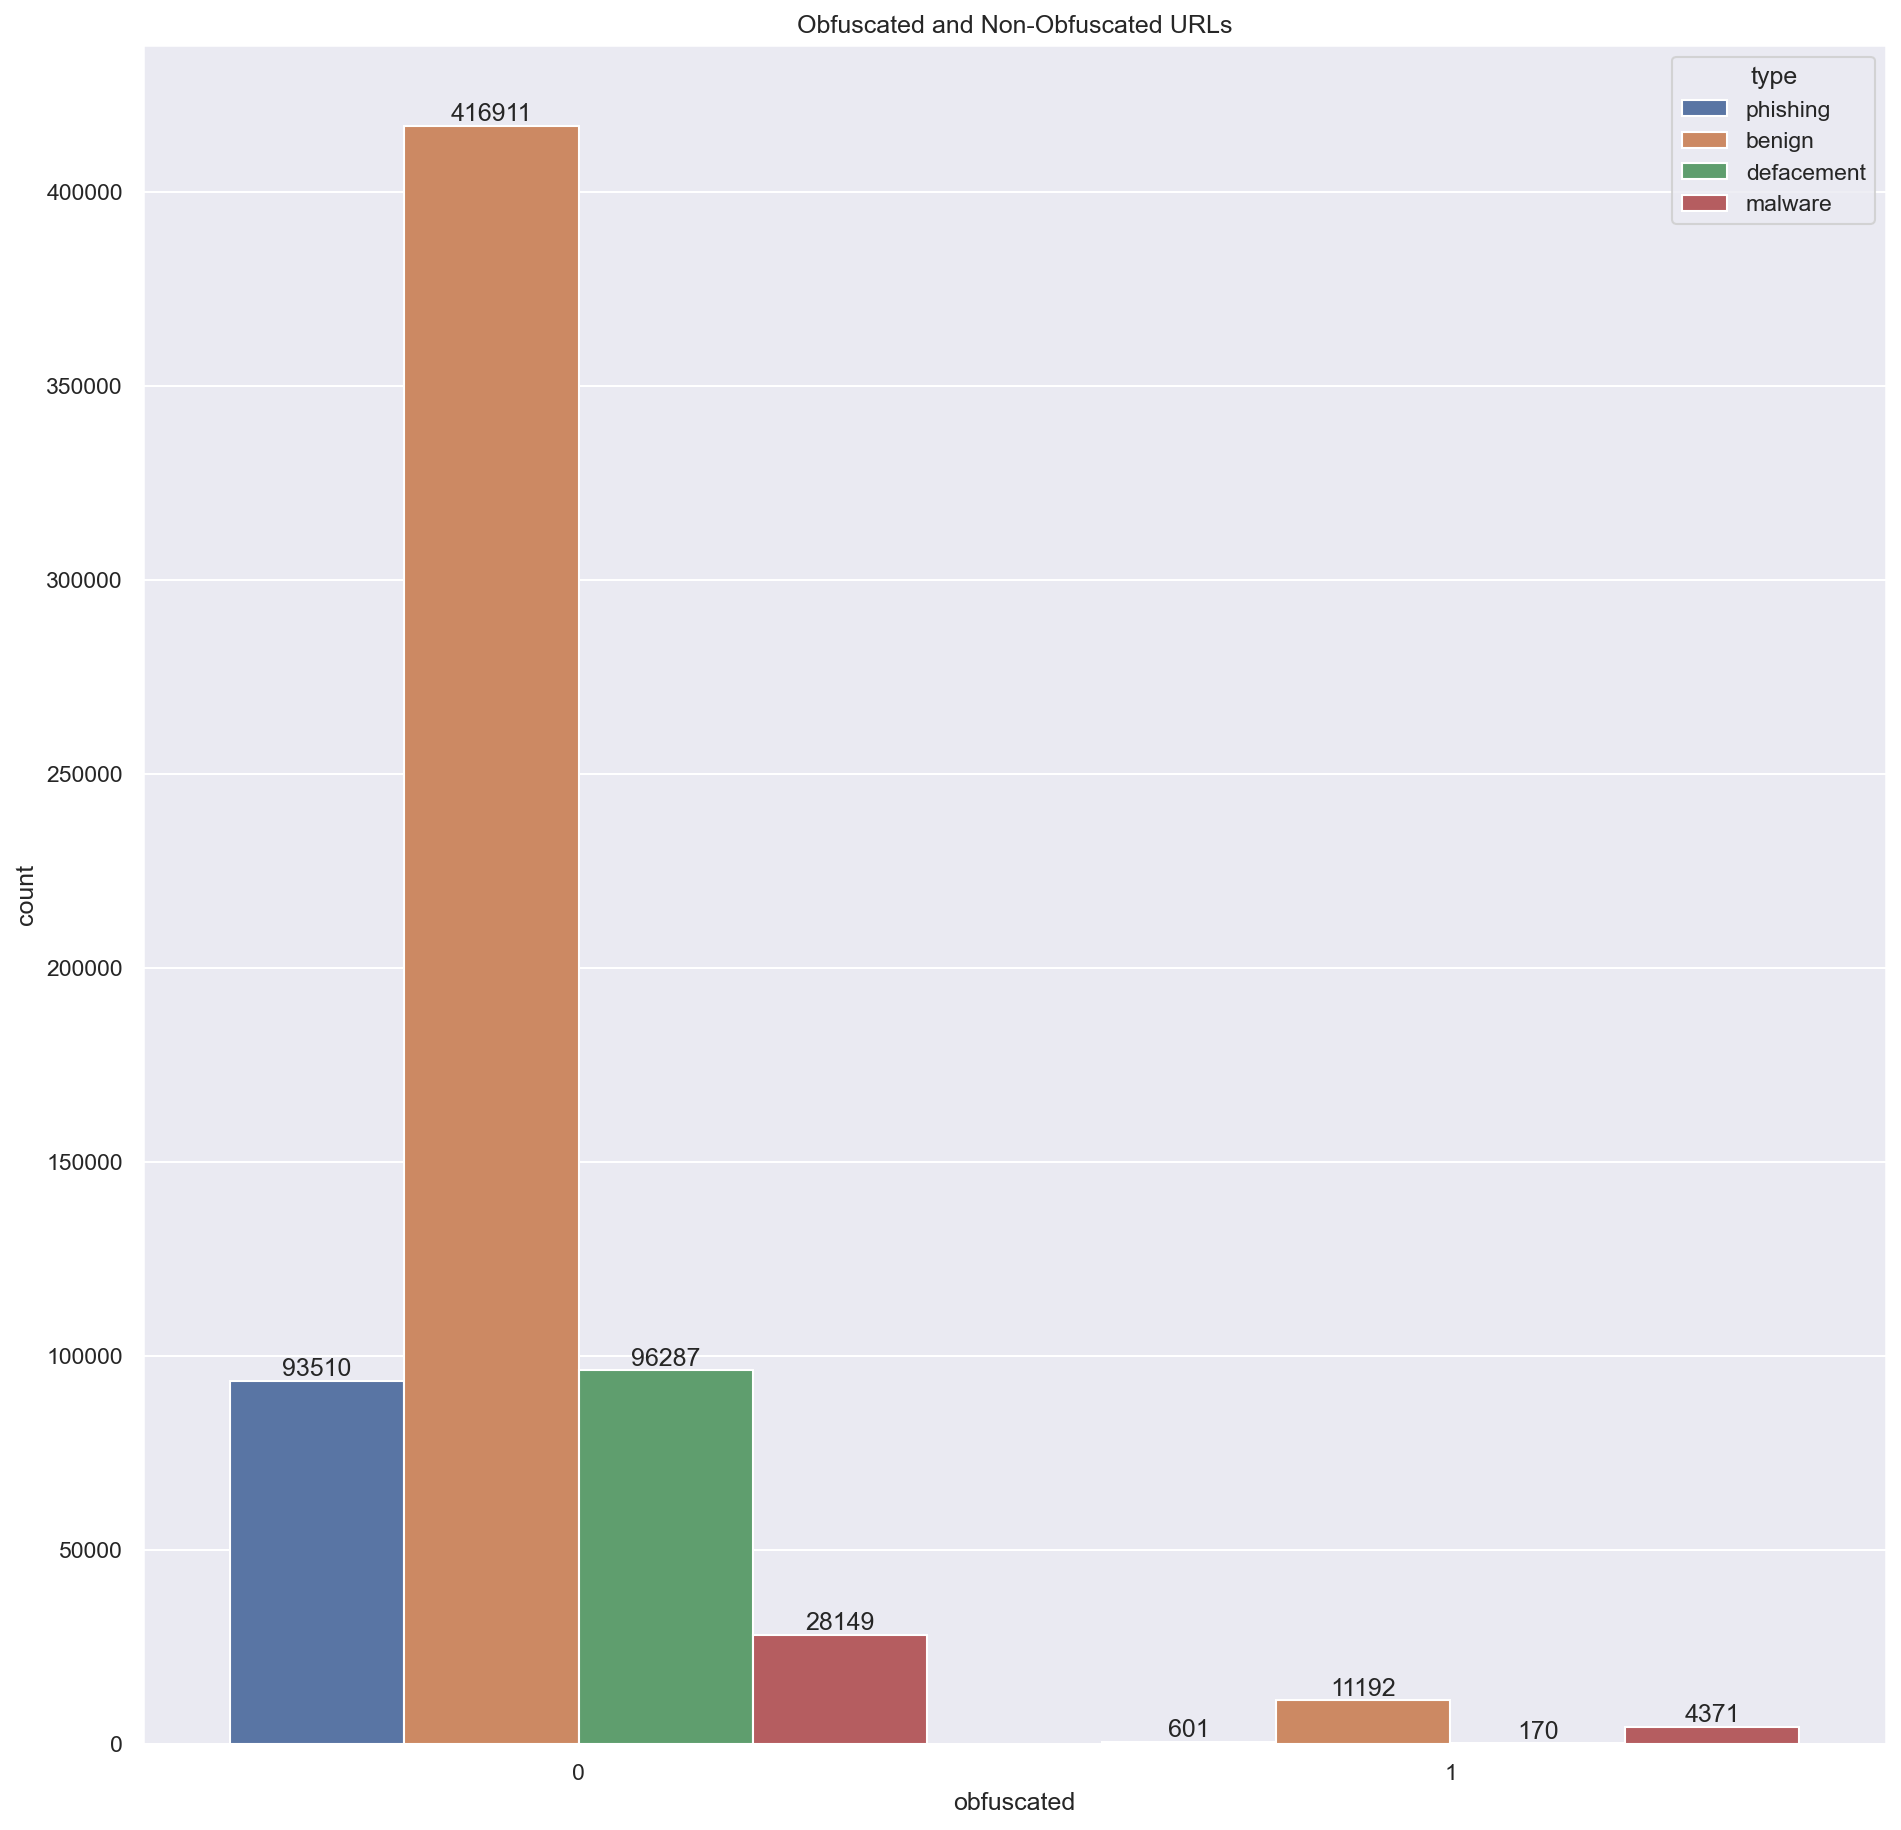

In [96]:
# Countplot to see how many are/could be obfuscated in each type cateogory (i.e. contains a %).
# It is clear that some benign sites do contain %, so this should be kept in mind.
# As has already been shown, malware URLs seem to have more % than the other categories of malicious URL:

fig, ax = plt.subplots(dpi=150)

sns.set(rc = {'figure.figsize':(15, 40)})
sns.set_style('darkgrid')
ax.set_title("Obfuscated and Non-Obfuscated URLs")
ax.set_xlabel("Obfuscated (1) and Non-Obfuscated(0)")
ax.set_ylabel("Total URLs")

sns.countplot(x='obfuscated', hue='type', data=all_urls_data)

for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f')

fig.savefig('obfuscated_countplot.png')

## Create Dummy Variables

In [97]:
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report 
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import column_or_1d

In [98]:
# Unnecessary columns are dropped:

all_urls_data = all_urls_data.drop('url', axis=1)
all_urls_data = all_urls_data.drop('path', axis=1)
all_urls_data = all_urls_data.drop('params', axis=1)

all_urls_data.head()

type scheme                   netloc  \
0    phishing    NaN                      NaN   
1      benign    NaN                      NaN   
2      benign    NaN                      NaN   
3  defacement   http        garage-pirenne.be   
4  defacement   http  adventure-nicaragua.net   

                                               query fragment  \
0                                                NaN      NaN   
1                                                NaN      NaN   
2                                                NaN      NaN   
3  option=com_content&view=article&id=70&vsig70_0=15      NaN   
4  option=com_mailto&tmpl=component&link=aHR0cDov...      NaN   

                                     directories  \
0                           ['br-icloud.com.br']   
1  ['mp3raid.com', 'music', 'krizz_kaliko.html']   
2   ['bopsecrets.org', 'rexroth', 'cr', '1.htm']   
3                                  ['index.php']   
4                                  ['index.php']   

                                             queries  url_length  obfuscated  
0                                               ['']          16           0  
1                                               ['']          35           0  
2                                               ['']          31           0  
3  ['option=com_content', 'view=article', 'id=70'...          88           0  
4  ['option=com_mailto', 'tmpl=component', 'link=...         235           0

In [99]:
# Categorical variables are converted into numerical variables:

le = LabelEncoder()
all_urls_data['type_num'] = le.fit_transform(all_urls_data['type'])
all_urls_data['scheme_num'] = le.fit_transform(all_urls_data['scheme'])
all_urls_data['netloc_num'] = le.fit_transform(all_urls_data['netloc'])

all_urls_data.head()

type scheme                   netloc  \
0    phishing    NaN                      NaN   
1      benign    NaN                      NaN   
2      benign    NaN                      NaN   
3  defacement   http        garage-pirenne.be   
4  defacement   http  adventure-nicaragua.net   

                                               query fragment  \
0                                                NaN      NaN   
1                                                NaN      NaN   
2                                                NaN      NaN   
3  option=com_content&view=article&id=70&vsig70_0=15      NaN   
4  option=com_mailto&tmpl=component&link=aHR0cDov...      NaN   

                                     directories  \
0                           ['br-icloud.com.br']   
1  ['mp3raid.com', 'music', 'krizz_kaliko.html']   
2   ['bopsecrets.org', 'rexroth', 'cr', '1.htm']   
3                                  ['index.php']   
4                                  ['index.php']   

                                             queries  url_length  obfuscated  \
0                                               ['']          16           0   
1                                               ['']          35           0   
2                                               ['']          31           0   
3  ['option=com_content', 'view=article', 'id=70'...          88           0   
4  ['option=com_mailto', 'tmpl=component', 'link=...         235           0   

   type_num  scheme_num  netloc_num  
0         3          71       21520  
1         0          71       21520  
2         0          71       21520  
3         1          34       11312  
4         1          34        6254

In [100]:
all_urls_data['dirs_num'] = le.fit_transform(all_urls_data['directories'])

all_urls_data.head()

type scheme                   netloc  \
0    phishing    NaN                      NaN   
1      benign    NaN                      NaN   
2      benign    NaN                      NaN   
3  defacement   http        garage-pirenne.be   
4  defacement   http  adventure-nicaragua.net   

                                               query fragment  \
0                                                NaN      NaN   
1                                                NaN      NaN   
2                                                NaN      NaN   
3  option=com_content&view=article&id=70&vsig70_0=15      NaN   
4  option=com_mailto&tmpl=component&link=aHR0cDov...      NaN   

                                     directories  \
0                           ['br-icloud.com.br']   
1  ['mp3raid.com', 'music', 'krizz_kaliko.html']   
2   ['bopsecrets.org', 'rexroth', 'cr', '1.htm']   
3                                  ['index.php']   
4                                  ['index.php']   

                                             queries  url_length  obfuscated  \
0                                               ['']          16           0   
1                                               ['']          35           0   
2                                               ['']          31           0   
3  ['option=com_content', 'view=article', 'id=70'...          88           0   
4  ['option=com_mailto', 'tmpl=component', 'link=...         235           0   

   type_num  scheme_num  netloc_num  dirs_num  
0         3          71       21520     70013  
1         0          71       21520    283100  
2         0          71       21520     69294  
3         1          34       11312    221674  
4         1          34        6254    221674

In [101]:
all_urls_data['queries_num'] = le.fit_transform(all_urls_data['queries'])

all_urls_data.head()

type scheme                   netloc  \
0    phishing    NaN                      NaN   
1      benign    NaN                      NaN   
2      benign    NaN                      NaN   
3  defacement   http        garage-pirenne.be   
4  defacement   http  adventure-nicaragua.net   

                                               query fragment  \
0                                                NaN      NaN   
1                                                NaN      NaN   
2                                                NaN      NaN   
3  option=com_content&view=article&id=70&vsig70_0=15      NaN   
4  option=com_mailto&tmpl=component&link=aHR0cDov...      NaN   

                                     directories  \
0                           ['br-icloud.com.br']   
1  ['mp3raid.com', 'music', 'krizz_kaliko.html']   
2   ['bopsecrets.org', 'rexroth', 'cr', '1.htm']   
3                                  ['index.php']   
4                                  ['index.php']   

                                             queries  url_length  obfuscated  \
0                                               ['']          16           0   
1                                               ['']          35           0   
2                                               ['']          31           0   
3  ['option=com_content', 'view=article', 'id=70'...          88           0   
4  ['option=com_mailto', 'tmpl=component', 'link=...         235           0   

   type_num  scheme_num  netloc_num  dirs_num  queries_num  
0         3          71       21520     70013          561  
1         0          71       21520    283100          561  
2         0          71       21520     69294          561  
3         1          34       11312    221674        51382  
4         1          34        6254    221674        60914

In [102]:
# The end part (i.e. region) of the domains is extracted into a new column:

all_urls_data['netloc_region'] = all_urls_data['netloc'].str.extract(r'(\w*$)')

all_urls_data.head(50)

type scheme                        netloc  \
0     phishing    NaN                           NaN   
1       benign    NaN                           NaN   
2       benign    NaN                           NaN   
3   defacement   http             garage-pirenne.be   
4   defacement   http       adventure-nicaragua.net   
5       benign   http                   buzzfil.net   
6       benign    NaN                           NaN   
7       benign    NaN                           NaN   
8   defacement   http            pashminaonline.com   
9       benign    NaN                           NaN   
10      benign    NaN                           NaN   
11  defacement   http              ikenmijnkunst.nl   
12      benign    NaN                           NaN   
13  defacement   http  lebensmittel-ueberwachung.de   
14  defacement   http             szabadmunkaero.hu   
15  defacement   http         larcadelcarnevale.com   
16      benign    NaN                           NaN   
17      benign    NaN                           NaN   
18      benign    NaN                           NaN   
19  defacement   http                       vnic.co   
20      benign    NaN                           NaN   
21    phishing    NaN                           NaN   
22      benign    NaN                           NaN   
23      benign    NaN                           NaN   
24      benign    NaN                           NaN   
25      benign    NaN                           NaN   
26      benign    NaN                           NaN   
27      benign   http             hollywoodlife.com   
28    phishing   http       marketingbyinternet.com   
29      benign    NaN                           NaN   
30      benign    NaN                           NaN   
31      benign    NaN                           NaN   
32      benign    NaN                           NaN   
33      benign    NaN                           NaN   
34      benign    NaN                           NaN   
35  defacement   http         peluqueriadeautor.com   
36      benign    NaN                           NaN   
37      benign    NaN                           NaN   
38     malware   http                    824555.com   
39  defacement   http                       raci.it   
40    phishing  https               docs.google.com   
41      benign    NaN                           NaN   
42      benign    NaN                           NaN   
43      benign    NaN                           NaN   
44      benign    NaN                           NaN   
45      benign    NaN                           NaN   
46  defacement   http                earth-sure.com   
47      benign    NaN                           NaN   
48      benign    NaN                           NaN   
49      benign   http                 interpark.com   

                                                query fragment  \
0                                                 NaN      NaN   
1                                                 NaN      NaN   
2                                                 NaN      NaN   
3   option=com_content&view=article&id=70&vsig70_0=15      NaN   
4   option=com_mailto&tmpl=component&link=aHR0cDov...      NaN   
5                                                 NaN      NaN   
6                                                 NaN      NaN   
7                          q=anthony-hamilton-soulife      NaN   
8                                                 NaN      NaN   
9                                                 NaN      NaN   
10                                                NaN      NaN   
11                                                NaN      NaN   
12                                                NaN      NaN   
13                                                NaN      NaN   
14                                           start=12      NaN   
15                                                NaN      NaN   
16                                                NaN      NaN   
17              

In [103]:
# The netloc_region column is then converted into a numerical value:

all_urls_data['netloc_region_num'] = le.fit_transform(all_urls_data['netloc_region'])

all_urls_data.head()

type scheme                   netloc  \
0    phishing    NaN                      NaN   
1      benign    NaN                      NaN   
2      benign    NaN                      NaN   
3  defacement   http        garage-pirenne.be   
4  defacement   http  adventure-nicaragua.net   

                                               query fragment  \
0                                                NaN      NaN   
1                                                NaN      NaN   
2                                                NaN      NaN   
3  option=com_content&view=article&id=70&vsig70_0=15      NaN   
4  option=com_mailto&tmpl=component&link=aHR0cDov...      NaN   

                                     directories  \
0                           ['br-icloud.com.br']   
1  ['mp3raid.com', 'music', 'krizz_kaliko.html']   
2   ['bopsecrets.org', 'rexroth', 'cr', '1.htm']   
3                                  ['index.php']   
4                                  ['index.php']   

                                             queries  url_length  obfuscated  \
0                                               ['']          16           0   
1                                               ['']          35           0   
2                                               ['']          31           0   
3  ['option=com_content', 'view=article', 'id=70'...          88           0   
4  ['option=com_mailto', 'tmpl=component', 'link=...         235           0   

   type_num  scheme_num  netloc_num  dirs_num  queries_num netloc_region  \
0         3          71       21520     70013          561           NaN   
1         0          71       21520    283100          561           NaN   
2         0          71       21520     69294          561           NaN   
3         1          34       11312    221674        51382            be   
4         1          34        6254    221674        60914           net   

   netloc_region_num  
0               4343  
1               4343  
2               4343  
3               4109  
4               4242

In [104]:
all_urls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   type               651191 non-null  object
 1   scheme             188182 non-null  object
 2   netloc             187999 non-null  object
 3   query              139973 non-null  object
 4   fragment           461 non-null     object
 5   directories        651191 non-null  object
 6   queries            651191 non-null  object
 7   url_length         651191 non-null  int64 
 8   obfuscated         651191 non-null  int64 
 9   type_num           651191 non-null  int64 
 10  scheme_num         651191 non-null  int64 
 11  netloc_num         651191 non-null  int64 
 12  dirs_num           651191 non-null  int64 
 13  queries_num        651191 non-null  int64 
 14  netloc_region      187999 non-null  object
 15  netloc_region_num  651191 non-null  int64 
dtypes: int64(8), object(

In [105]:
# Drop unneeded object columns to keep only numerical columns for model building:

all_urls_data = all_urls_data.drop('type', axis=1)
all_urls_data = all_urls_data.drop('scheme', axis=1)
all_urls_data = all_urls_data.drop('netloc', axis=1)
all_urls_data = all_urls_data.drop('query', axis=1)
all_urls_data = all_urls_data.drop('fragment', axis=1)
all_urls_data = all_urls_data.drop('directories', axis=1)
all_urls_data = all_urls_data.drop('queries', axis=1)
all_urls_data = all_urls_data.drop('netloc_region', axis=1)

all_urls_data.head()

url_length  obfuscated  type_num  scheme_num  netloc_num  dirs_num  \
0          16           0         3          71       21520     70013   
1          35           0         0          71       21520    283100   
2          31           0         0          71       21520     69294   
3          88           0         1          34       11312    221674   
4         235           0         1          34        6254    221674   

   queries_num  netloc_region_num  
0          561               4343  
1          561               4343  
2          561               4343  
3        51382               4109  
4        60914               4242

## Check Data for Multicolinearity

In [106]:
# Check the train data set for multicolinearity.
# Apply VIF.
# Set the variables:
X = all_urls_data.drop('type_num', axis = 1)
y = all_urls_data['type_num']

# Import the VIF package.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a VIF dataframe.
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
  
# Calculate VIF for each feature.
vif_data['VIF'] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

# View the DataFrame.
vif_data.sort_values('VIF',ascending=True)

# Features scoring below 5 do not have correlation issues and are possibly good predictors.  Those scoring
# above 5 are strongly correlated; perhaps not surprising, given that they are drawn from the other variables 
# and potentially do not differ greatly between URL types.

feature        VIF
1         obfuscated   1.077910
5        queries_num   1.406307
0         url_length   3.487150
4           dirs_num   4.010386
6  netloc_region_num  34.733869
2         scheme_num  45.015878
3         netloc_num  58.566081

## Balance the Data

In [107]:
# Earlier visualisation of the data showed that it is not balanced.

# Apply SMOTE class as the target variable is not balanced and split the data set into test and train sets:
os = SMOTE(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

# Specify the new data sets.
os_data_X, os_data_y = os.fit_resample(X, y)  

# Create two DataFrames; one for X and one for y:
os_data_X = pd.DataFrame(data = os_data_X, columns = X.columns) 

os_data_y = pd.DataFrame(data = os_data_y, columns = ['type_num'])

# View DataFrame.
print(os_data_X.head())


   url_length  obfuscated  scheme_num  netloc_num  dirs_num  queries_num  \
0          16           0          71       21520     70013          561   
1          35           0          71       21520    283100          561   
2          31           0          71       21520     69294          561   
3          88           0          34       11312    221674        51382   
4         235           0          34        6254    221674        60914   

   netloc_region_num  
0               4343  
1               4343  
2               4343  
3               4109  
4               4242  


In [108]:
# Determine if data set is balanced:
print(os_data_y['type_num'].value_counts())

# The data set is now balanced.

3    428103
0    428103
1    428103
2    428103
Name: type_num, dtype: int64


# Create Decision Tree Model

In [109]:
# Import necessary package:
from sklearn.tree import DecisionTreeClassifier 

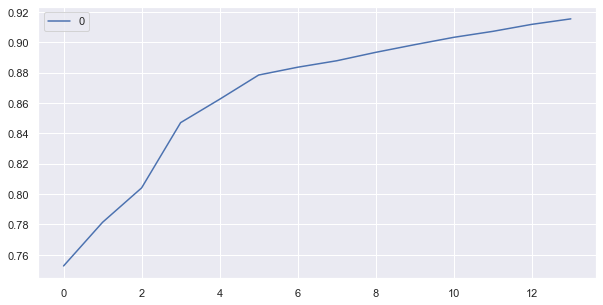

In [110]:
# Determine the optimal value for max depth, then prune the decision tree:

# List of values to try for max_depth:
max_depth_range = list(range(1, 15))

# Generate a loop that fits decision trees for different 'max_depth', and calculate/store the accuracy of each 
# tree:
accuracy = []
for depth in max_depth_range:    
    dtc = DecisionTreeClassifier(max_depth = depth, random_state = 42)
    dtc.fit(X, y)
    score = dtc.score(X, y)
    accuracy.append(score)
    
# Plot accuracy values across the range of depth values evaluated:
plt.rcParams['figure.figsize'] = [10, 5]
accuracy = pd.DataFrame(accuracy)
accuracy.plot()
plt.show()

In [111]:
# The tree depth, based on the chart, will be set at 5:

# Create a Decision Tree classifer object:
dtc2 = DecisionTreeClassifier(criterion='gini',
                             max_depth=5,
                             random_state=42)

# Train the Decision Tree Classifer:
dtc2 = dtc2.fit(X, y)

# Predict the response for the test data set:
y_pred = dtc2.predict(X_test)

In [112]:
# Import necessary packages.
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

# Indicate the confusion matrix needs to be created:
confusion_matrix = confusion_matrix(y_test, y_pred)

confusion = pd.DataFrame(confusion_matrix, index=['is_benign', 'is_defacement', 'is_malware', 'is_phishing'],
                         columns=['predicted_benign', 'predicted_defacement', 'predicted_malware'
                                  , 'predicted_phishing'])

# View the output:
confusion

predicted_benign  predicted_defacement  predicted_malware  \
is_benign                126393                   476                  2   
is_defacement              2893                 25686                 89   
is_malware                 1081                  1610               6944   
is_phishing               13713                  3664               1363   

               predicted_phishing  
is_benign                    1862  
is_defacement                  24  
is_malware                     64  
is_phishing                  9494

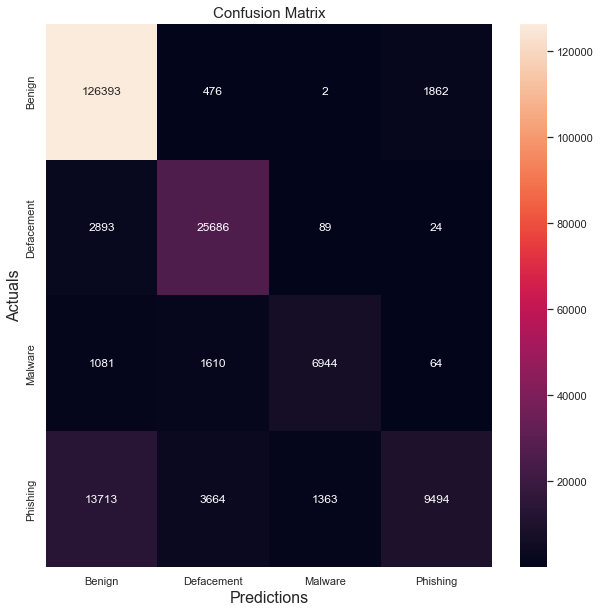

In [113]:
# Plot the confusion_matrix using Seaborn:

fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(False)

sns.heatmap(confusion_matrix, annot=True, fmt='g')

ax.set_xticklabels(['Benign', 'Defacement', 'Malware', 'Phishing'])
ax.set_yticklabels(['Benign', 'Defacement', 'Malware', 'Phishing'])
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)

fig.savefig('dt_confusion_matrix.png')

In [114]:
# Print the accuracy and classification report:

print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8626060872859058
              precision    recall  f1-score   support

           0       0.88      0.98      0.93    128733
           1       0.82      0.90      0.85     28692
           2       0.83      0.72      0.77      9699
           3       0.83      0.34      0.48     28234

    accuracy                           0.86    195358
   macro avg       0.84      0.73      0.76    195358
weighted avg       0.86      0.86      0.84    195358



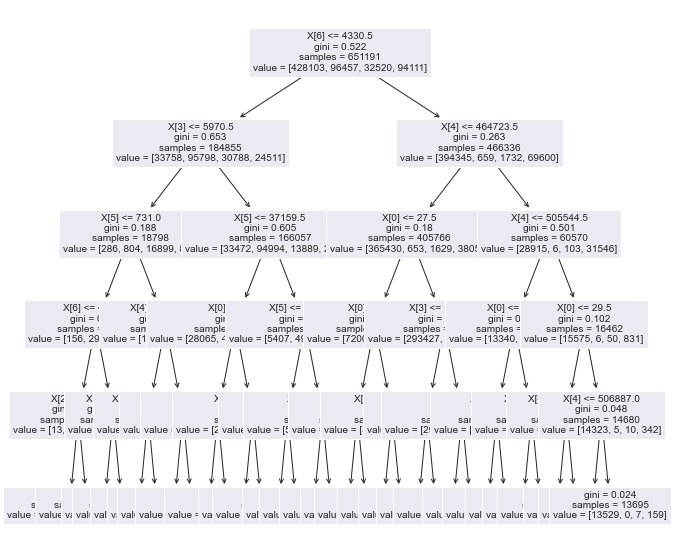

In [115]:
# Import matplotlib to create a visualisation and the tree package from sklearn:
import matplotlib.pyplot as plt 
from sklearn import tree

# Plot the decision tree to create the visualisation:
fig, ax = plt.subplots(figsize=(10, 10))
tree.plot_tree(dtc2, fontsize=10)

# Print the plot with plt.show():
plt.show() 

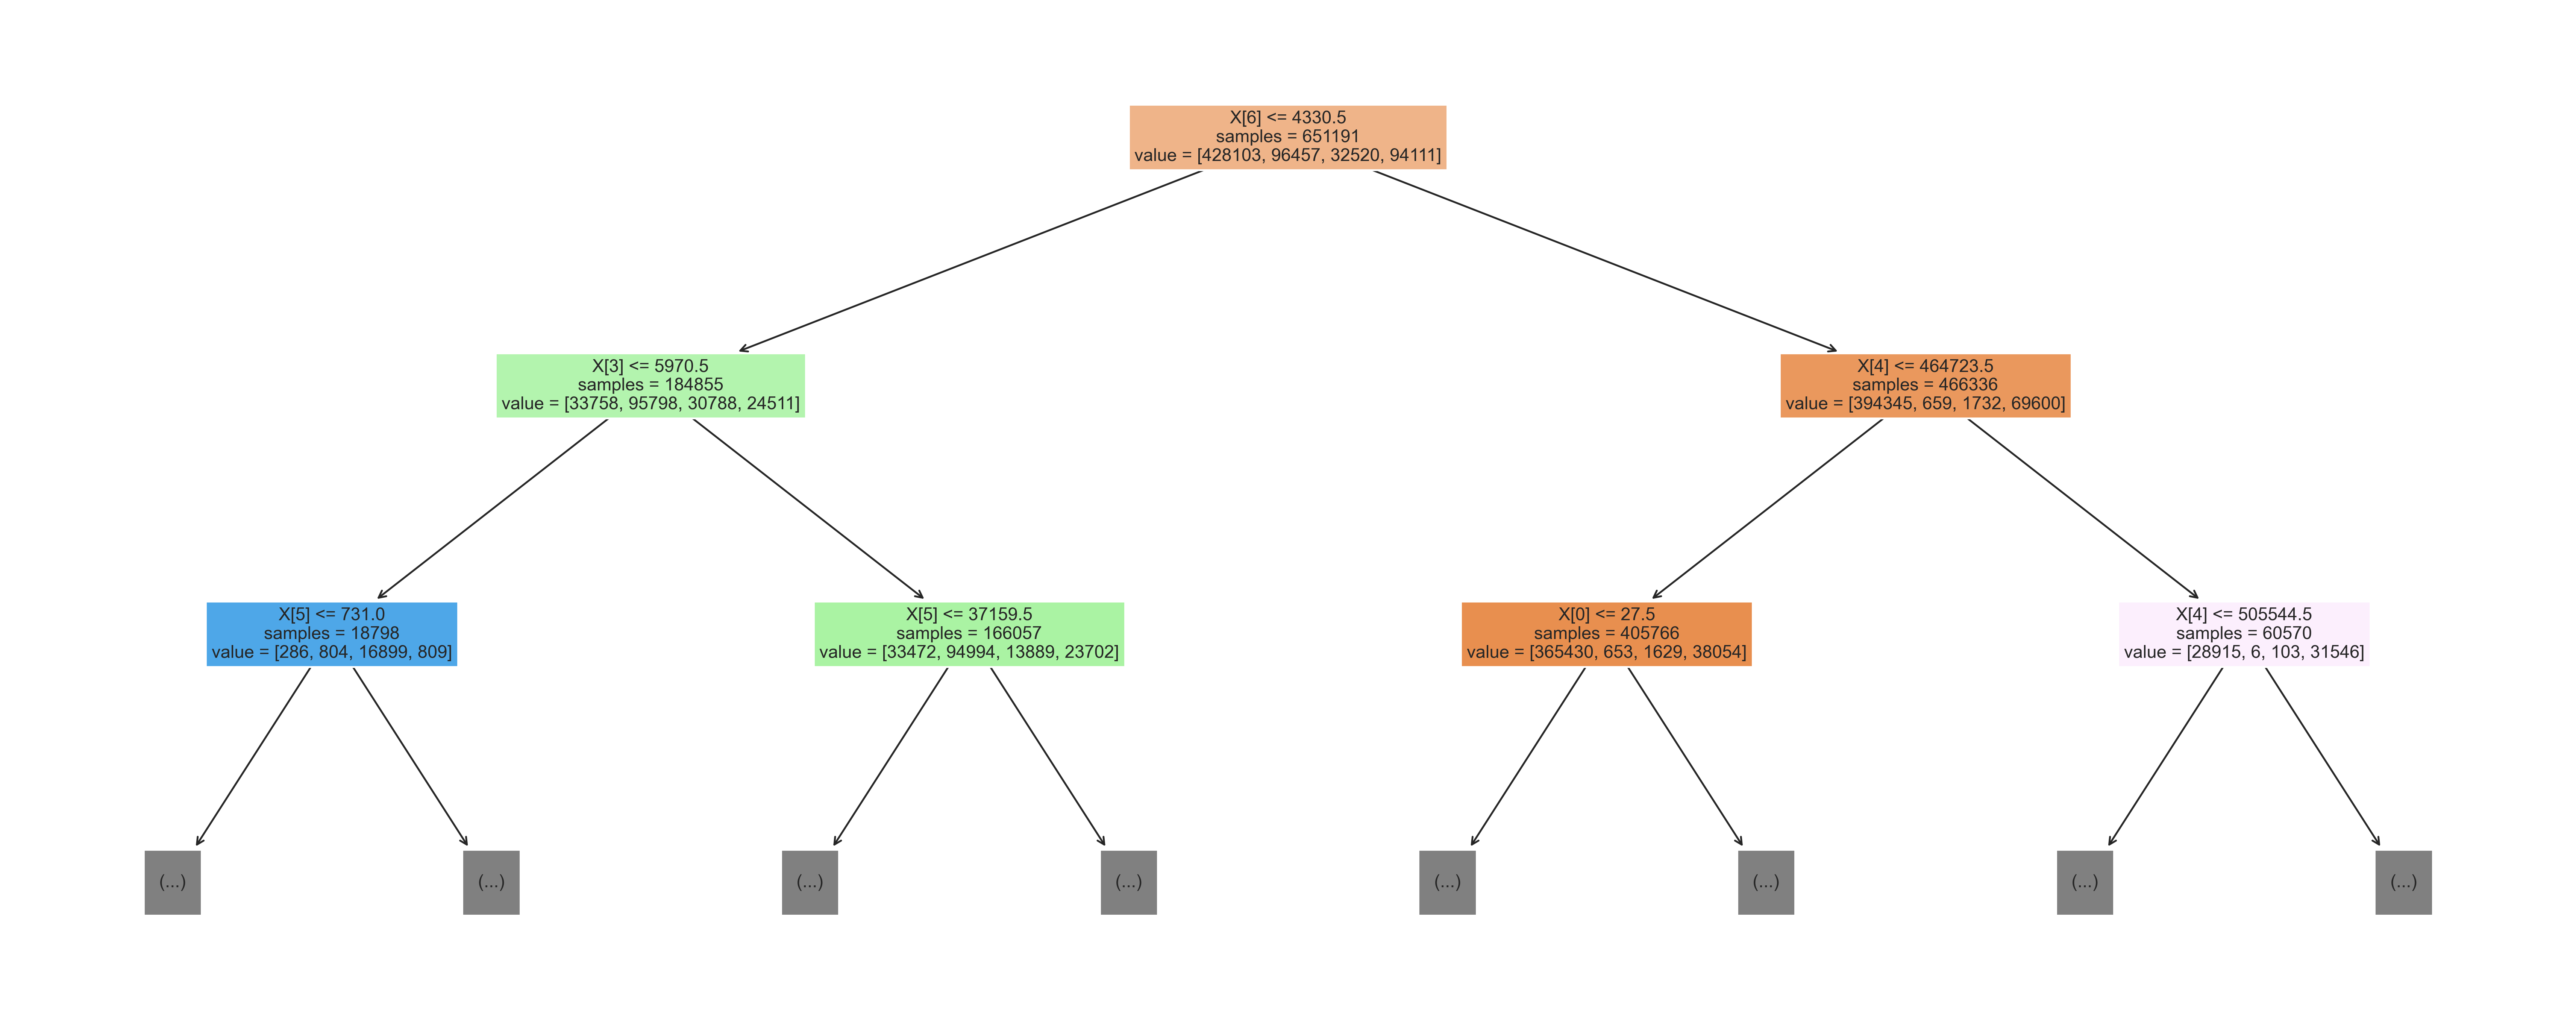

In [116]:
# Plot the decision tree, displaying only the top levels. Note that this is only for display/visualisation:

plt.figure(figsize=[25,10], dpi=350)
tree.plot_tree(dtc2, max_depth=2, impurity=False, filled = True)

# plot_tree(dtc2):
plt.show()

## Conclusion

The model has an accuracy of 86%, using a depth of 5.
The precision score implies that the model is quite effective at making positive predictions, although the recall score suggests it is much better at correctly predicting positive cases of benign or defacement sites than malware or phishing sites.
The F1-score therefore overall shows that the model is quite good at predicting benign or defacement sites, but not too reliable at predicting phishing sites, with less than 50% accuracy.

# Create Multinomial Logistic Regression Model

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler 

In [118]:
# Create a function and set values:
scaler = MinMaxScaler(feature_range = (0, 1))  

# Add the X_train data set to the 'scaler' function:
scaler.fit(X_train)

# Specify X_train data set:
X_train = scaler.transform(X_train) 
# Specify X_test data set: 
X_test = scaler.transform(X_test)

# Define the MLR model and set predictions and parameters:
MLR = LogisticRegression(random_state=42, 
                         multi_class='multinomial', 
                         penalty='none', 
                         solver='newton-cg').fit(X_train, y_train)

# Set the predictions equal to the ‘MLR’ function and specify the DataFrame:
preds = MLR.predict(X_test) 

# Set the parameters equal to the DataFrame and add the ‘get_params’ function: 
params = MLR.get_params() 

# Print the parameters, intercept, and coefficients:
print(params)  
print("Intercept: \n", MLR.intercept_)
print("Coefficients: \n", MLR.coef_)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'none', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Intercept: 
 [-35.97023702  45.07816288  -0.41785494  -8.69007091]
Coefficients: 
 [[ 4.57031142e+01  9.72908039e-01  3.89104344e+01  1.55562146e+00
  -1.24917784e+00 -6.97249879e-01  1.56310583e+01]
 [-9.80253962e+00 -2.89827769e+00 -1.04836325e+02  6.95211897e-02
  -6.70346831e-02  2.53940482e+00  6.65653952e+00]
 [-3.63193325e+01  2.44497732e+00  2.96775874e+01 -1.60903286e+00
   2.21496718e-01  6.04543016e-01 -1.27788629e+01]
 [ 4.18757912e-01 -5.19607676e-01  3.62483036e+01 -1.61097909e-02
   1.09471581e+00 -2.44669796e+00 -9.50873490e+00]]


In [119]:
# Name the model and set the model to the function.
# Use the add_constant() function to determine the value of y when X=0:
logit_model = sm.MNLogit(y_train, sm.add_constant(X_train))

# Specify how the function returns the results:
result = logit_model.fit()  

# Print the report as a result.summary() function: 
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.532400
         Iterations 14
                          MNLogit Regression Results                          
Dep. Variable:               type_num   No. Observations:               455833
Model:                        MNLogit   Df Residuals:                   455809
Method:                           MLE   Df Model:                           21
Date:                Fri, 27 Oct 2023   Pseudo R-squ.:                  0.4617
Time:                        12:38:23   Log-Likelihood:            -2.4269e+05
converged:                       True   LL-Null:                   -4.5080e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
type_num=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.0484      1.126     71.995      0.000      78.842      83.255
x1           -55.5057      0

In [120]:
# Import necessary packages:
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

# Create and print a confusion matrix: 
confusion_matrix(y_test, preds)

# Transform confusion matrix into an array:
cmatrix = np.array(confusion_matrix(y_test, preds))

# Create the DataFrame from cmatrix array: 
pd.DataFrame(cmatrix, index=['is_benign', 'is_defacement', 'is_malware', 'is_phishing'],
                         columns=['predicted_benign', 'predicted_defacement', 'predicted_malware'
                                  , 'predicted_phishing'])

predicted_benign  predicted_defacement  predicted_malware  \
is_benign                121087                  7068                450   
is_defacement              1218                 27459                 12   
is_malware                  649                  2535               4908   
is_phishing               22317                  4648                604   

               predicted_phishing  
is_benign                     128  
is_defacement                   3  
is_malware                   1607  
is_phishing                   665

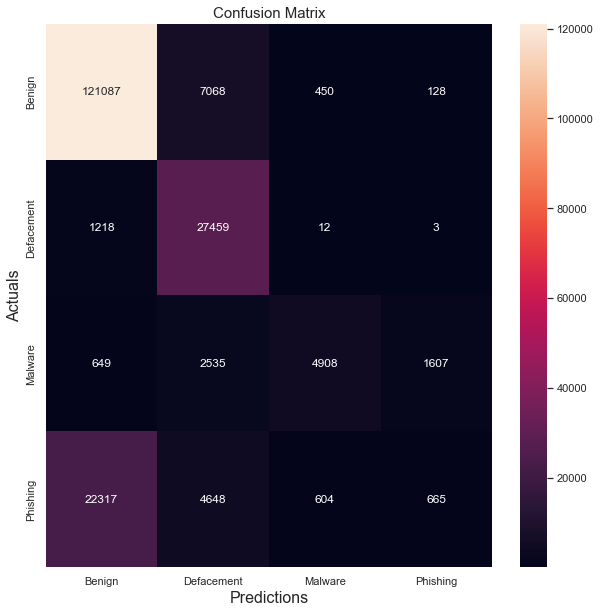

In [121]:
# Plot the confusion_matrix:
fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(False)

sns.heatmap(cmatrix, annot=True, fmt='g')

ax.set_xticklabels(['Benign', 'Defacement', 'Malware', 'Phishing'])
ax.set_yticklabels(['Benign', 'Defacement', 'Malware', 'Phishing'])
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)

fig.savefig('mlr_confusion_matrix.png')

In [122]:
# Determine accuracy statistics:
print('Accuracy score:', metrics.accuracy_score(y_test, preds))  

# Create classification report:
class_report=classification_report(y_test, preds)

print(class_report)

Accuracy score: 0.7889054965755178
              precision    recall  f1-score   support

           0       0.83      0.94      0.88    128733
           1       0.66      0.96      0.78     28692
           2       0.82      0.51      0.63      9699
           3       0.28      0.02      0.04     28234

    accuracy                           0.79    195358
   macro avg       0.65      0.61      0.58    195358
weighted avg       0.73      0.79      0.73    195358



## Conclusion

The model has an accuracy score of 79%, not quite as good as the Decision Tree Model.  It has an 83% chance of predicting benign URLs and an 82% chance of predicting a malware URL, but a very low chance of correctly identifying a phishing URL.

# Create a Random Forest Classifier Model

In [123]:
from sklearn.ensemble import RandomForestClassifier

In [124]:
# Create a forest object based on the 'RandomForestClassifier':
forest = RandomForestClassifier(n_estimators=200, 
                                criterion = 'gini', 
                                min_samples_split = 2,
                                min_samples_leaf = 2,
                                max_features = 'auto',
                                bootstrap = True,
                                n_jobs = -1,
                                random_state = 42)

# Train and predict the model:
forest.fit(X_train, y_train)
y_predict = forest.predict(X_test)


In [125]:
# Import necessary packages:
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

# Create and print a confusion matrix: 
confusion_matrix(y_test, y_predict)

# Transform confusion matrix into an array:
cmatrix_rf = np.array(confusion_matrix(y_test, y_predict))

# Create the DataFrame from cmatrix array: 
pd.DataFrame(cmatrix_rf, index=['is_benign', 'is_defacement', 'is_malware', 'is_phishing'],
                         columns=['predicted_benign', 'predicted_defacement', 'predicted_malware'
                                  , 'predicted_phishing'])

predicted_benign  predicted_defacement  predicted_malware  \
is_benign                124893                    35                 15   
is_defacement               112                 28453                 14   
is_malware                  331                   193               8903   
is_phishing                7971                  1160                 77   

               predicted_phishing  
is_benign                    3790  
is_defacement                 113  
is_malware                    272  
is_phishing                 19026

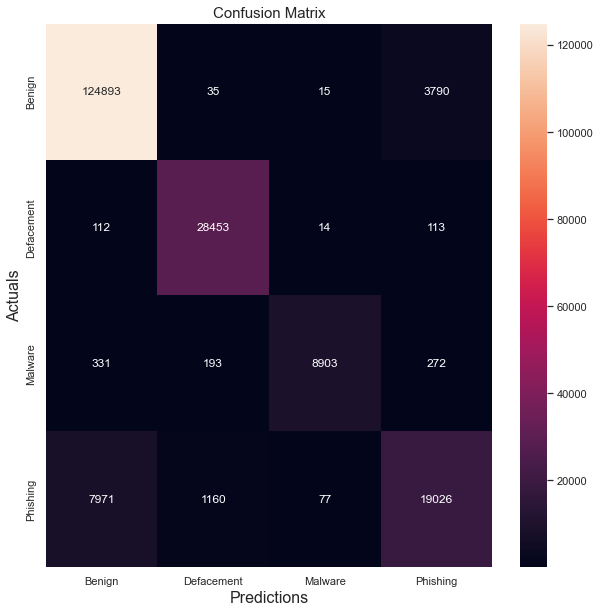

In [126]:
# Plot the confusion_matrix:
fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(False)

sns.heatmap(cmatrix_rf, annot=True, fmt='g')

ax.set_xticklabels(['Benign', 'Defacement', 'Malware', 'Phishing'])
ax.set_yticklabels(['Benign', 'Defacement', 'Malware', 'Phishing'])
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)

fig.savefig('rf_confusion_matrix.png')

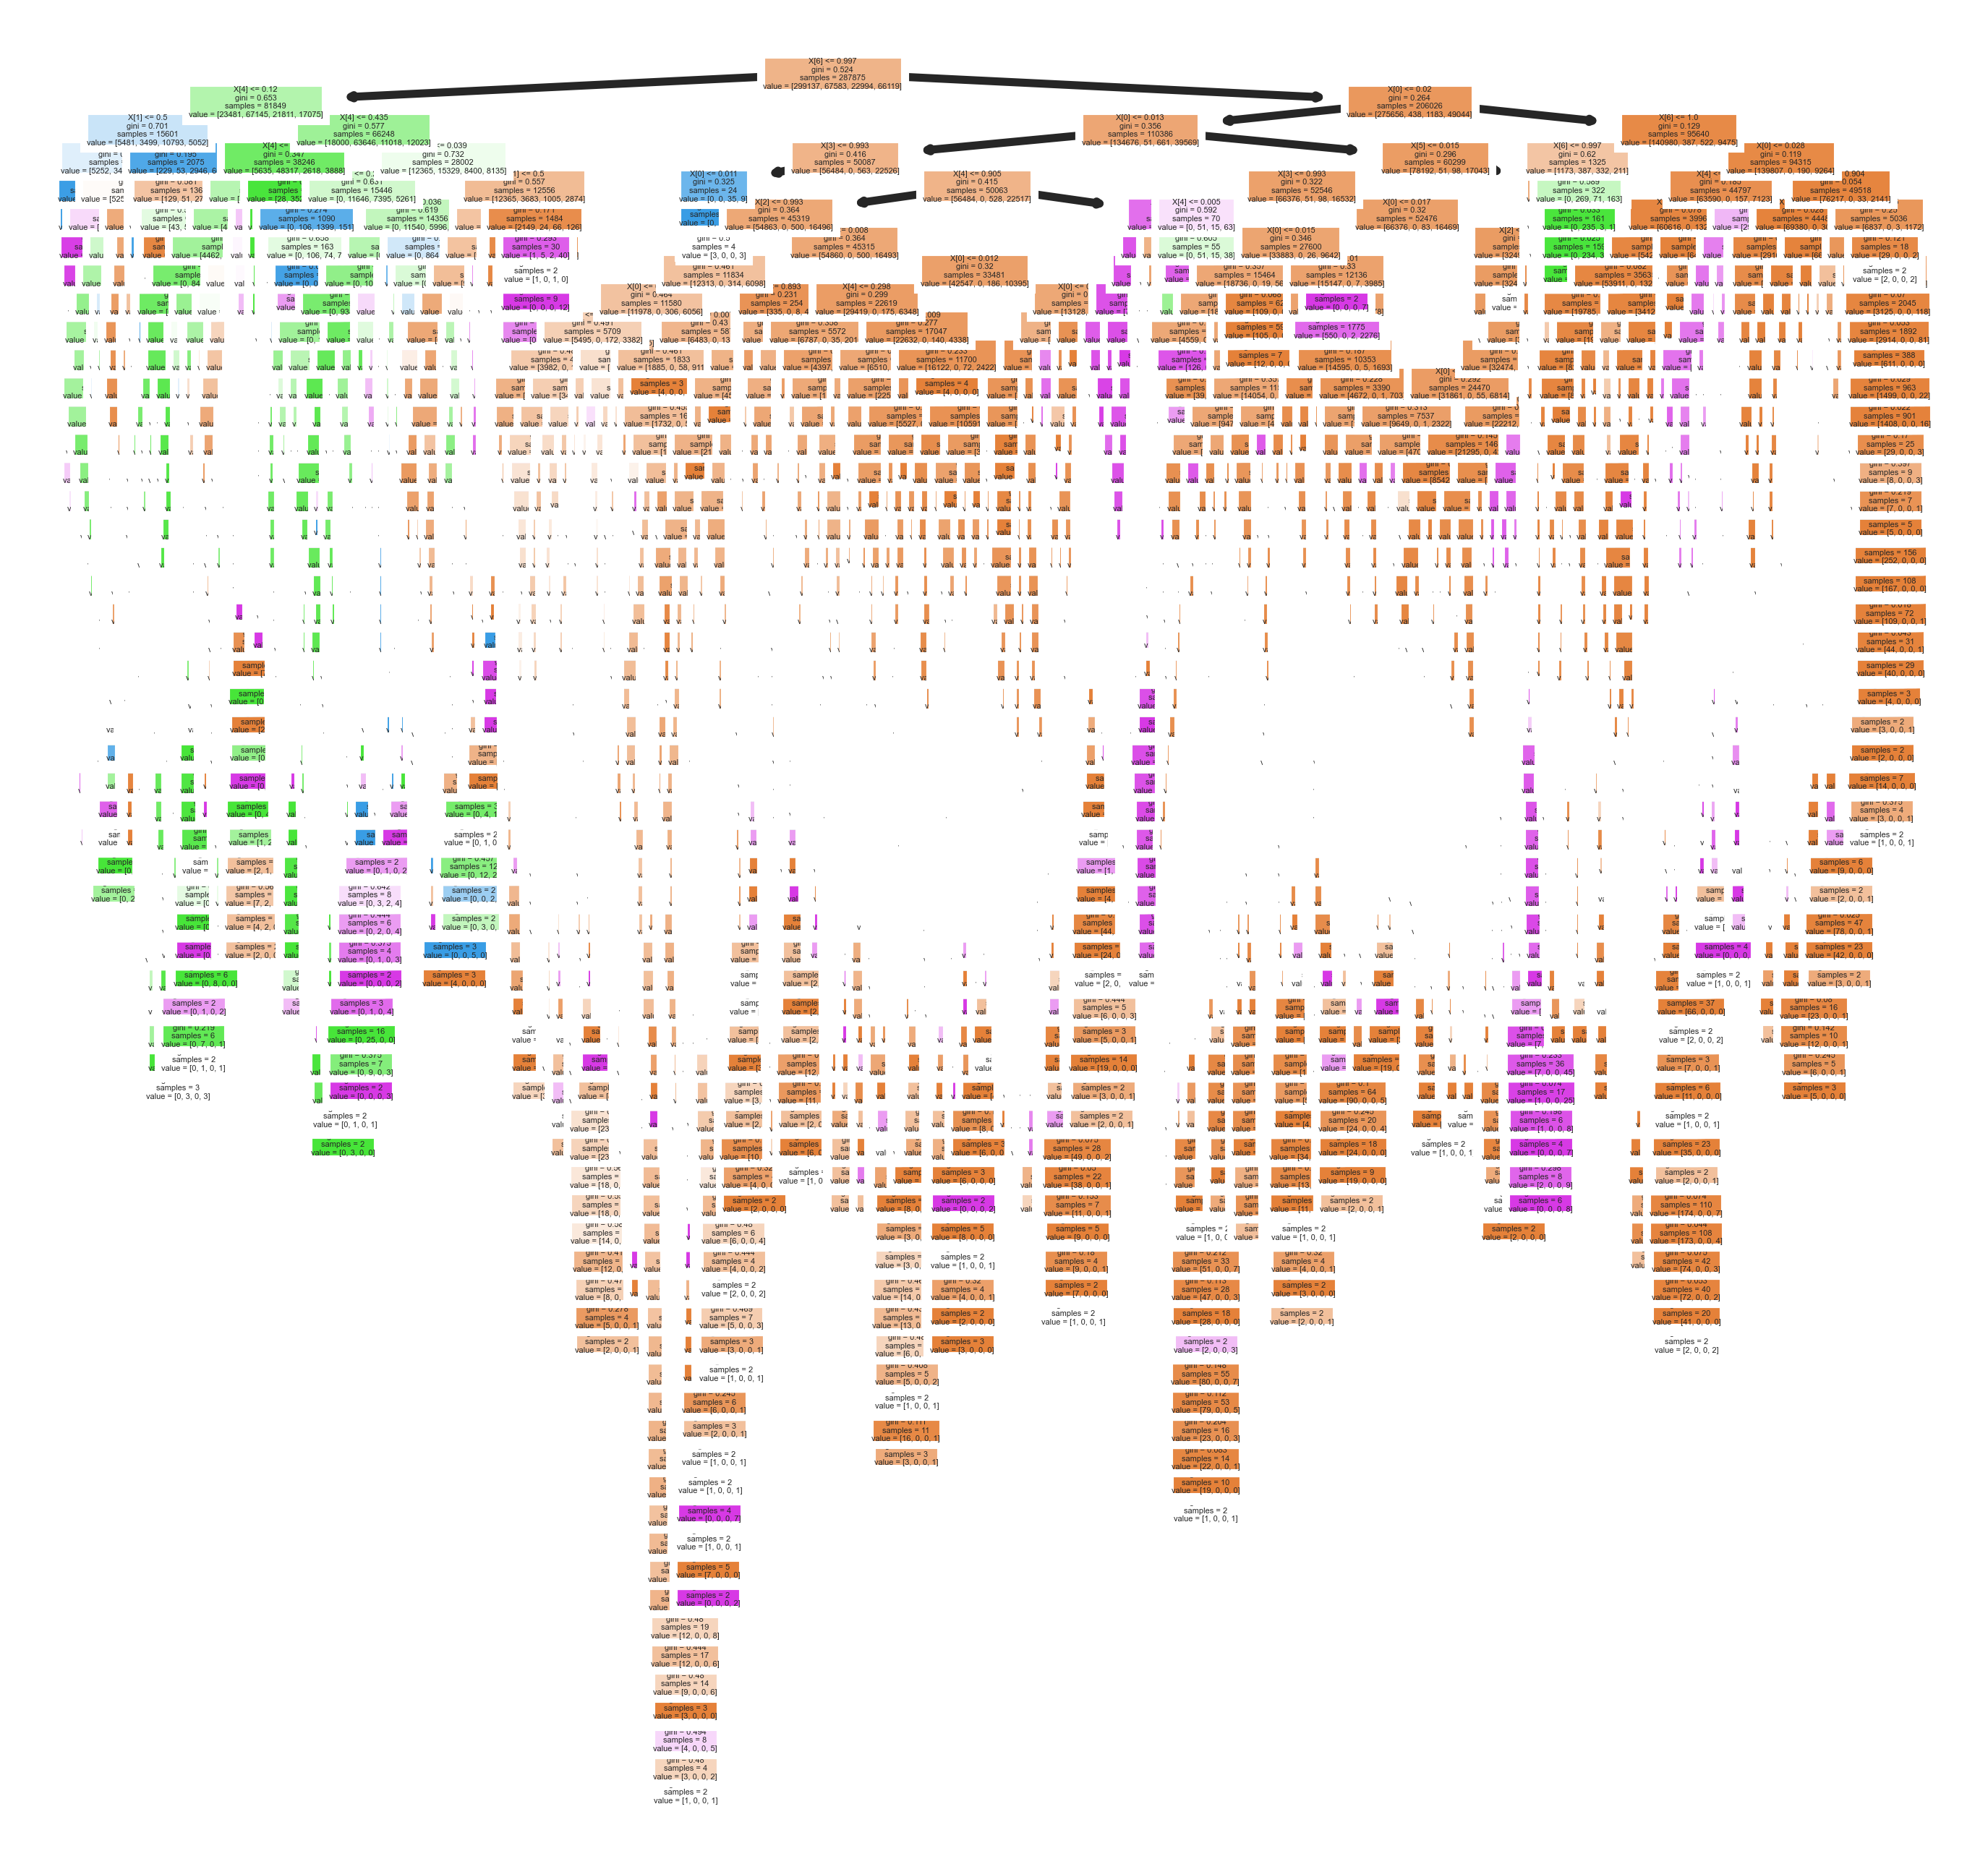

In [129]:
# Import necessary packages to plot a visualisation of the random forest:
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import export_graphviz

fig, axes = plt.subplots(nrows = 1, ncols = 1,
                         figsize = (4,4), dpi=800)

tree.plot_tree(forest.estimators_[0],
               filled = True)

fig.savefig('rf_individualtree.png')

In [130]:
# Calculate the accuracy of the model:
print("Accuracy: ", metrics.accuracy_score(y_test, y_predict))
print("")

print(classification_report(y_test, y_predict))

Accuracy:  0.9279118336592308

              precision    recall  f1-score   support

           0       0.94      0.97      0.95    128733
           1       0.95      0.99      0.97     28692
           2       0.99      0.92      0.95      9699
           3       0.82      0.67      0.74     28234

    accuracy                           0.93    195358
   macro avg       0.92      0.89      0.90    195358
weighted avg       0.92      0.93      0.93    195358



## Conclusion

The model has an accuracy score of 93%, making it the most accurate of the three models.  With a 67% chance of correctly predicting phishing URLs, it is better on this class than any of the others.